In [22]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso
import joblib
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

**Collection of Data**

In [2]:
legitimate_urls = pd.read_csv("./extracted_csv_files/legitimate-urls.csv")
phishing_urls = pd.read_csv("./extracted_csv_files/phishing-urls.csv")

In [3]:
legitimate_urls.head(5)

,Domain,Having_@_symbol,Having_IP,Path,Prefix_suffix_separation,Protocol,Redirection_//_symbol,Sub_domains,URL_Length,age_domain,dns_record,domain_registration_length,http_tokens,statistical_report,tiny_url,web_traffic,label
0,www.liquidgeneration.com,0,0,/,0,http,0,0,0,0,0,1,0,0,0,2,0
1,www.onlineanime.org,0,0,/,0,http,0,0,0,0,0,1,0,1,0,1,0
2,www.ceres.dti.ne.jp,0,0,/~nekoi/senno/senfirst.html,0,http,0,1,0,1,0,1,0,0,0,0,0
3,www.galeon.com,0,0,/kmh/,0,http,0,0,0,0,0,0,0,0,0,0,0
4,www.fanworkrecs.com,0,0,/,0,http,0,0,0,1,1,1,0,1,0,1,0


## Data PreProcessing
#### Data is in two data frames so we merge them to make one dataframe
Note: two dataframes has same column names

In [4]:
urls = legitimate_urls.append(phishing_urls)

In [5]:
urls.head(5)

,Domain,Having_@_symbol,Having_IP,Path,Prefix_suffix_separation,Protocol,Redirection_//_symbol,Sub_domains,URL_Length,age_domain,dns_record,domain_registration_length,http_tokens,statistical_report,tiny_url,web_traffic,label
0,www.liquidgeneration.com,0,0,/,0,http,0,0,0,0,0,1,0,0,0,2,0
1,www.onlineanime.org,0,0,/,0,http,0,0,0,0,0,1,0,1,0,1,0
2,www.ceres.dti.ne.jp,0,0,/~nekoi/senno/senfirst.html,0,http,0,1,0,1,0,1,0,0,0,0,0
3,www.galeon.com,0,0,/kmh/,0,http,0,0,0,0,0,0,0,0,0,0,0
4,www.fanworkrecs.com,0,0,/,0,http,0,0,0,1,1,1,0,1,0,1,0


### Removing Unnecessary columns

In [6]:
urls = urls.drop(urls.columns[[0,3,5]],axis=1)
urls.columns

Index(['Having_@_symbol', 'Having_IP', 'Prefix_suffix_separation',
       'Redirection_//_symbol', 'Sub_domains', 'URL_Length', 'age_domain',
       'dns_record', 'domain_registration_length', 'http_tokens',
       'statistical_report', 'tiny_url', 'web_traffic', 'label'],
      dtype='object')

### Suffle  rows
Since we merged two dataframes top 1000 rows will have legitimate urls and bottom 1000 rows will have phishing urls. So if we split the data now and create a model for it will overfit so we need to shuffle the rows before splitting the data into training set and test set

In [7]:
# shuffling the rows in the dataset so that when splitting the train and test set are equally distributed
urls = urls.sample(frac=1).reset_index(drop=True)

In [8]:
urls.head(5)

,Having_@_symbol,Having_IP,Prefix_suffix_separation,Redirection_//_symbol,Sub_domains,URL_Length,age_domain,dns_record,domain_registration_length,http_tokens,statistical_report,tiny_url,web_traffic,label
0,0,0,0,0,2,0,0,0,1,0,0,0,2,0
1,0,0,0,0,2,0,0,0,1,0,0,0,2,0
2,0,0,0,0,2,0,0,0,1,0,1,0,1,0
3,0,0,0,0,0,0,0,0,1,0,0,0,2,0
4,0,0,0,0,0,0,1,0,1,0,0,0,0,0


### correlation analysis

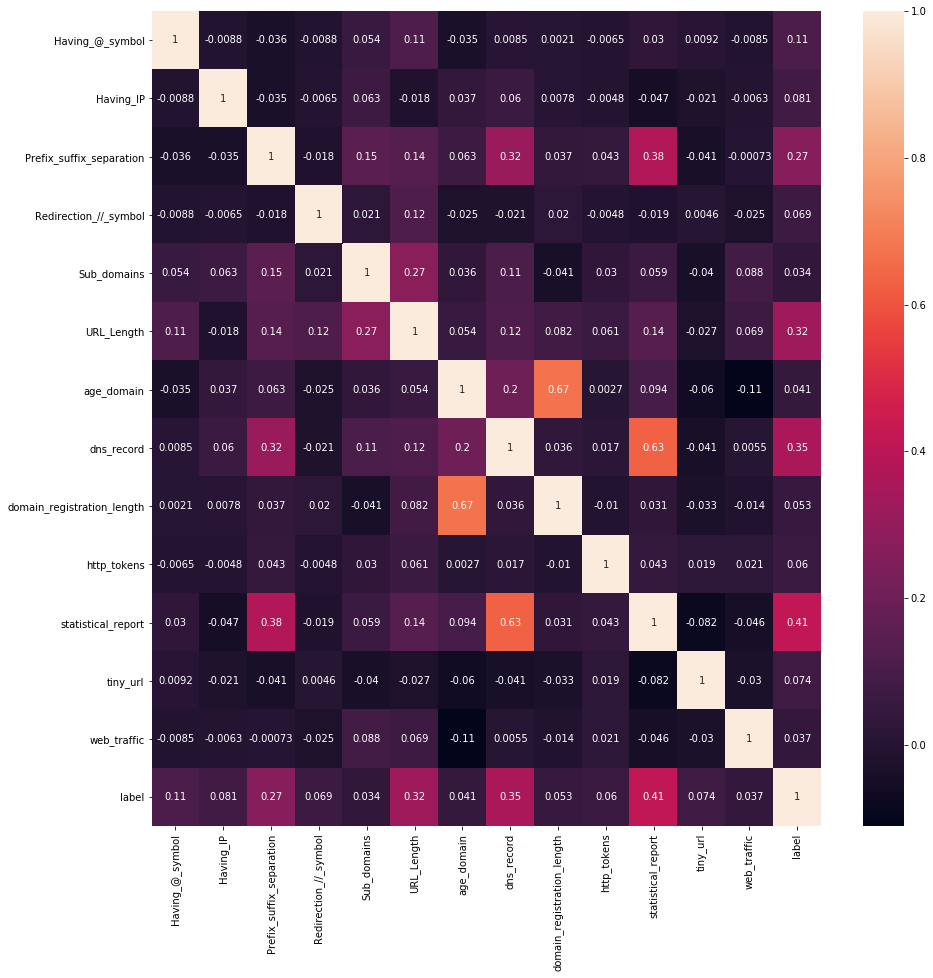

In [7]:
plt.figure(figsize=(15,15))
sns.heatmap(urls.corr(),annot=True)

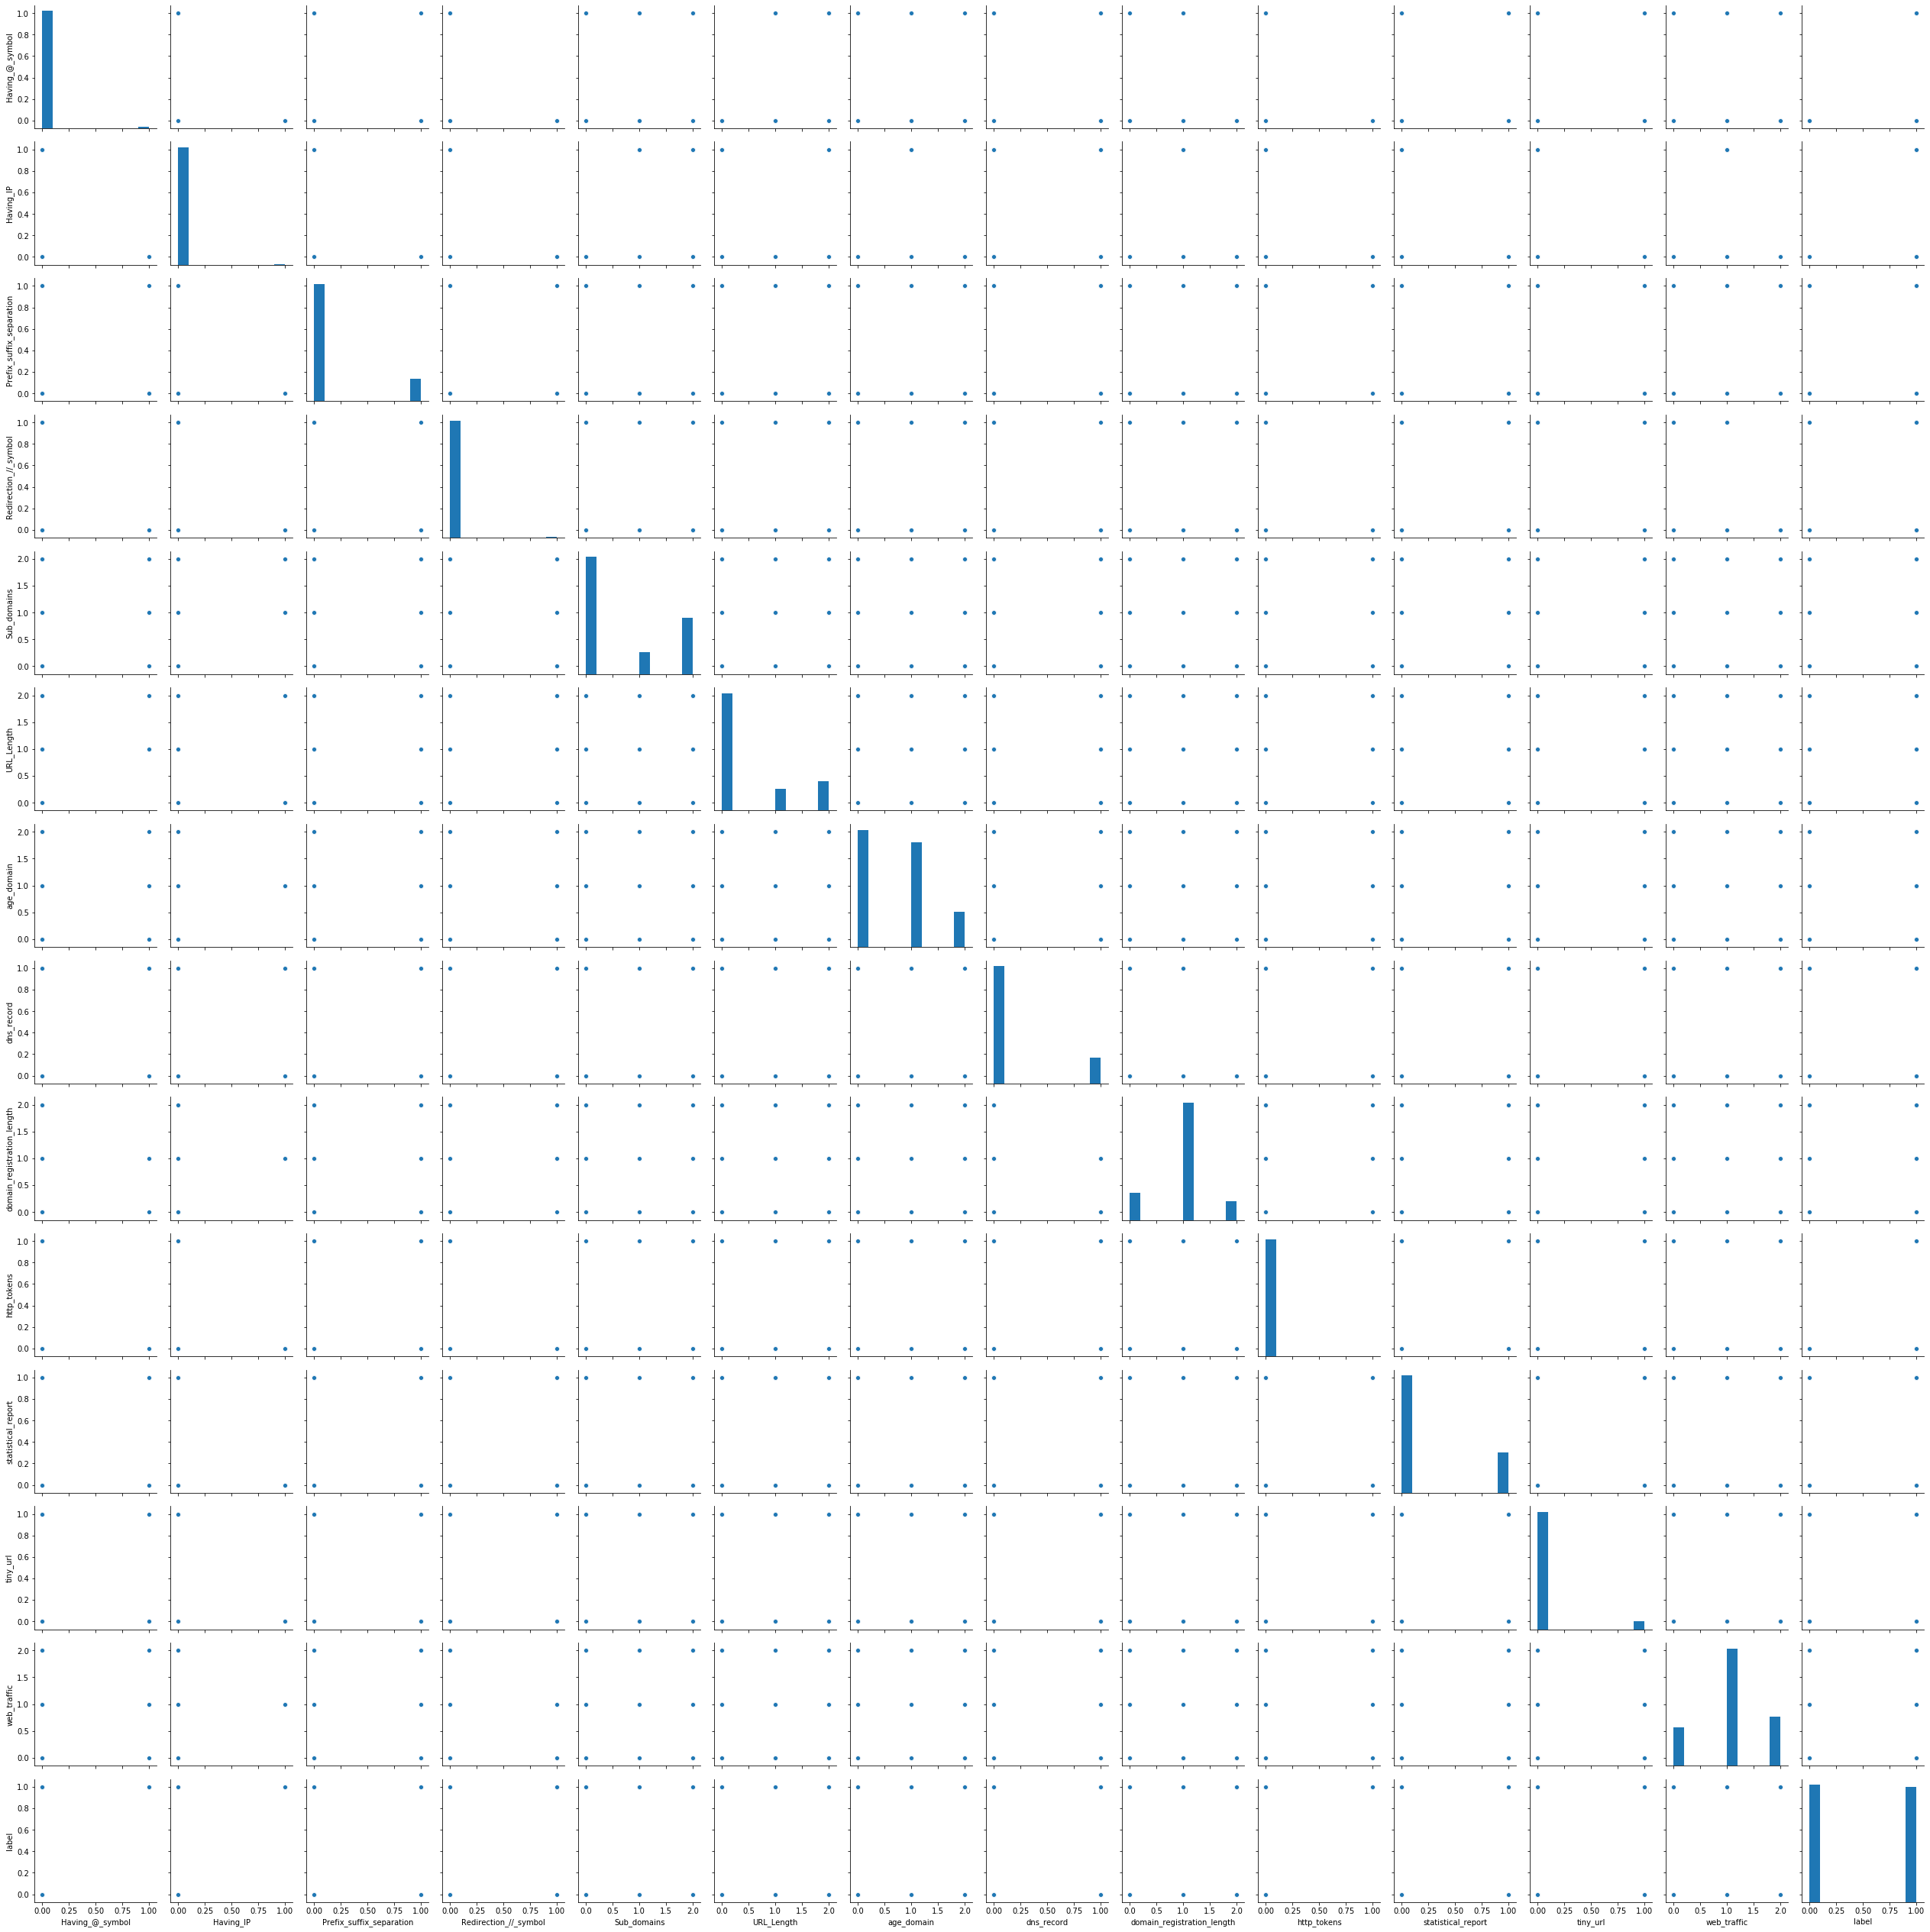

In [8]:
sns.pairplot(urls)
# urls.describe()

### Removing class variable from the dataset

In [9]:
urls_without_labels = urls.drop('label',axis=1)
labels = urls['label']

### Splitting the data into train data and test data

Dividing the data in the ratio of 80:20 [train_data:test_data]

In [10]:
from sklearn.model_selection import train_test_split
data_train, data_test, labels_train, labels_test = train_test_split(urls_without_labels, labels, test_size=0.20, random_state=110)

In [11]:
print(len(data_train),len(data_test),len(labels_train),len(labels_test))

1612 403 1612 403


### checking the split of labels in train and test data

The split should be in equal proportion for both classes

Phishing - 1

Legitimate - 0

In [12]:
#initially checking the split of labels_train data 
labels_train.value_counts()

0    811
1    801
Name: label, dtype: int64

By above results it is shown that the split of both classes are almost equal!

Testing the same for labels of test data also

In [13]:
#checking the split for labels_test data
labels_test.value_counts()

0    206
1    197
Name: label, dtype: int64

as the split is almost in equal proportion we can train the model

### General train

In [14]:
models=[KNeighborsClassifier(),LogisticRegression(),GaussianNB(),DecisionTreeClassifier(),RandomForestClassifier(),
       GradientBoostingClassifier(),SVC(), xgb.XGBClassifier(), lgb.LGBMClassifier()]
# evaluate models by using cross-validation
names=['KNN','LR','NB','Tree','RF','GDBT','SVM', 'xgb', 'lgb']
for name, model in zip(names,models):
    score=cross_val_score(model, data_train, labels_train, cv=5)
    print("{}:{},{}".format(name,score.mean(),score.std()))

KNN:0.8201315308732189,0.02352063608513457
LR:0.7394977212853104,0.031926523263491616
NB:0.5297848201065324,0.010833679404724642
Tree:0.8300405745822357,0.012710853729019658
RF:0.834390323635175,0.0172768467510033
GDBT:0.8300521123781319,0.019002798684083638
SVM:0.8201180701113397,0.015349579428829961
xgb:0.8182624079380035,0.016552966015803427
lgb:0.8306732303905544,0.020291232359570175


### KNN

In [15]:
kNN_classifier = KNeighborsClassifier()
param_dist = {'n_neighbors':range(1,100)}
grid = RandomizedSearchCV(kNN_classifier, param_dist, cv = 5, scoring = 'accuracy', n_jobs = -1)
grid.fit(data_train, labels_train)
best_estimator = grid.best_estimator_
print(best_estimator)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')


[[181  25]
 [ 40 157]]
AC and RS is: 0.8387096774193549 and 0.7969543147208121


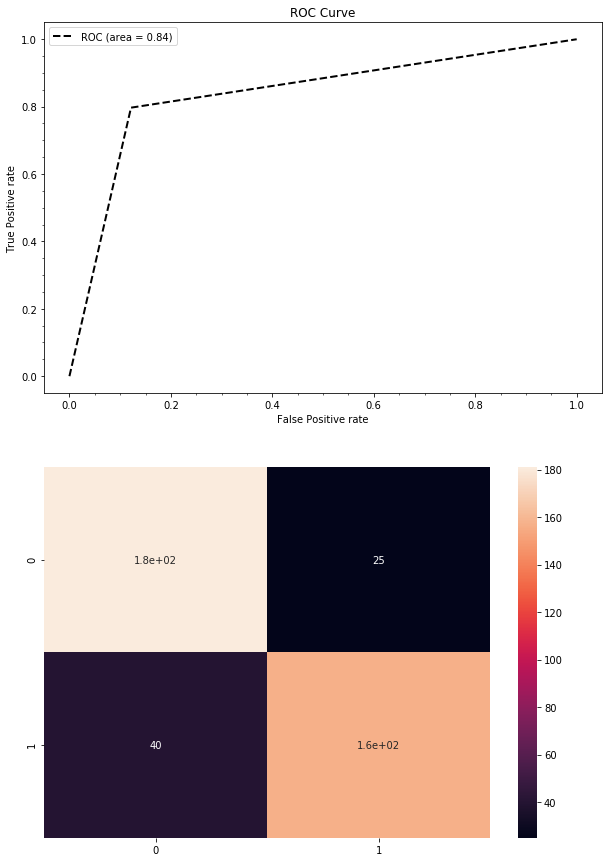

In [16]:
kNN_classifier = KNeighborsClassifier(n_neighbors=10)
kNN_classifier.fit(data_train, labels_train)
kNN_predict = kNN_classifier.predict(data_test)
cmkNN = confusion_matrix(labels_test, kNN_predict)
print(cmkNN)
print('AC and RS is: {} and {}'.format(accuracy_score(labels_test, kNN_predict),
                                       recall_score(labels_test, kNN_predict)))

fpr, tpr, thresholds = roc_curve(labels_test, kNN_predict)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,15))
plt.subplot(2,1,1)
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
plt.minorticks_on()
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(2,1,2)
sns.heatmap(cmkNN, annot=True)

### SVM

In [17]:
svm_classifier = SVC()
param_dist = {'C': np.linspace(0.01, 50, 100),
             'gamma': np.linspace(0.01, 50, 100)}
grid = RandomizedSearchCV(svm_classifier, param_dist, cv = 5, scoring = 'accuracy', n_jobs = -1)
grid.fit(data_train, labels_train)
best_estimator = grid.best_estimator_
print(best_estimator)

SVC(C=28.287171717171717, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=30.81191919191919,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


[[171  35]
 [ 33 164]]
AC and RS is: 0.8312655086848635 and 0.8324873096446701


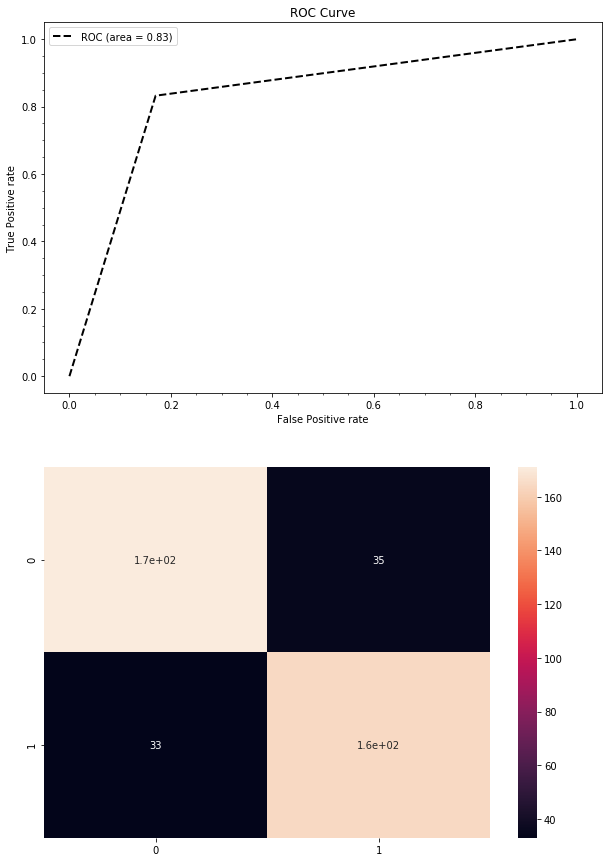

In [18]:
svm_classifier = SVC(C=28.28, gamma=30.8)
svm_classifier.fit(data_train, labels_train)
SVC_predict = svm_classifier.predict(data_test)
cmSVC = confusion_matrix(labels_test, SVC_predict)
print(cmSVC)
print('AC and RS is: {} and {}'.format(accuracy_score(labels_test, SVC_predict),
                                       recall_score(labels_test, SVC_predict)))

fpr, tpr, thresholds = roc_curve(labels_test, SVC_predict)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,15))
plt.subplot(2,1,1)
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
plt.minorticks_on()
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(2,1,2)
sns.heatmap(cmSVC, annot=True)

### RF

In [23]:
RF = RandomForestClassifier()
n_estimators = [int(x) for x in np.linspace(start = 200,stop = 2000,num = 10)]
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]
max_depth = [5,8,10]
max_features = ['auto','sqrt']
bootstrap = [True,False]
random_params_group = {'n_estimators':n_estimators,
                      'min_samples_split':min_samples_split,
                      'min_samples_leaf':min_samples_leaf,
                      'max_depth':max_depth,
                      'max_features':max_features,
                      'bootstrap':bootstrap}
random_model =RandomizedSearchCV(RF,param_distributions = random_params_group, n_iter = 100,
scoring = 'accuracy', verbose = 2, n_jobs = -1, cv = 10, random_state = 0)
random_model.fit(data_train, labels_train)
best_estimator = random_model.best_estimator_
print(best_estimator)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  5.8min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [24]:
RF_classifier = RandomForestClassifier(bootstrap=False, max_depth=10, max_features='sqrt',
                       min_samples_split=2, n_estimators=1600)
RF_classifier.fit(data_train, labels_train)
RF_predict = RF_classifier.predict(data_test)
cmRF = confusion_matrix(labels_test, RF_predict)
print(cmRF)
accuracy_score(labels_test, RF_predict)

[[181  20]
 [ 46 156]]


0.8362282878411911

### xgboost

In [19]:
parameters = {
              'max_depth': [5, 10, 15, 20, 25],
              'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
              'n_estimators': [500, 1000, 2000, 3000, 5000],
              'min_child_weight': [0, 2, 5, 10, 20],
              'max_delta_step': [0, 0.2, 0.6, 1, 2],
              'subsample': [0.6, 0.7, 0.8, 0.85, 0.95],
              'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
              'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
              'reg_lambda': [0.2, 0.4, 0.6, 0.8, 1],
              'scale_pos_weight': [0.2, 0.4, 0.6, 0.8, 1]

}
xlf = xgb.XGBClassifier(max_depth=10,
            learning_rate=0.01,
            n_estimators=2000,
            objective='binary:logistic',
            nthread=-1,
            gamma=0,
            min_child_weight=1,
            max_delta_step=0,
            subsample=0.85,
            colsample_bytree=0.7,
            colsample_bylevel=1,
            reg_alpha=0,
            reg_lambda=1,
            scale_pos_weight=1,
            seed=1440,
            missing=None)

gsearch = RandomizedSearchCV(xlf, param_distributions=parameters, scoring='accuracy', cv=5)
gsearch.fit(data_train, labels_train)

print("best score: ",gsearch.best_score_)
print("best parameters: ")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

best score:  0.836870949752899
best parameters: 
	colsample_bytree: 0.9
	learning_rate: 0.1
	max_delta_step: 2
	max_depth: 15
	min_child_weight: 2
	n_estimators: 5000
	reg_alpha: 1
	reg_lambda: 0.4
	scale_pos_weight: 0.6
	subsample: 0.7


[[181  25]
 [ 37 160]]
AC and RS is: 0.8461538461538461 and 0.8121827411167513


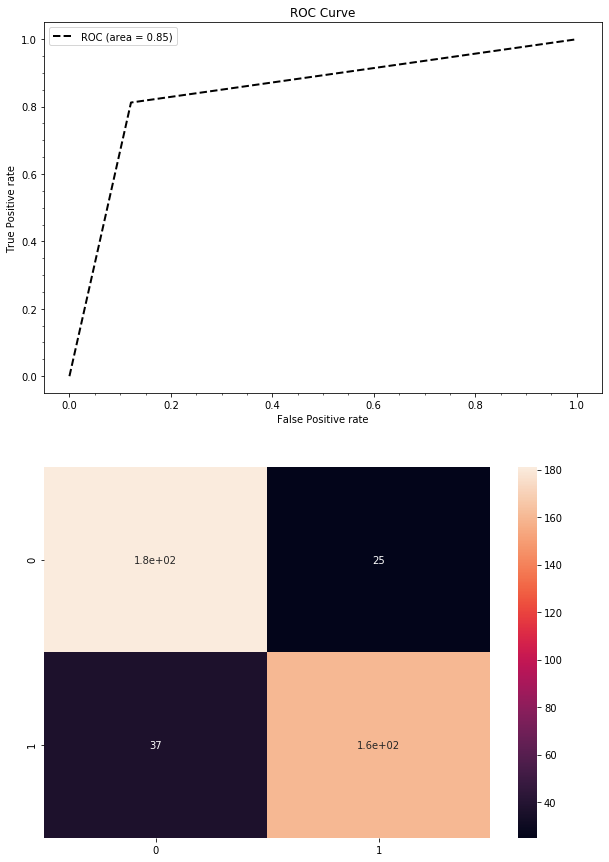

In [20]:
xgb_classifier = xgb.XGBClassifier(max_depth=15,
            learning_rate=0.1,
            n_estimators=5000,
            objective='binary:logistic',
            nthread=-1,
            gamma=0,
            min_child_weight=2,
            max_delta_step=2,
            subsample=0.7,
            colsample_bytree=0.9,
            colsample_bylevel=1,
            reg_alpha=1,
            reg_lambda=0.4,
            scale_pos_weight=0.6,
            seed=1440,
            missing=None)

xgb_classifier.fit(data_train, labels_train)
xgb_predict = xgb_classifier.predict(data_test)
cmXgb = confusion_matrix(labels_test, xgb_predict)
print(cmXgb)
print('AC and RS is: {} and {}'.format(accuracy_score(labels_test, xgb_predict), recall_score(labels_test, xgb_predict)))

fpr, tpr, thresholds = roc_curve(labels_test, xgb_predict)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,15))
plt.subplot(2,1,1)
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
plt.minorticks_on()
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(2,1,2)
sns.heatmap(cmXgb, annot=True)

### lightgbm

fold 1
Training until validation scores don't improve for 600 rounds
[20]	training's auc: 0.898561	training's binary_logloss: 0.526693	valid_1's auc: 0.880854	valid_1's binary_logloss: 0.536009
[40]	training's auc: 0.902838	training's binary_logloss: 0.4546	valid_1's auc: 0.88331	valid_1's binary_logloss: 0.471654
[60]	training's auc: 0.904336	training's binary_logloss: 0.420819	valid_1's auc: 0.884692	valid_1's binary_logloss: 0.442274
[80]	training's auc: 0.907594	training's binary_logloss: 0.400055	valid_1's auc: 0.885863	valid_1's binary_logloss: 0.42431
[100]	training's auc: 0.911647	training's binary_logloss: 0.388567	valid_1's auc: 0.88997	valid_1's binary_logloss: 0.415329
[120]	training's auc: 0.913094	training's binary_logloss: 0.381443	valid_1's auc: 0.89116	valid_1's binary_logloss: 0.411865
[140]	training's auc: 0.914088	training's binary_logloss: 0.376672	valid_1's auc: 0.892734	valid_1's binary_logloss: 0.409108
[160]	training's auc: 0.914926	training's binary_logloss: 0

[460]	training's auc: 0.926742	training's binary_logloss: 0.34151	valid_1's auc: 0.89902	valid_1's binary_logloss: 0.411489
[480]	training's auc: 0.927606	training's binary_logloss: 0.34069	valid_1's auc: 0.898943	valid_1's binary_logloss: 0.411367
[500]	training's auc: 0.928028	training's binary_logloss: 0.339922	valid_1's auc: 0.899097	valid_1's binary_logloss: 0.411429
[520]	training's auc: 0.927792	training's binary_logloss: 0.338933	valid_1's auc: 0.898827	valid_1's binary_logloss: 0.41049
[540]	training's auc: 0.928861	training's binary_logloss: 0.337998	valid_1's auc: 0.899404	valid_1's binary_logloss: 0.410406
[560]	training's auc: 0.929073	training's binary_logloss: 0.337051	valid_1's auc: 0.898827	valid_1's binary_logloss: 0.410313
[580]	training's auc: 0.929465	training's binary_logloss: 0.336233	valid_1's auc: 0.899712	valid_1's binary_logloss: 0.410275
[600]	training's auc: 0.929595	training's binary_logloss: 0.335563	valid_1's auc: 0.899404	valid_1's binary_logloss: 0.410

fold 4
Training until validation scores don't improve for 600 rounds
[20]	training's auc: 0.892875	training's binary_logloss: 0.531261	valid_1's auc: 0.897902	valid_1's binary_logloss: 0.5288
[40]	training's auc: 0.897329	training's binary_logloss: 0.459105	valid_1's auc: 0.901366	valid_1's binary_logloss: 0.458016
[60]	training's auc: 0.902772	training's binary_logloss: 0.424952	valid_1's auc: 0.908799	valid_1's binary_logloss: 0.422189
[80]	training's auc: 0.905452	training's binary_logloss: 0.403571	valid_1's auc: 0.912282	valid_1's binary_logloss: 0.399416
[100]	training's auc: 0.907343	training's binary_logloss: 0.392739	valid_1's auc: 0.914675	valid_1's binary_logloss: 0.389148
[120]	training's auc: 0.909011	training's binary_logloss: 0.386294	valid_1's auc: 0.914948	valid_1's binary_logloss: 0.383171
[140]	training's auc: 0.909882	training's binary_logloss: 0.380437	valid_1's auc: 0.91522	valid_1's binary_logloss: 0.379407
[160]	training's auc: 0.911663	training's binary_logloss

[640]	training's auc: 0.927807	training's binary_logloss: 0.338808	valid_1's auc: 0.907054	valid_1's binary_logloss: 0.385103
[660]	training's auc: 0.927896	training's binary_logloss: 0.338235	valid_1's auc: 0.905659	valid_1's binary_logloss: 0.385181
[680]	training's auc: 0.928242	training's binary_logloss: 0.337659	valid_1's auc: 0.905271	valid_1's binary_logloss: 0.384767
[700]	training's auc: 0.928579	training's binary_logloss: 0.337124	valid_1's auc: 0.90686	valid_1's binary_logloss: 0.384449
[720]	training's auc: 0.928874	training's binary_logloss: 0.336577	valid_1's auc: 0.907519	valid_1's binary_logloss: 0.383824
[740]	training's auc: 0.929016	training's binary_logloss: 0.336066	valid_1's auc: 0.907752	valid_1's binary_logloss: 0.383779
[760]	training's auc: 0.929245	training's binary_logloss: 0.335616	valid_1's auc: 0.907868	valid_1's binary_logloss: 0.383294
[780]	training's auc: 0.929228	training's binary_logloss: 0.335167	valid_1's auc: 0.908217	valid_1's binary_logloss: 0.

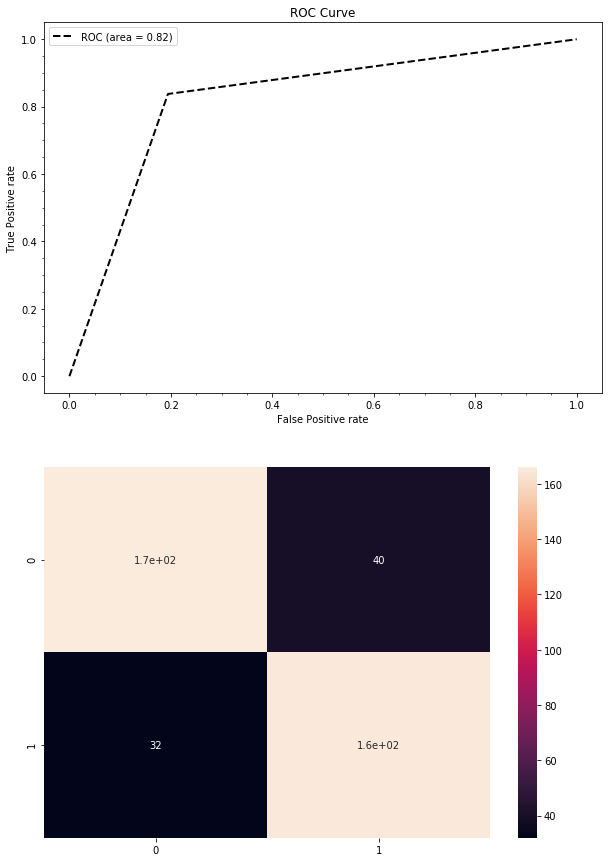

In [23]:
params = {'num_leaves': 60, #结果对最终效果影响较大，越大值越好，太大会出现过拟合
          'min_data_in_leaf': 30,
          'objective': 'binary', #定义的目标函数
          'max_depth': -1,
          'learning_rate': 0.03,
          "min_sum_hessian_in_leaf": 6,
          "boosting": "gbdt",
          "feature_fraction": 0.9,  #提取的特征比率
          "bagging_freq": 1,
          "bagging_fraction": 0.8,
          "bagging_seed": 11,
          "lambda_l1": 0.1,             #l1正则
          # 'lambda_l2': 0.001,     #l2正则
          "verbosity": -1,
          "nthread": -1,                #线程数量，-1表示全部线程，线程越多，运行的速度越快
          'metric': {'binary_logloss', 'auc'},  ##评价函数选择
          "random_state": 2021, #随机数种子，可以防止每次运行的结果不一致
          # 'device': 'gpu' ##如果安装的事gpu版本的lightgbm,可以加快运算
          }

folds = KFold(n_splits=5, shuffle=True, random_state=2021)
prob_oof = np.zeros((data_train.shape[0], ))
test_pred_prob = np.zeros((data_test.shape[0], ))


## train and predict
feature_importance_df = pd.DataFrame()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(data_train)):
    print("fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(data_train.iloc[trn_idx], label=labels_train.iloc[trn_idx])
    val_data = lgb.Dataset(data_train.iloc[val_idx], label=labels_train.iloc[val_idx])


    clf = lgb.train(params,
                    trn_data,
                    num_boost_round=1000,
                    valid_sets=[trn_data, val_data],
                    verbose_eval=20,
                    early_stopping_rounds=600)
    prob_oof[val_idx] = clf.predict(data_train.iloc[val_idx], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = urls_without_labels.columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    test_pred_prob += clf.predict(data_test[urls_without_labels.columns], num_iteration=clf.best_iteration) / folds.n_splits

threshold = 0.5
for pred in test_pred_prob:
    result = 1 if pred > threshold else 0
    
# save model
savepath = '/Users/gexueren/Desktop/Phishing Websites Detection/PhishingWebsiteDefenseApp/model'
if not os.path.exists(savepath):
    os.makedirs(savepath)
joblib.dump(clf, os.path.join(savepath, 'lgb_model.pkl'))

predicts = clf.predict(data_test)
lgb_predict = []
for pred in predicts:
    if pred > threshold: 
        lgb_predict.append(1)
    else:
        lgb_predict.append(0)

print('\n This following info is confusion matrix and accuracy score:')
cmlgb = confusion_matrix(labels_test, lgb_predict)
print(cmlgb)
print('AC and RS is: {} and {}'.format(accuracy_score(labels_test, lgb_predict),
                                       recall_score(labels_test, lgb_predict)))
fpr, tpr, thresholds = roc_curve(labels_test, lgb_predict)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,15))
plt.subplot(2,1,1)
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
plt.minorticks_on()
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(2,1,2)
sns.heatmap(cmlgb, annot=True)

<Figure size 864x432 with 0 Axes>

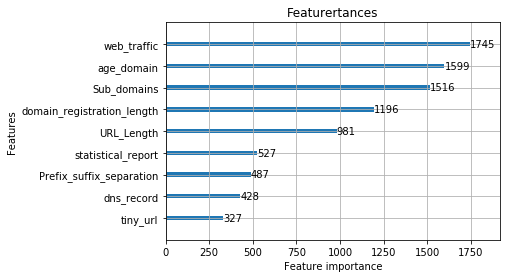

In [24]:
plt.figure(figsize=(12,6))
lgb.plot_importance(clf, max_num_features=30)
plt.title("Featurertances")
plt.show()

### Stacking model

In [25]:
# get a stacking ensemble of models
def get_stacking():
    level0 = []
    level0.append(('xgb', xgb.XGBClassifier()))
    level0.append(('lgb', lgb.LGBMClassifier()))
    level0.append(('RF', RandomForestClassifier()))
    level0.append(('SVC', SVC()))
    level0.append(('knn', KNeighborsClassifier()))
    level1 = GradientBoostingClassifier()
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

stack_model = get_stacking()
stack_model.fit(data_train, labels_train)
stack_model_predict = stack_model.predict(data_test)
cmStack = confusion_matrix(labels_test, stack_model_predict)
print(cmStack)
accuracy_score(labels_test, stack_model_predict)

[[175  31]
 [ 37 160]]


0.8312655086848635

### Save model

In [26]:
savepath = '/Users/gexueren/Desktop/Phishing Websites Detection/PhishingWebsiteDefenseApp/model'
if not os.path.exists(savepath):
    os.makedirs(savepath)

xgb_classifier = xgb.XGBClassifier(max_depth=15,
            learning_rate=0.1,
            n_estimators=5000,
            objective='binary:logistic',
            nthread=-1,
            gamma=0,
            min_child_weight=2,
            max_delta_step=2,
            subsample=0.7,
            colsample_bytree=0.9,
            colsample_bylevel=1,
            reg_alpha=1,
            reg_lambda=0.4,
            scale_pos_weight=0.6,
            seed=1440,
            missing=None)

xgb_classifier.fit(data_train, labels_train)
joblib.dump(xgb_classifier, os.path.join(savepath, "xgb_model.pkl"))

['/Users/gexueren/Desktop/Phishing Websites Detection/PhishingWebsiteDefenseApp/model/xgb_model.pkl']

# Dnn

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

## data preprocess

In [36]:
legitimate_urls = pd.read_csv("./extracted_csv_files/legitimate-urls.csv")
phishing_urls = pd.read_csv("./extracted_csv_files/phishing-urls.csv")
urls = legitimate_urls.append(phishing_urls)
urls = urls.drop(urls.columns[[0,3,5]],axis=1)
urls_without_labels = urls.drop('label',axis=1)
labels = urls['label']
data_train, data_test, labels_train, labels_test = train_test_split(urls_without_labels, labels, test_size=0.20, random_state=42)


data_train = data_train.values
labels_train = labels_train.values[:, np.newaxis]

data_test = data_test.values
labels_test = labels_test.values[:, np.newaxis]

class myData(torch.utils.data.Dataset):
    def __init__(self, data, label):
        self.data = np.asarray(data)
        self.label = np.asarray(label)
    
    def __getitem__(self, index):
        txt = torch.from_numpy(self.data[index])
        label = torch.from_numpy(self.label[index])
        return txt, label #返回标签
 
    def __len__(self):
        return len(self.data)

train_dataset = myData(data=data_train, label=labels_train)
test_dataset = myData(data=data_test, label=labels_test)

batch_size = 16
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
print('Training data is {} \nTest data is {}'.format(train_dataset.__len__(), test_dataset.__len__()))

Training data is 1612 
Test data is 403


## define DNN structure

In [53]:
class dnn(nn.Module):
    def __init__(self):
        super(dnn, self).__init__()
        self.l1 = nn.Linear(13, 32)
        self.l2 = nn.Linear(32, 64)
        self.l3 = nn.Linear(64, 30)
        self.l4 = nn.Linear(30, 1)
#         self.l5 = nn.Linear(15, 5)
#         self.l6 = nn.Linear(5, 1)
        self.dropout = nn.Dropout(p=0.5) 
        
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.dropout(x)
        x = F.relu(self.l3(x))
#         x = F.relu(self.l4(x))
#         x = self.dropout(x)
#         x = F.relu(self.l5(x))
        return self.l4(x)

In [54]:
model = dnn()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

def train(epoch):
    model.train()
    L = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = Variable(data).float(), Variable(label).float()
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy_with_logits(output, label)
        loss.backward()
        optimizer.step()
        L += loss.item()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
    return L/(batch_idx+1)

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data,volatile=True).float(), Variable(target).float()
        output = model(data)
        # sum up batch loss
        test_loss += F.binary_cross_entropy_with_logits(output, target).data.item()
        # get the index of the max
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [55]:
loss = []
for epoch in range(1, 2000):
    loss.append(train(epoch))
    test()

Train Epoch: 1 [0/1612 (0%)] Loss: 0.700074
Train Epoch: 1 [160/1612 (10%)] Loss: 0.701498
Train Epoch: 1 [320/1612 (20%)] Loss: 0.685195
Train Epoch: 1 [480/1612 (30%)] Loss: 0.696389
Train Epoch: 1 [640/1612 (40%)] Loss: 0.691091
Train Epoch: 1 [800/1612 (50%)] Loss: 0.699648
Train Epoch: 1 [960/1612 (59%)] Loss: 0.693768
Train Epoch: 1 [1120/1612 (69%)] Loss: 0.690187
Train Epoch: 1 [1280/1612 (79%)] Loss: 0.684470
Train Epoch: 1 [1440/1612 (89%)] Loss: 0.683518
Train Epoch: 1 [1200/1612 (99%)] Loss: 0.700793

Test set: Average loss: 0.0446, Accuracy: 197/403 (49%)

Train Epoch: 2 [0/1612 (0%)] Loss: 0.698458
Train Epoch: 2 [160/1612 (10%)] Loss: 0.684284
Train Epoch: 2 [320/1612 (20%)] Loss: 0.688019
Train Epoch: 2 [480/1612 (30%)] Loss: 0.690234
Train Epoch: 2 [640/1612 (40%)] Loss: 0.684151
Train Epoch: 2 [800/1612 (50%)] Loss: 0.676173
Train Epoch: 2 [960/1612 (59%)] Loss: 0.693498
Train Epoch: 2 [1120/1612 (69%)] Loss: 0.684513
Train Epoch: 2 [1280/1612 (79%)] Loss: 0.696736
Tr

Train Epoch: 15 [480/1612 (30%)] Loss: 0.626867
Train Epoch: 15 [640/1612 (40%)] Loss: 0.680899
Train Epoch: 15 [800/1612 (50%)] Loss: 0.667914
Train Epoch: 15 [960/1612 (59%)] Loss: 0.698133
Train Epoch: 15 [1120/1612 (69%)] Loss: 0.661751
Train Epoch: 15 [1280/1612 (79%)] Loss: 0.624837
Train Epoch: 15 [1440/1612 (89%)] Loss: 0.734289
Train Epoch: 15 [1200/1612 (99%)] Loss: 0.657010

Test set: Average loss: 0.0408, Accuracy: 197/403 (49%)

Train Epoch: 16 [0/1612 (0%)] Loss: 0.684817
Train Epoch: 16 [160/1612 (10%)] Loss: 0.599656
Train Epoch: 16 [320/1612 (20%)] Loss: 0.648255
Train Epoch: 16 [480/1612 (30%)] Loss: 0.625121
Train Epoch: 16 [640/1612 (40%)] Loss: 0.682848
Train Epoch: 16 [800/1612 (50%)] Loss: 0.648326
Train Epoch: 16 [960/1612 (59%)] Loss: 0.675334
Train Epoch: 16 [1120/1612 (69%)] Loss: 0.684882
Train Epoch: 16 [1280/1612 (79%)] Loss: 0.605962
Train Epoch: 16 [1440/1612 (89%)] Loss: 0.707804
Train Epoch: 16 [1200/1612 (99%)] Loss: 0.631380

Test set: Average loss: 

Train Epoch: 29 [800/1612 (50%)] Loss: 0.614203
Train Epoch: 29 [960/1612 (59%)] Loss: 0.476769
Train Epoch: 29 [1120/1612 (69%)] Loss: 0.465707
Train Epoch: 29 [1280/1612 (79%)] Loss: 0.577596
Train Epoch: 29 [1440/1612 (89%)] Loss: 0.629090
Train Epoch: 29 [1200/1612 (99%)] Loss: 0.519992

Test set: Average loss: 0.0334, Accuracy: 197/403 (49%)

Train Epoch: 30 [0/1612 (0%)] Loss: 0.430618
Train Epoch: 30 [160/1612 (10%)] Loss: 0.573275
Train Epoch: 30 [320/1612 (20%)] Loss: 0.448782
Train Epoch: 30 [480/1612 (30%)] Loss: 0.482654
Train Epoch: 30 [640/1612 (40%)] Loss: 0.593916
Train Epoch: 30 [800/1612 (50%)] Loss: 0.356016
Train Epoch: 30 [960/1612 (59%)] Loss: 0.510216
Train Epoch: 30 [1120/1612 (69%)] Loss: 0.570002
Train Epoch: 30 [1280/1612 (79%)] Loss: 0.491733
Train Epoch: 30 [1440/1612 (89%)] Loss: 0.606330
Train Epoch: 30 [1200/1612 (99%)] Loss: 0.475233

Test set: Average loss: 0.0336, Accuracy: 197/403 (49%)

Train Epoch: 31 [0/1612 (0%)] Loss: 0.433516
Train Epoch: 31 [1

Train Epoch: 43 [1440/1612 (89%)] Loss: 0.476207
Train Epoch: 43 [1200/1612 (99%)] Loss: 0.520386

Test set: Average loss: 0.0319, Accuracy: 197/403 (49%)

Train Epoch: 44 [0/1612 (0%)] Loss: 0.448816
Train Epoch: 44 [160/1612 (10%)] Loss: 0.488263
Train Epoch: 44 [320/1612 (20%)] Loss: 0.613311
Train Epoch: 44 [480/1612 (30%)] Loss: 0.380249
Train Epoch: 44 [640/1612 (40%)] Loss: 0.439020
Train Epoch: 44 [800/1612 (50%)] Loss: 0.608730
Train Epoch: 44 [960/1612 (59%)] Loss: 0.388745
Train Epoch: 44 [1120/1612 (69%)] Loss: 0.553439
Train Epoch: 44 [1280/1612 (79%)] Loss: 0.461583
Train Epoch: 44 [1440/1612 (89%)] Loss: 0.408933
Train Epoch: 44 [1200/1612 (99%)] Loss: 0.777074

Test set: Average loss: 0.0320, Accuracy: 197/403 (49%)

Train Epoch: 45 [0/1612 (0%)] Loss: 0.627396
Train Epoch: 45 [160/1612 (10%)] Loss: 0.535067
Train Epoch: 45 [320/1612 (20%)] Loss: 0.640106
Train Epoch: 45 [480/1612 (30%)] Loss: 0.491545
Train Epoch: 45 [640/1612 (40%)] Loss: 0.473342
Train Epoch: 45 [800

Train Epoch: 58 [800/1612 (50%)] Loss: 0.409048
Train Epoch: 58 [960/1612 (59%)] Loss: 0.638183
Train Epoch: 58 [1120/1612 (69%)] Loss: 0.541800
Train Epoch: 58 [1280/1612 (79%)] Loss: 0.449635
Train Epoch: 58 [1440/1612 (89%)] Loss: 0.437762
Train Epoch: 58 [1200/1612 (99%)] Loss: 0.349316

Test set: Average loss: 0.0324, Accuracy: 197/403 (49%)

Train Epoch: 59 [0/1612 (0%)] Loss: 0.472439
Train Epoch: 59 [160/1612 (10%)] Loss: 0.405613
Train Epoch: 59 [320/1612 (20%)] Loss: 0.478838
Train Epoch: 59 [480/1612 (30%)] Loss: 0.500531
Train Epoch: 59 [640/1612 (40%)] Loss: 0.515365
Train Epoch: 59 [800/1612 (50%)] Loss: 0.936760
Train Epoch: 59 [960/1612 (59%)] Loss: 0.576713
Train Epoch: 59 [1120/1612 (69%)] Loss: 0.559243
Train Epoch: 59 [1280/1612 (79%)] Loss: 0.361325
Train Epoch: 59 [1440/1612 (89%)] Loss: 0.558353
Train Epoch: 59 [1200/1612 (99%)] Loss: 0.965056

Test set: Average loss: 0.0314, Accuracy: 197/403 (49%)

Train Epoch: 60 [0/1612 (0%)] Loss: 0.751520
Train Epoch: 60 [1

Train Epoch: 73 [160/1612 (10%)] Loss: 0.432825
Train Epoch: 73 [320/1612 (20%)] Loss: 0.447127
Train Epoch: 73 [480/1612 (30%)] Loss: 0.708764
Train Epoch: 73 [640/1612 (40%)] Loss: 0.240035
Train Epoch: 73 [800/1612 (50%)] Loss: 0.692828
Train Epoch: 73 [960/1612 (59%)] Loss: 0.542776
Train Epoch: 73 [1120/1612 (69%)] Loss: 0.563386
Train Epoch: 73 [1280/1612 (79%)] Loss: 0.549819
Train Epoch: 73 [1440/1612 (89%)] Loss: 0.477073
Train Epoch: 73 [1200/1612 (99%)] Loss: 0.703493

Test set: Average loss: 0.0306, Accuracy: 197/403 (49%)

Train Epoch: 74 [0/1612 (0%)] Loss: 0.378438
Train Epoch: 74 [160/1612 (10%)] Loss: 0.465531
Train Epoch: 74 [320/1612 (20%)] Loss: 0.547888
Train Epoch: 74 [480/1612 (30%)] Loss: 0.570307
Train Epoch: 74 [640/1612 (40%)] Loss: 0.477486
Train Epoch: 74 [800/1612 (50%)] Loss: 0.449540
Train Epoch: 74 [960/1612 (59%)] Loss: 0.592702
Train Epoch: 74 [1120/1612 (69%)] Loss: 0.621875
Train Epoch: 74 [1280/1612 (79%)] Loss: 0.476755
Train Epoch: 74 [1440/1612 

Train Epoch: 87 [960/1612 (59%)] Loss: 0.571952
Train Epoch: 87 [1120/1612 (69%)] Loss: 0.534409
Train Epoch: 87 [1280/1612 (79%)] Loss: 0.600574
Train Epoch: 87 [1440/1612 (89%)] Loss: 0.310859
Train Epoch: 87 [1200/1612 (99%)] Loss: 0.291809

Test set: Average loss: 0.0302, Accuracy: 197/403 (49%)

Train Epoch: 88 [0/1612 (0%)] Loss: 0.408898
Train Epoch: 88 [160/1612 (10%)] Loss: 0.525629
Train Epoch: 88 [320/1612 (20%)] Loss: 0.338479
Train Epoch: 88 [480/1612 (30%)] Loss: 0.623145
Train Epoch: 88 [640/1612 (40%)] Loss: 0.385450
Train Epoch: 88 [800/1612 (50%)] Loss: 0.589608
Train Epoch: 88 [960/1612 (59%)] Loss: 0.485623
Train Epoch: 88 [1120/1612 (69%)] Loss: 0.561383
Train Epoch: 88 [1280/1612 (79%)] Loss: 0.618426
Train Epoch: 88 [1440/1612 (89%)] Loss: 0.481005
Train Epoch: 88 [1200/1612 (99%)] Loss: 0.460500

Test set: Average loss: 0.0298, Accuracy: 197/403 (49%)

Train Epoch: 89 [0/1612 (0%)] Loss: 0.537364
Train Epoch: 89 [160/1612 (10%)] Loss: 0.310827
Train Epoch: 89 [3

Train Epoch: 102 [1200/1612 (99%)] Loss: 0.285732

Test set: Average loss: 0.0285, Accuracy: 197/403 (49%)

Train Epoch: 103 [0/1612 (0%)] Loss: 0.281094
Train Epoch: 103 [160/1612 (10%)] Loss: 0.466620
Train Epoch: 103 [320/1612 (20%)] Loss: 0.312825
Train Epoch: 103 [480/1612 (30%)] Loss: 0.391136
Train Epoch: 103 [640/1612 (40%)] Loss: 0.395845
Train Epoch: 103 [800/1612 (50%)] Loss: 0.383298
Train Epoch: 103 [960/1612 (59%)] Loss: 0.380401
Train Epoch: 103 [1120/1612 (69%)] Loss: 0.371131
Train Epoch: 103 [1280/1612 (79%)] Loss: 0.670388
Train Epoch: 103 [1440/1612 (89%)] Loss: 0.451358
Train Epoch: 103 [1200/1612 (99%)] Loss: 0.391780

Test set: Average loss: 0.0285, Accuracy: 197/403 (49%)

Train Epoch: 104 [0/1612 (0%)] Loss: 0.514012
Train Epoch: 104 [160/1612 (10%)] Loss: 0.375032
Train Epoch: 104 [320/1612 (20%)] Loss: 0.371753
Train Epoch: 104 [480/1612 (30%)] Loss: 0.350080
Train Epoch: 104 [640/1612 (40%)] Loss: 0.447900
Train Epoch: 104 [800/1612 (50%)] Loss: 0.479116
Tra

Train Epoch: 117 [1200/1612 (99%)] Loss: 0.284788

Test set: Average loss: 0.0275, Accuracy: 197/403 (49%)

Train Epoch: 118 [0/1612 (0%)] Loss: 0.413295
Train Epoch: 118 [160/1612 (10%)] Loss: 0.417921
Train Epoch: 118 [320/1612 (20%)] Loss: 0.663717
Train Epoch: 118 [480/1612 (30%)] Loss: 0.283034
Train Epoch: 118 [640/1612 (40%)] Loss: 0.334501
Train Epoch: 118 [800/1612 (50%)] Loss: 0.810274
Train Epoch: 118 [960/1612 (59%)] Loss: 0.308392
Train Epoch: 118 [1120/1612 (69%)] Loss: 0.400602
Train Epoch: 118 [1280/1612 (79%)] Loss: 0.716037
Train Epoch: 118 [1440/1612 (89%)] Loss: 0.436003
Train Epoch: 118 [1200/1612 (99%)] Loss: 0.501329

Test set: Average loss: 0.0277, Accuracy: 197/403 (49%)

Train Epoch: 119 [0/1612 (0%)] Loss: 0.258838
Train Epoch: 119 [160/1612 (10%)] Loss: 0.297792
Train Epoch: 119 [320/1612 (20%)] Loss: 0.514149
Train Epoch: 119 [480/1612 (30%)] Loss: 0.488799
Train Epoch: 119 [640/1612 (40%)] Loss: 0.277990
Train Epoch: 119 [800/1612 (50%)] Loss: 0.302721
Tra

Train Epoch: 132 [0/1612 (0%)] Loss: 0.445134
Train Epoch: 132 [160/1612 (10%)] Loss: 0.310786
Train Epoch: 132 [320/1612 (20%)] Loss: 0.332269
Train Epoch: 132 [480/1612 (30%)] Loss: 0.597185
Train Epoch: 132 [640/1612 (40%)] Loss: 0.404927
Train Epoch: 132 [800/1612 (50%)] Loss: 0.447716
Train Epoch: 132 [960/1612 (59%)] Loss: 0.313181
Train Epoch: 132 [1120/1612 (69%)] Loss: 0.316450
Train Epoch: 132 [1280/1612 (79%)] Loss: 0.252058
Train Epoch: 132 [1440/1612 (89%)] Loss: 0.634878
Train Epoch: 132 [1200/1612 (99%)] Loss: 0.496147

Test set: Average loss: 0.0265, Accuracy: 197/403 (49%)

Train Epoch: 133 [0/1612 (0%)] Loss: 0.427757
Train Epoch: 133 [160/1612 (10%)] Loss: 0.603154
Train Epoch: 133 [320/1612 (20%)] Loss: 0.563699
Train Epoch: 133 [480/1612 (30%)] Loss: 0.304949
Train Epoch: 133 [640/1612 (40%)] Loss: 0.448567
Train Epoch: 133 [800/1612 (50%)] Loss: 0.276009
Train Epoch: 133 [960/1612 (59%)] Loss: 0.397901
Train Epoch: 133 [1120/1612 (69%)] Loss: 0.599867
Train Epoch:

Train Epoch: 146 [1440/1612 (89%)] Loss: 0.572466
Train Epoch: 146 [1200/1612 (99%)] Loss: 0.334876

Test set: Average loss: 0.0270, Accuracy: 197/403 (49%)

Train Epoch: 147 [0/1612 (0%)] Loss: 0.429830
Train Epoch: 147 [160/1612 (10%)] Loss: 0.506299
Train Epoch: 147 [320/1612 (20%)] Loss: 0.423751
Train Epoch: 147 [480/1612 (30%)] Loss: 0.198553
Train Epoch: 147 [640/1612 (40%)] Loss: 0.133618
Train Epoch: 147 [800/1612 (50%)] Loss: 0.330275
Train Epoch: 147 [960/1612 (59%)] Loss: 0.579938
Train Epoch: 147 [1120/1612 (69%)] Loss: 0.365865
Train Epoch: 147 [1280/1612 (79%)] Loss: 0.293368
Train Epoch: 147 [1440/1612 (89%)] Loss: 0.435115
Train Epoch: 147 [1200/1612 (99%)] Loss: 0.350524

Test set: Average loss: 0.0269, Accuracy: 197/403 (49%)

Train Epoch: 148 [0/1612 (0%)] Loss: 0.285106
Train Epoch: 148 [160/1612 (10%)] Loss: 0.590058
Train Epoch: 148 [320/1612 (20%)] Loss: 0.484493
Train Epoch: 148 [480/1612 (30%)] Loss: 0.633423
Train Epoch: 148 [640/1612 (40%)] Loss: 0.576661
Tr

Train Epoch: 160 [1120/1612 (69%)] Loss: 0.286751
Train Epoch: 160 [1280/1612 (79%)] Loss: 0.490954
Train Epoch: 160 [1440/1612 (89%)] Loss: 0.268104
Train Epoch: 160 [1200/1612 (99%)] Loss: 0.327715

Test set: Average loss: 0.0265, Accuracy: 197/403 (49%)

Train Epoch: 161 [0/1612 (0%)] Loss: 0.073275
Train Epoch: 161 [160/1612 (10%)] Loss: 0.277115
Train Epoch: 161 [320/1612 (20%)] Loss: 0.248496
Train Epoch: 161 [480/1612 (30%)] Loss: 0.336673
Train Epoch: 161 [640/1612 (40%)] Loss: 0.327672
Train Epoch: 161 [800/1612 (50%)] Loss: 0.283004
Train Epoch: 161 [960/1612 (59%)] Loss: 0.343604
Train Epoch: 161 [1120/1612 (69%)] Loss: 0.294863
Train Epoch: 161 [1280/1612 (79%)] Loss: 0.476476
Train Epoch: 161 [1440/1612 (89%)] Loss: 0.288342
Train Epoch: 161 [1200/1612 (99%)] Loss: 0.568019

Test set: Average loss: 0.0262, Accuracy: 197/403 (49%)

Train Epoch: 162 [0/1612 (0%)] Loss: 0.223509
Train Epoch: 162 [160/1612 (10%)] Loss: 0.464868
Train Epoch: 162 [320/1612 (20%)] Loss: 0.389145


Train Epoch: 174 [1120/1612 (69%)] Loss: 0.307521
Train Epoch: 174 [1280/1612 (79%)] Loss: 0.469680
Train Epoch: 174 [1440/1612 (89%)] Loss: 0.512233
Train Epoch: 174 [1200/1612 (99%)] Loss: 0.457829

Test set: Average loss: 0.0268, Accuracy: 197/403 (49%)

Train Epoch: 175 [0/1612 (0%)] Loss: 0.645040
Train Epoch: 175 [160/1612 (10%)] Loss: 0.203466
Train Epoch: 175 [320/1612 (20%)] Loss: 0.179719
Train Epoch: 175 [480/1612 (30%)] Loss: 0.229327
Train Epoch: 175 [640/1612 (40%)] Loss: 0.344788
Train Epoch: 175 [800/1612 (50%)] Loss: 0.474419
Train Epoch: 175 [960/1612 (59%)] Loss: 0.302972
Train Epoch: 175 [1120/1612 (69%)] Loss: 0.527748
Train Epoch: 175 [1280/1612 (79%)] Loss: 0.443740
Train Epoch: 175 [1440/1612 (89%)] Loss: 0.379746
Train Epoch: 175 [1200/1612 (99%)] Loss: 0.322533

Test set: Average loss: 0.0258, Accuracy: 197/403 (49%)

Train Epoch: 176 [0/1612 (0%)] Loss: 0.345755
Train Epoch: 176 [160/1612 (10%)] Loss: 0.282495
Train Epoch: 176 [320/1612 (20%)] Loss: 0.616591


Train Epoch: 189 [1200/1612 (99%)] Loss: 0.443359

Test set: Average loss: 0.0260, Accuracy: 197/403 (49%)

Train Epoch: 190 [0/1612 (0%)] Loss: 0.376546
Train Epoch: 190 [160/1612 (10%)] Loss: 0.209710
Train Epoch: 190 [320/1612 (20%)] Loss: 0.334704
Train Epoch: 190 [480/1612 (30%)] Loss: 0.318826
Train Epoch: 190 [640/1612 (40%)] Loss: 0.361170
Train Epoch: 190 [800/1612 (50%)] Loss: 0.170906
Train Epoch: 190 [960/1612 (59%)] Loss: 0.369556
Train Epoch: 190 [1120/1612 (69%)] Loss: 0.173106
Train Epoch: 190 [1280/1612 (79%)] Loss: 0.196060
Train Epoch: 190 [1440/1612 (89%)] Loss: 0.487390
Train Epoch: 190 [1200/1612 (99%)] Loss: 0.908430

Test set: Average loss: 0.0252, Accuracy: 197/403 (49%)

Train Epoch: 191 [0/1612 (0%)] Loss: 0.273279
Train Epoch: 191 [160/1612 (10%)] Loss: 0.313104
Train Epoch: 191 [320/1612 (20%)] Loss: 0.178620
Train Epoch: 191 [480/1612 (30%)] Loss: 0.395401
Train Epoch: 191 [640/1612 (40%)] Loss: 0.302735
Train Epoch: 191 [800/1612 (50%)] Loss: 0.169980
Tra

Train Epoch: 204 [1280/1612 (79%)] Loss: 0.537137
Train Epoch: 204 [1440/1612 (89%)] Loss: 0.380612
Train Epoch: 204 [1200/1612 (99%)] Loss: 0.353130

Test set: Average loss: 0.0256, Accuracy: 197/403 (49%)

Train Epoch: 205 [0/1612 (0%)] Loss: 0.209097
Train Epoch: 205 [160/1612 (10%)] Loss: 0.365266
Train Epoch: 205 [320/1612 (20%)] Loss: 0.397504
Train Epoch: 205 [480/1612 (30%)] Loss: 0.341842
Train Epoch: 205 [640/1612 (40%)] Loss: 0.339650
Train Epoch: 205 [800/1612 (50%)] Loss: 0.540733
Train Epoch: 205 [960/1612 (59%)] Loss: 0.434662
Train Epoch: 205 [1120/1612 (69%)] Loss: 0.493625
Train Epoch: 205 [1280/1612 (79%)] Loss: 0.465048
Train Epoch: 205 [1440/1612 (89%)] Loss: 0.375975
Train Epoch: 205 [1200/1612 (99%)] Loss: 0.373403

Test set: Average loss: 0.0250, Accuracy: 197/403 (49%)

Train Epoch: 206 [0/1612 (0%)] Loss: 0.316911
Train Epoch: 206 [160/1612 (10%)] Loss: 0.286756
Train Epoch: 206 [320/1612 (20%)] Loss: 0.147183
Train Epoch: 206 [480/1612 (30%)] Loss: 0.479886
T

Train Epoch: 219 [320/1612 (20%)] Loss: 0.673045
Train Epoch: 219 [480/1612 (30%)] Loss: 0.162245
Train Epoch: 219 [640/1612 (40%)] Loss: 0.302646
Train Epoch: 219 [800/1612 (50%)] Loss: 0.391804
Train Epoch: 219 [960/1612 (59%)] Loss: 0.274103
Train Epoch: 219 [1120/1612 (69%)] Loss: 0.467881
Train Epoch: 219 [1280/1612 (79%)] Loss: 0.427599
Train Epoch: 219 [1440/1612 (89%)] Loss: 0.447843
Train Epoch: 219 [1200/1612 (99%)] Loss: 0.826473

Test set: Average loss: 0.0261, Accuracy: 197/403 (49%)

Train Epoch: 220 [0/1612 (0%)] Loss: 0.261125
Train Epoch: 220 [160/1612 (10%)] Loss: 0.393673
Train Epoch: 220 [320/1612 (20%)] Loss: 0.286814
Train Epoch: 220 [480/1612 (30%)] Loss: 0.419263
Train Epoch: 220 [640/1612 (40%)] Loss: 0.418923
Train Epoch: 220 [800/1612 (50%)] Loss: 0.360063
Train Epoch: 220 [960/1612 (59%)] Loss: 0.265667
Train Epoch: 220 [1120/1612 (69%)] Loss: 0.413648
Train Epoch: 220 [1280/1612 (79%)] Loss: 0.439398
Train Epoch: 220 [1440/1612 (89%)] Loss: 0.208692
Train E

Train Epoch: 233 [1200/1612 (99%)] Loss: 0.476589

Test set: Average loss: 0.0263, Accuracy: 197/403 (49%)

Train Epoch: 234 [0/1612 (0%)] Loss: 0.226014
Train Epoch: 234 [160/1612 (10%)] Loss: 0.309066
Train Epoch: 234 [320/1612 (20%)] Loss: 0.365364
Train Epoch: 234 [480/1612 (30%)] Loss: 0.333231
Train Epoch: 234 [640/1612 (40%)] Loss: 0.521305
Train Epoch: 234 [800/1612 (50%)] Loss: 0.358767
Train Epoch: 234 [960/1612 (59%)] Loss: 0.224751
Train Epoch: 234 [1120/1612 (69%)] Loss: 0.354233
Train Epoch: 234 [1280/1612 (79%)] Loss: 0.285605
Train Epoch: 234 [1440/1612 (89%)] Loss: 0.251194
Train Epoch: 234 [1200/1612 (99%)] Loss: 0.331026

Test set: Average loss: 0.0249, Accuracy: 197/403 (49%)

Train Epoch: 235 [0/1612 (0%)] Loss: 0.366254
Train Epoch: 235 [160/1612 (10%)] Loss: 0.359304
Train Epoch: 235 [320/1612 (20%)] Loss: 0.364129
Train Epoch: 235 [480/1612 (30%)] Loss: 0.480629
Train Epoch: 235 [640/1612 (40%)] Loss: 0.073681
Train Epoch: 235 [800/1612 (50%)] Loss: 0.208174
Tra

Train Epoch: 248 [1120/1612 (69%)] Loss: 0.481105
Train Epoch: 248 [1280/1612 (79%)] Loss: 0.209012
Train Epoch: 248 [1440/1612 (89%)] Loss: 0.276036
Train Epoch: 248 [1200/1612 (99%)] Loss: 0.472817

Test set: Average loss: 0.0276, Accuracy: 197/403 (49%)

Train Epoch: 249 [0/1612 (0%)] Loss: 0.338487
Train Epoch: 249 [160/1612 (10%)] Loss: 0.184705
Train Epoch: 249 [320/1612 (20%)] Loss: 0.242386
Train Epoch: 249 [480/1612 (30%)] Loss: 0.304587
Train Epoch: 249 [640/1612 (40%)] Loss: 0.551713
Train Epoch: 249 [800/1612 (50%)] Loss: 0.461097
Train Epoch: 249 [960/1612 (59%)] Loss: 0.340535
Train Epoch: 249 [1120/1612 (69%)] Loss: 0.402858
Train Epoch: 249 [1280/1612 (79%)] Loss: 0.153057
Train Epoch: 249 [1440/1612 (89%)] Loss: 0.315671
Train Epoch: 249 [1200/1612 (99%)] Loss: 0.339434

Test set: Average loss: 0.0256, Accuracy: 197/403 (49%)

Train Epoch: 250 [0/1612 (0%)] Loss: 0.278705
Train Epoch: 250 [160/1612 (10%)] Loss: 0.350564
Train Epoch: 250 [320/1612 (20%)] Loss: 0.335147


Train Epoch: 262 [640/1612 (40%)] Loss: 0.258353
Train Epoch: 262 [800/1612 (50%)] Loss: 0.464069
Train Epoch: 262 [960/1612 (59%)] Loss: 0.385802
Train Epoch: 262 [1120/1612 (69%)] Loss: 0.186794
Train Epoch: 262 [1280/1612 (79%)] Loss: 0.399479
Train Epoch: 262 [1440/1612 (89%)] Loss: 0.342704
Train Epoch: 262 [1200/1612 (99%)] Loss: 0.313796

Test set: Average loss: 0.0255, Accuracy: 197/403 (49%)

Train Epoch: 263 [0/1612 (0%)] Loss: 0.397562
Train Epoch: 263 [160/1612 (10%)] Loss: 0.301083
Train Epoch: 263 [320/1612 (20%)] Loss: 0.474451
Train Epoch: 263 [480/1612 (30%)] Loss: 0.436881
Train Epoch: 263 [640/1612 (40%)] Loss: 0.646857
Train Epoch: 263 [800/1612 (50%)] Loss: 0.395461
Train Epoch: 263 [960/1612 (59%)] Loss: 0.372741
Train Epoch: 263 [1120/1612 (69%)] Loss: 0.237327
Train Epoch: 263 [1280/1612 (79%)] Loss: 0.551782
Train Epoch: 263 [1440/1612 (89%)] Loss: 0.274190
Train Epoch: 263 [1200/1612 (99%)] Loss: 0.570290

Test set: Average loss: 0.0259, Accuracy: 197/403 (49%

Train Epoch: 277 [960/1612 (59%)] Loss: 0.389257
Train Epoch: 277 [1120/1612 (69%)] Loss: 0.421686
Train Epoch: 277 [1280/1612 (79%)] Loss: 0.387656
Train Epoch: 277 [1440/1612 (89%)] Loss: 0.351629
Train Epoch: 277 [1200/1612 (99%)] Loss: 0.506808

Test set: Average loss: 0.0248, Accuracy: 197/403 (49%)

Train Epoch: 278 [0/1612 (0%)] Loss: 0.354895
Train Epoch: 278 [160/1612 (10%)] Loss: 0.477742
Train Epoch: 278 [320/1612 (20%)] Loss: 0.248879
Train Epoch: 278 [480/1612 (30%)] Loss: 0.320397
Train Epoch: 278 [640/1612 (40%)] Loss: 0.377601
Train Epoch: 278 [800/1612 (50%)] Loss: 0.303942
Train Epoch: 278 [960/1612 (59%)] Loss: 0.281723
Train Epoch: 278 [1120/1612 (69%)] Loss: 0.144017
Train Epoch: 278 [1280/1612 (79%)] Loss: 0.523829
Train Epoch: 278 [1440/1612 (89%)] Loss: 0.441856
Train Epoch: 278 [1200/1612 (99%)] Loss: 0.588528

Test set: Average loss: 0.0251, Accuracy: 197/403 (49%)

Train Epoch: 279 [0/1612 (0%)] Loss: 0.177148
Train Epoch: 279 [160/1612 (10%)] Loss: 0.331784


Train Epoch: 291 [480/1612 (30%)] Loss: 0.236643
Train Epoch: 291 [640/1612 (40%)] Loss: 0.177989
Train Epoch: 291 [800/1612 (50%)] Loss: 0.344722
Train Epoch: 291 [960/1612 (59%)] Loss: 0.415782
Train Epoch: 291 [1120/1612 (69%)] Loss: 0.334153
Train Epoch: 291 [1280/1612 (79%)] Loss: 0.240007
Train Epoch: 291 [1440/1612 (89%)] Loss: 0.189365
Train Epoch: 291 [1200/1612 (99%)] Loss: 0.735498

Test set: Average loss: 0.0257, Accuracy: 197/403 (49%)

Train Epoch: 292 [0/1612 (0%)] Loss: 0.325770
Train Epoch: 292 [160/1612 (10%)] Loss: 0.368686
Train Epoch: 292 [320/1612 (20%)] Loss: 0.882913
Train Epoch: 292 [480/1612 (30%)] Loss: 0.073011
Train Epoch: 292 [640/1612 (40%)] Loss: 0.616399
Train Epoch: 292 [800/1612 (50%)] Loss: 0.338662
Train Epoch: 292 [960/1612 (59%)] Loss: 0.274570
Train Epoch: 292 [1120/1612 (69%)] Loss: 0.367050
Train Epoch: 292 [1280/1612 (79%)] Loss: 0.259557
Train Epoch: 292 [1440/1612 (89%)] Loss: 0.357633
Train Epoch: 292 [1200/1612 (99%)] Loss: 0.359725

Test 

Train Epoch: 305 [960/1612 (59%)] Loss: 0.298901
Train Epoch: 305 [1120/1612 (69%)] Loss: 0.386330
Train Epoch: 305 [1280/1612 (79%)] Loss: 0.268789
Train Epoch: 305 [1440/1612 (89%)] Loss: 0.456958
Train Epoch: 305 [1200/1612 (99%)] Loss: 0.311061

Test set: Average loss: 0.0249, Accuracy: 197/403 (49%)

Train Epoch: 306 [0/1612 (0%)] Loss: 0.168544
Train Epoch: 306 [160/1612 (10%)] Loss: 0.451245
Train Epoch: 306 [320/1612 (20%)] Loss: 0.307956
Train Epoch: 306 [480/1612 (30%)] Loss: 0.278716
Train Epoch: 306 [640/1612 (40%)] Loss: 0.184643
Train Epoch: 306 [800/1612 (50%)] Loss: 0.091698
Train Epoch: 306 [960/1612 (59%)] Loss: 0.138651
Train Epoch: 306 [1120/1612 (69%)] Loss: 0.289785
Train Epoch: 306 [1280/1612 (79%)] Loss: 0.389112
Train Epoch: 306 [1440/1612 (89%)] Loss: 0.304127
Train Epoch: 306 [1200/1612 (99%)] Loss: 0.348165

Test set: Average loss: 0.0250, Accuracy: 197/403 (49%)

Train Epoch: 307 [0/1612 (0%)] Loss: 0.309792
Train Epoch: 307 [160/1612 (10%)] Loss: 0.248407


Train Epoch: 320 [320/1612 (20%)] Loss: 0.247996
Train Epoch: 320 [480/1612 (30%)] Loss: 0.381921
Train Epoch: 320 [640/1612 (40%)] Loss: 1.283207
Train Epoch: 320 [800/1612 (50%)] Loss: 0.264773
Train Epoch: 320 [960/1612 (59%)] Loss: 0.323732
Train Epoch: 320 [1120/1612 (69%)] Loss: 0.284252
Train Epoch: 320 [1280/1612 (79%)] Loss: 0.181423
Train Epoch: 320 [1440/1612 (89%)] Loss: 0.384493
Train Epoch: 320 [1200/1612 (99%)] Loss: 0.723231

Test set: Average loss: 0.0262, Accuracy: 197/403 (49%)

Train Epoch: 321 [0/1612 (0%)] Loss: 0.337981
Train Epoch: 321 [160/1612 (10%)] Loss: 0.438922
Train Epoch: 321 [320/1612 (20%)] Loss: 0.182344
Train Epoch: 321 [480/1612 (30%)] Loss: 0.355410
Train Epoch: 321 [640/1612 (40%)] Loss: 0.149443
Train Epoch: 321 [800/1612 (50%)] Loss: 0.277015
Train Epoch: 321 [960/1612 (59%)] Loss: 0.153115
Train Epoch: 321 [1120/1612 (69%)] Loss: 0.243206
Train Epoch: 321 [1280/1612 (79%)] Loss: 0.633728
Train Epoch: 321 [1440/1612 (89%)] Loss: 0.394886
Train E

Train Epoch: 335 [160/1612 (10%)] Loss: 0.366639
Train Epoch: 335 [320/1612 (20%)] Loss: 0.144341
Train Epoch: 335 [480/1612 (30%)] Loss: 0.383027
Train Epoch: 335 [640/1612 (40%)] Loss: 0.316834
Train Epoch: 335 [800/1612 (50%)] Loss: 0.144566
Train Epoch: 335 [960/1612 (59%)] Loss: 0.316629
Train Epoch: 335 [1120/1612 (69%)] Loss: 0.628734
Train Epoch: 335 [1280/1612 (79%)] Loss: 0.366909
Train Epoch: 335 [1440/1612 (89%)] Loss: 0.495070
Train Epoch: 335 [1200/1612 (99%)] Loss: 0.164451

Test set: Average loss: 0.0249, Accuracy: 197/403 (49%)

Train Epoch: 336 [0/1612 (0%)] Loss: 0.379059
Train Epoch: 336 [160/1612 (10%)] Loss: 0.473076
Train Epoch: 336 [320/1612 (20%)] Loss: 0.420451
Train Epoch: 336 [480/1612 (30%)] Loss: 0.187132
Train Epoch: 336 [640/1612 (40%)] Loss: 0.169515
Train Epoch: 336 [800/1612 (50%)] Loss: 0.189584
Train Epoch: 336 [960/1612 (59%)] Loss: 0.228896
Train Epoch: 336 [1120/1612 (69%)] Loss: 0.299357
Train Epoch: 336 [1280/1612 (79%)] Loss: 0.400929
Train Ep

Train Epoch: 349 [1440/1612 (89%)] Loss: 0.365432
Train Epoch: 349 [1200/1612 (99%)] Loss: 0.423799

Test set: Average loss: 0.0257, Accuracy: 197/403 (49%)

Train Epoch: 350 [0/1612 (0%)] Loss: 0.322065
Train Epoch: 350 [160/1612 (10%)] Loss: 0.439861
Train Epoch: 350 [320/1612 (20%)] Loss: 0.371341
Train Epoch: 350 [480/1612 (30%)] Loss: 0.250029
Train Epoch: 350 [640/1612 (40%)] Loss: 0.436063
Train Epoch: 350 [800/1612 (50%)] Loss: 0.344243
Train Epoch: 350 [960/1612 (59%)] Loss: 0.452503
Train Epoch: 350 [1120/1612 (69%)] Loss: 0.308016
Train Epoch: 350 [1280/1612 (79%)] Loss: 0.320228
Train Epoch: 350 [1440/1612 (89%)] Loss: 0.157911
Train Epoch: 350 [1200/1612 (99%)] Loss: 0.402074

Test set: Average loss: 0.0249, Accuracy: 197/403 (49%)

Train Epoch: 351 [0/1612 (0%)] Loss: 0.312128
Train Epoch: 351 [160/1612 (10%)] Loss: 0.341467
Train Epoch: 351 [320/1612 (20%)] Loss: 0.460966
Train Epoch: 351 [480/1612 (30%)] Loss: 0.466722
Train Epoch: 351 [640/1612 (40%)] Loss: 0.202808
Tr

Train Epoch: 364 [1120/1612 (69%)] Loss: 0.429315
Train Epoch: 364 [1280/1612 (79%)] Loss: 0.341411
Train Epoch: 364 [1440/1612 (89%)] Loss: 0.400081
Train Epoch: 364 [1200/1612 (99%)] Loss: 0.355356

Test set: Average loss: 0.0249, Accuracy: 197/403 (49%)

Train Epoch: 365 [0/1612 (0%)] Loss: 0.414470
Train Epoch: 365 [160/1612 (10%)] Loss: 0.488536
Train Epoch: 365 [320/1612 (20%)] Loss: 0.544665
Train Epoch: 365 [480/1612 (30%)] Loss: 0.344293
Train Epoch: 365 [640/1612 (40%)] Loss: 0.153914
Train Epoch: 365 [800/1612 (50%)] Loss: 0.511296
Train Epoch: 365 [960/1612 (59%)] Loss: 0.389910
Train Epoch: 365 [1120/1612 (69%)] Loss: 0.393244
Train Epoch: 365 [1280/1612 (79%)] Loss: 0.315930
Train Epoch: 365 [1440/1612 (89%)] Loss: 0.219408
Train Epoch: 365 [1200/1612 (99%)] Loss: 0.368350

Test set: Average loss: 0.0247, Accuracy: 197/403 (49%)

Train Epoch: 366 [0/1612 (0%)] Loss: 0.194664
Train Epoch: 366 [160/1612 (10%)] Loss: 0.189239
Train Epoch: 366 [320/1612 (20%)] Loss: 0.323367


Train Epoch: 378 [1440/1612 (89%)] Loss: 0.371381
Train Epoch: 378 [1200/1612 (99%)] Loss: 0.577186

Test set: Average loss: 0.0251, Accuracy: 197/403 (49%)

Train Epoch: 379 [0/1612 (0%)] Loss: 0.323873
Train Epoch: 379 [160/1612 (10%)] Loss: 0.328718
Train Epoch: 379 [320/1612 (20%)] Loss: 0.353329
Train Epoch: 379 [480/1612 (30%)] Loss: 0.310622
Train Epoch: 379 [640/1612 (40%)] Loss: 0.550109
Train Epoch: 379 [800/1612 (50%)] Loss: 0.250669
Train Epoch: 379 [960/1612 (59%)] Loss: 0.397899
Train Epoch: 379 [1120/1612 (69%)] Loss: 0.367453
Train Epoch: 379 [1280/1612 (79%)] Loss: 0.354939
Train Epoch: 379 [1440/1612 (89%)] Loss: 0.160422
Train Epoch: 379 [1200/1612 (99%)] Loss: 0.323834

Test set: Average loss: 0.0264, Accuracy: 197/403 (49%)

Train Epoch: 380 [0/1612 (0%)] Loss: 0.552998
Train Epoch: 380 [160/1612 (10%)] Loss: 0.365108
Train Epoch: 380 [320/1612 (20%)] Loss: 0.316038
Train Epoch: 380 [480/1612 (30%)] Loss: 0.440419
Train Epoch: 380 [640/1612 (40%)] Loss: 0.416750
Tr

Train Epoch: 393 [960/1612 (59%)] Loss: 0.216201
Train Epoch: 393 [1120/1612 (69%)] Loss: 0.343216
Train Epoch: 393 [1280/1612 (79%)] Loss: 0.330236
Train Epoch: 393 [1440/1612 (89%)] Loss: 0.342305
Train Epoch: 393 [1200/1612 (99%)] Loss: 0.494000

Test set: Average loss: 0.0249, Accuracy: 197/403 (49%)

Train Epoch: 394 [0/1612 (0%)] Loss: 0.527860
Train Epoch: 394 [160/1612 (10%)] Loss: 0.254730
Train Epoch: 394 [320/1612 (20%)] Loss: 0.357590
Train Epoch: 394 [480/1612 (30%)] Loss: 0.265873
Train Epoch: 394 [640/1612 (40%)] Loss: 0.244216
Train Epoch: 394 [800/1612 (50%)] Loss: 0.173524
Train Epoch: 394 [960/1612 (59%)] Loss: 0.330186
Train Epoch: 394 [1120/1612 (69%)] Loss: 0.466684
Train Epoch: 394 [1280/1612 (79%)] Loss: 0.370557
Train Epoch: 394 [1440/1612 (89%)] Loss: 0.316266
Train Epoch: 394 [1200/1612 (99%)] Loss: 0.190974

Test set: Average loss: 0.0254, Accuracy: 197/403 (49%)

Train Epoch: 395 [0/1612 (0%)] Loss: 0.423979
Train Epoch: 395 [160/1612 (10%)] Loss: 0.478053


Train Epoch: 408 [800/1612 (50%)] Loss: 0.308950
Train Epoch: 408 [960/1612 (59%)] Loss: 0.461838
Train Epoch: 408 [1120/1612 (69%)] Loss: 0.235756
Train Epoch: 408 [1280/1612 (79%)] Loss: 0.340088
Train Epoch: 408 [1440/1612 (89%)] Loss: 0.609574
Train Epoch: 408 [1200/1612 (99%)] Loss: 0.439778

Test set: Average loss: 0.0246, Accuracy: 197/403 (49%)

Train Epoch: 409 [0/1612 (0%)] Loss: 0.216925
Train Epoch: 409 [160/1612 (10%)] Loss: 0.130692
Train Epoch: 409 [320/1612 (20%)] Loss: 0.383347
Train Epoch: 409 [480/1612 (30%)] Loss: 0.457760
Train Epoch: 409 [640/1612 (40%)] Loss: 0.171425
Train Epoch: 409 [800/1612 (50%)] Loss: 0.228545
Train Epoch: 409 [960/1612 (59%)] Loss: 0.293339
Train Epoch: 409 [1120/1612 (69%)] Loss: 0.390479
Train Epoch: 409 [1280/1612 (79%)] Loss: 0.275374
Train Epoch: 409 [1440/1612 (89%)] Loss: 0.166640
Train Epoch: 409 [1200/1612 (99%)] Loss: 0.559075

Test set: Average loss: 0.0248, Accuracy: 197/403 (49%)

Train Epoch: 410 [0/1612 (0%)] Loss: 0.169182



Test set: Average loss: 0.0247, Accuracy: 197/403 (49%)

Train Epoch: 423 [0/1612 (0%)] Loss: 0.556400
Train Epoch: 423 [160/1612 (10%)] Loss: 0.288735
Train Epoch: 423 [320/1612 (20%)] Loss: 0.458388
Train Epoch: 423 [480/1612 (30%)] Loss: 0.488744
Train Epoch: 423 [640/1612 (40%)] Loss: 0.335490
Train Epoch: 423 [800/1612 (50%)] Loss: 0.262478
Train Epoch: 423 [960/1612 (59%)] Loss: 0.378424
Train Epoch: 423 [1120/1612 (69%)] Loss: 0.453096
Train Epoch: 423 [1280/1612 (79%)] Loss: 0.246924
Train Epoch: 423 [1440/1612 (89%)] Loss: 0.284023
Train Epoch: 423 [1200/1612 (99%)] Loss: 0.126382

Test set: Average loss: 0.0258, Accuracy: 197/403 (49%)

Train Epoch: 424 [0/1612 (0%)] Loss: 0.143732
Train Epoch: 424 [160/1612 (10%)] Loss: 0.247439
Train Epoch: 424 [320/1612 (20%)] Loss: 0.456347
Train Epoch: 424 [480/1612 (30%)] Loss: 0.256682
Train Epoch: 424 [640/1612 (40%)] Loss: 0.384434
Train Epoch: 424 [800/1612 (50%)] Loss: 0.262056
Train Epoch: 424 [960/1612 (59%)] Loss: 0.294238
Trai

Train Epoch: 437 [960/1612 (59%)] Loss: 0.218580
Train Epoch: 437 [1120/1612 (69%)] Loss: 0.388000
Train Epoch: 437 [1280/1612 (79%)] Loss: 0.158481
Train Epoch: 437 [1440/1612 (89%)] Loss: 0.303374
Train Epoch: 437 [1200/1612 (99%)] Loss: 0.342003

Test set: Average loss: 0.0246, Accuracy: 197/403 (49%)

Train Epoch: 438 [0/1612 (0%)] Loss: 0.309517
Train Epoch: 438 [160/1612 (10%)] Loss: 0.174593
Train Epoch: 438 [320/1612 (20%)] Loss: 0.541332
Train Epoch: 438 [480/1612 (30%)] Loss: 0.261052
Train Epoch: 438 [640/1612 (40%)] Loss: 0.365473
Train Epoch: 438 [800/1612 (50%)] Loss: 0.458259
Train Epoch: 438 [960/1612 (59%)] Loss: 0.384006
Train Epoch: 438 [1120/1612 (69%)] Loss: 0.177744
Train Epoch: 438 [1280/1612 (79%)] Loss: 0.547491
Train Epoch: 438 [1440/1612 (89%)] Loss: 0.401252
Train Epoch: 438 [1200/1612 (99%)] Loss: 0.116271

Test set: Average loss: 0.0256, Accuracy: 197/403 (49%)

Train Epoch: 439 [0/1612 (0%)] Loss: 0.498180
Train Epoch: 439 [160/1612 (10%)] Loss: 0.193152


Train Epoch: 452 [320/1612 (20%)] Loss: 0.235642
Train Epoch: 452 [480/1612 (30%)] Loss: 0.402098
Train Epoch: 452 [640/1612 (40%)] Loss: 0.207454
Train Epoch: 452 [800/1612 (50%)] Loss: 0.259129
Train Epoch: 452 [960/1612 (59%)] Loss: 0.271717
Train Epoch: 452 [1120/1612 (69%)] Loss: 0.329025
Train Epoch: 452 [1280/1612 (79%)] Loss: 0.242249
Train Epoch: 452 [1440/1612 (89%)] Loss: 0.082836
Train Epoch: 452 [1200/1612 (99%)] Loss: 0.150681

Test set: Average loss: 0.0272, Accuracy: 197/403 (49%)

Train Epoch: 453 [0/1612 (0%)] Loss: 0.184817
Train Epoch: 453 [160/1612 (10%)] Loss: 0.315454
Train Epoch: 453 [320/1612 (20%)] Loss: 0.731381
Train Epoch: 453 [480/1612 (30%)] Loss: 0.231885
Train Epoch: 453 [640/1612 (40%)] Loss: 0.304373
Train Epoch: 453 [800/1612 (50%)] Loss: 0.340977
Train Epoch: 453 [960/1612 (59%)] Loss: 0.222408
Train Epoch: 453 [1120/1612 (69%)] Loss: 0.296062
Train Epoch: 453 [1280/1612 (79%)] Loss: 0.215140
Train Epoch: 453 [1440/1612 (89%)] Loss: 0.362905
Train E

Train Epoch: 466 [320/1612 (20%)] Loss: 0.351681
Train Epoch: 466 [480/1612 (30%)] Loss: 0.426554
Train Epoch: 466 [640/1612 (40%)] Loss: 0.475358
Train Epoch: 466 [800/1612 (50%)] Loss: 0.292094
Train Epoch: 466 [960/1612 (59%)] Loss: 0.302468
Train Epoch: 466 [1120/1612 (69%)] Loss: 0.350045
Train Epoch: 466 [1280/1612 (79%)] Loss: 0.410387
Train Epoch: 466 [1440/1612 (89%)] Loss: 0.226066
Train Epoch: 466 [1200/1612 (99%)] Loss: 0.133728

Test set: Average loss: 0.0267, Accuracy: 197/403 (49%)

Train Epoch: 467 [0/1612 (0%)] Loss: 0.425379
Train Epoch: 467 [160/1612 (10%)] Loss: 0.321806
Train Epoch: 467 [320/1612 (20%)] Loss: 0.195945
Train Epoch: 467 [480/1612 (30%)] Loss: 0.217079
Train Epoch: 467 [640/1612 (40%)] Loss: 0.388836
Train Epoch: 467 [800/1612 (50%)] Loss: 0.184403
Train Epoch: 467 [960/1612 (59%)] Loss: 0.629394
Train Epoch: 467 [1120/1612 (69%)] Loss: 0.493383
Train Epoch: 467 [1280/1612 (79%)] Loss: 0.329197
Train Epoch: 467 [1440/1612 (89%)] Loss: 0.204492
Train E

Train Epoch: 480 [480/1612 (30%)] Loss: 0.405122
Train Epoch: 480 [640/1612 (40%)] Loss: 0.371067
Train Epoch: 480 [800/1612 (50%)] Loss: 0.306078
Train Epoch: 480 [960/1612 (59%)] Loss: 0.151098
Train Epoch: 480 [1120/1612 (69%)] Loss: 0.593469
Train Epoch: 480 [1280/1612 (79%)] Loss: 0.367330
Train Epoch: 480 [1440/1612 (89%)] Loss: 0.229089
Train Epoch: 480 [1200/1612 (99%)] Loss: 0.291088

Test set: Average loss: 0.0245, Accuracy: 197/403 (49%)

Train Epoch: 481 [0/1612 (0%)] Loss: 0.291373
Train Epoch: 481 [160/1612 (10%)] Loss: 0.185649
Train Epoch: 481 [320/1612 (20%)] Loss: 0.165719
Train Epoch: 481 [480/1612 (30%)] Loss: 0.335530
Train Epoch: 481 [640/1612 (40%)] Loss: 0.641791
Train Epoch: 481 [800/1612 (50%)] Loss: 0.453261
Train Epoch: 481 [960/1612 (59%)] Loss: 0.150353
Train Epoch: 481 [1120/1612 (69%)] Loss: 0.403695
Train Epoch: 481 [1280/1612 (79%)] Loss: 0.256916
Train Epoch: 481 [1440/1612 (89%)] Loss: 0.404277
Train Epoch: 481 [1200/1612 (99%)] Loss: 0.171960

Test 

Train Epoch: 494 [320/1612 (20%)] Loss: 0.379062
Train Epoch: 494 [480/1612 (30%)] Loss: 0.150271
Train Epoch: 494 [640/1612 (40%)] Loss: 0.196331
Train Epoch: 494 [800/1612 (50%)] Loss: 0.355333
Train Epoch: 494 [960/1612 (59%)] Loss: 0.667498
Train Epoch: 494 [1120/1612 (69%)] Loss: 0.438021
Train Epoch: 494 [1280/1612 (79%)] Loss: 0.294175
Train Epoch: 494 [1440/1612 (89%)] Loss: 0.203499
Train Epoch: 494 [1200/1612 (99%)] Loss: 0.525657

Test set: Average loss: 0.0268, Accuracy: 197/403 (49%)

Train Epoch: 495 [0/1612 (0%)] Loss: 0.256004
Train Epoch: 495 [160/1612 (10%)] Loss: 0.172816
Train Epoch: 495 [320/1612 (20%)] Loss: 0.252098
Train Epoch: 495 [480/1612 (30%)] Loss: 0.227466
Train Epoch: 495 [640/1612 (40%)] Loss: 0.137381
Train Epoch: 495 [800/1612 (50%)] Loss: 0.228593
Train Epoch: 495 [960/1612 (59%)] Loss: 0.263451
Train Epoch: 495 [1120/1612 (69%)] Loss: 0.515221
Train Epoch: 495 [1280/1612 (79%)] Loss: 0.272376
Train Epoch: 495 [1440/1612 (89%)] Loss: 0.603641
Train E

Train Epoch: 508 [160/1612 (10%)] Loss: 0.243134
Train Epoch: 508 [320/1612 (20%)] Loss: 0.190670
Train Epoch: 508 [480/1612 (30%)] Loss: 0.172104
Train Epoch: 508 [640/1612 (40%)] Loss: 0.207904
Train Epoch: 508 [800/1612 (50%)] Loss: 0.484010
Train Epoch: 508 [960/1612 (59%)] Loss: 0.345948
Train Epoch: 508 [1120/1612 (69%)] Loss: 0.354242
Train Epoch: 508 [1280/1612 (79%)] Loss: 0.464561
Train Epoch: 508 [1440/1612 (89%)] Loss: 0.546521
Train Epoch: 508 [1200/1612 (99%)] Loss: 0.436128

Test set: Average loss: 0.0246, Accuracy: 197/403 (49%)

Train Epoch: 509 [0/1612 (0%)] Loss: 0.314400
Train Epoch: 509 [160/1612 (10%)] Loss: 0.418923
Train Epoch: 509 [320/1612 (20%)] Loss: 0.335310
Train Epoch: 509 [480/1612 (30%)] Loss: 0.259030
Train Epoch: 509 [640/1612 (40%)] Loss: 0.141362
Train Epoch: 509 [800/1612 (50%)] Loss: 0.369891
Train Epoch: 509 [960/1612 (59%)] Loss: 0.293090
Train Epoch: 509 [1120/1612 (69%)] Loss: 0.484835
Train Epoch: 509 [1280/1612 (79%)] Loss: 0.294169
Train Ep

Train Epoch: 522 [320/1612 (20%)] Loss: 0.336733
Train Epoch: 522 [480/1612 (30%)] Loss: 0.305044
Train Epoch: 522 [640/1612 (40%)] Loss: 0.429130
Train Epoch: 522 [800/1612 (50%)] Loss: 0.388003
Train Epoch: 522 [960/1612 (59%)] Loss: 0.215754
Train Epoch: 522 [1120/1612 (69%)] Loss: 0.235636
Train Epoch: 522 [1280/1612 (79%)] Loss: 0.535743
Train Epoch: 522 [1440/1612 (89%)] Loss: 0.505240
Train Epoch: 522 [1200/1612 (99%)] Loss: 0.480909

Test set: Average loss: 0.0258, Accuracy: 197/403 (49%)

Train Epoch: 523 [0/1612 (0%)] Loss: 0.068284
Train Epoch: 523 [160/1612 (10%)] Loss: 0.414363
Train Epoch: 523 [320/1612 (20%)] Loss: 0.427862
Train Epoch: 523 [480/1612 (30%)] Loss: 0.192153
Train Epoch: 523 [640/1612 (40%)] Loss: 0.371677
Train Epoch: 523 [800/1612 (50%)] Loss: 0.489844
Train Epoch: 523 [960/1612 (59%)] Loss: 0.563196
Train Epoch: 523 [1120/1612 (69%)] Loss: 0.120192
Train Epoch: 523 [1280/1612 (79%)] Loss: 0.259793
Train Epoch: 523 [1440/1612 (89%)] Loss: 0.233753
Train E

Train Epoch: 536 [320/1612 (20%)] Loss: 0.246744
Train Epoch: 536 [480/1612 (30%)] Loss: 0.310012
Train Epoch: 536 [640/1612 (40%)] Loss: 0.498679
Train Epoch: 536 [800/1612 (50%)] Loss: 0.233923
Train Epoch: 536 [960/1612 (59%)] Loss: 0.272513
Train Epoch: 536 [1120/1612 (69%)] Loss: 0.717994
Train Epoch: 536 [1280/1612 (79%)] Loss: 0.268674
Train Epoch: 536 [1440/1612 (89%)] Loss: 0.405128
Train Epoch: 536 [1200/1612 (99%)] Loss: 0.308687

Test set: Average loss: 0.0245, Accuracy: 197/403 (49%)

Train Epoch: 537 [0/1612 (0%)] Loss: 0.375888
Train Epoch: 537 [160/1612 (10%)] Loss: 0.274670
Train Epoch: 537 [320/1612 (20%)] Loss: 0.341127
Train Epoch: 537 [480/1612 (30%)] Loss: 0.348450
Train Epoch: 537 [640/1612 (40%)] Loss: 0.268724
Train Epoch: 537 [800/1612 (50%)] Loss: 0.315292
Train Epoch: 537 [960/1612 (59%)] Loss: 0.258695
Train Epoch: 537 [1120/1612 (69%)] Loss: 0.537670
Train Epoch: 537 [1280/1612 (79%)] Loss: 0.110115
Train Epoch: 537 [1440/1612 (89%)] Loss: 0.456478
Train E

Train Epoch: 550 [1120/1612 (69%)] Loss: 0.277959
Train Epoch: 550 [1280/1612 (79%)] Loss: 0.206020
Train Epoch: 550 [1440/1612 (89%)] Loss: 0.304576
Train Epoch: 550 [1200/1612 (99%)] Loss: 0.412460

Test set: Average loss: 0.0245, Accuracy: 197/403 (49%)

Train Epoch: 551 [0/1612 (0%)] Loss: 0.395730
Train Epoch: 551 [160/1612 (10%)] Loss: 0.460711
Train Epoch: 551 [320/1612 (20%)] Loss: 0.261289
Train Epoch: 551 [480/1612 (30%)] Loss: 0.250979
Train Epoch: 551 [640/1612 (40%)] Loss: 0.323713
Train Epoch: 551 [800/1612 (50%)] Loss: 0.308995
Train Epoch: 551 [960/1612 (59%)] Loss: 0.184016
Train Epoch: 551 [1120/1612 (69%)] Loss: 0.306411
Train Epoch: 551 [1280/1612 (79%)] Loss: 0.288977
Train Epoch: 551 [1440/1612 (89%)] Loss: 0.327149
Train Epoch: 551 [1200/1612 (99%)] Loss: 0.485351

Test set: Average loss: 0.0244, Accuracy: 197/403 (49%)

Train Epoch: 552 [0/1612 (0%)] Loss: 0.192054
Train Epoch: 552 [160/1612 (10%)] Loss: 0.332488
Train Epoch: 552 [320/1612 (20%)] Loss: 0.235114



Test set: Average loss: 0.0246, Accuracy: 197/403 (49%)

Train Epoch: 565 [0/1612 (0%)] Loss: 0.197119
Train Epoch: 565 [160/1612 (10%)] Loss: 0.393567
Train Epoch: 565 [320/1612 (20%)] Loss: 0.389194
Train Epoch: 565 [480/1612 (30%)] Loss: 0.501755
Train Epoch: 565 [640/1612 (40%)] Loss: 0.432211
Train Epoch: 565 [800/1612 (50%)] Loss: 0.137933
Train Epoch: 565 [960/1612 (59%)] Loss: 0.300585
Train Epoch: 565 [1120/1612 (69%)] Loss: 0.370279
Train Epoch: 565 [1280/1612 (79%)] Loss: 0.482785
Train Epoch: 565 [1440/1612 (89%)] Loss: 0.454886
Train Epoch: 565 [1200/1612 (99%)] Loss: 0.135782

Test set: Average loss: 0.0247, Accuracy: 197/403 (49%)

Train Epoch: 566 [0/1612 (0%)] Loss: 0.180749
Train Epoch: 566 [160/1612 (10%)] Loss: 0.475417
Train Epoch: 566 [320/1612 (20%)] Loss: 0.601712
Train Epoch: 566 [480/1612 (30%)] Loss: 0.345216
Train Epoch: 566 [640/1612 (40%)] Loss: 0.376867
Train Epoch: 566 [800/1612 (50%)] Loss: 0.252510
Train Epoch: 566 [960/1612 (59%)] Loss: 0.531871
Trai

Train Epoch: 579 [160/1612 (10%)] Loss: 0.460442
Train Epoch: 579 [320/1612 (20%)] Loss: 0.263693
Train Epoch: 579 [480/1612 (30%)] Loss: 0.131551
Train Epoch: 579 [640/1612 (40%)] Loss: 0.498615
Train Epoch: 579 [800/1612 (50%)] Loss: 0.196025
Train Epoch: 579 [960/1612 (59%)] Loss: 0.528316
Train Epoch: 579 [1120/1612 (69%)] Loss: 0.448627
Train Epoch: 579 [1280/1612 (79%)] Loss: 0.301236
Train Epoch: 579 [1440/1612 (89%)] Loss: 0.310891
Train Epoch: 579 [1200/1612 (99%)] Loss: 0.158828

Test set: Average loss: 0.0266, Accuracy: 197/403 (49%)

Train Epoch: 580 [0/1612 (0%)] Loss: 0.297785
Train Epoch: 580 [160/1612 (10%)] Loss: 0.090279
Train Epoch: 580 [320/1612 (20%)] Loss: 0.440065
Train Epoch: 580 [480/1612 (30%)] Loss: 0.225167
Train Epoch: 580 [640/1612 (40%)] Loss: 0.137219
Train Epoch: 580 [800/1612 (50%)] Loss: 0.339693
Train Epoch: 580 [960/1612 (59%)] Loss: 0.101649
Train Epoch: 580 [1120/1612 (69%)] Loss: 0.417086
Train Epoch: 580 [1280/1612 (79%)] Loss: 0.220790
Train Ep

Train Epoch: 593 [1440/1612 (89%)] Loss: 0.433483
Train Epoch: 593 [1200/1612 (99%)] Loss: 0.383350

Test set: Average loss: 0.0255, Accuracy: 197/403 (49%)

Train Epoch: 594 [0/1612 (0%)] Loss: 0.380195
Train Epoch: 594 [160/1612 (10%)] Loss: 0.222302
Train Epoch: 594 [320/1612 (20%)] Loss: 0.194229
Train Epoch: 594 [480/1612 (30%)] Loss: 0.281690
Train Epoch: 594 [640/1612 (40%)] Loss: 0.363703
Train Epoch: 594 [800/1612 (50%)] Loss: 0.367212
Train Epoch: 594 [960/1612 (59%)] Loss: 0.171710
Train Epoch: 594 [1120/1612 (69%)] Loss: 0.225667
Train Epoch: 594 [1280/1612 (79%)] Loss: 0.362040
Train Epoch: 594 [1440/1612 (89%)] Loss: 0.205641
Train Epoch: 594 [1200/1612 (99%)] Loss: 0.276933

Test set: Average loss: 0.0254, Accuracy: 197/403 (49%)

Train Epoch: 595 [0/1612 (0%)] Loss: 0.276384
Train Epoch: 595 [160/1612 (10%)] Loss: 0.255278
Train Epoch: 595 [320/1612 (20%)] Loss: 0.160148
Train Epoch: 595 [480/1612 (30%)] Loss: 0.353234
Train Epoch: 595 [640/1612 (40%)] Loss: 0.095014
Tr

Train Epoch: 608 [800/1612 (50%)] Loss: 0.407159
Train Epoch: 608 [960/1612 (59%)] Loss: 0.503776
Train Epoch: 608 [1120/1612 (69%)] Loss: 0.398970
Train Epoch: 608 [1280/1612 (79%)] Loss: 0.379930
Train Epoch: 608 [1440/1612 (89%)] Loss: 0.268920
Train Epoch: 608 [1200/1612 (99%)] Loss: 0.198208

Test set: Average loss: 0.0249, Accuracy: 197/403 (49%)

Train Epoch: 609 [0/1612 (0%)] Loss: 0.137886
Train Epoch: 609 [160/1612 (10%)] Loss: 0.221638
Train Epoch: 609 [320/1612 (20%)] Loss: 0.263273
Train Epoch: 609 [480/1612 (30%)] Loss: 0.552541
Train Epoch: 609 [640/1612 (40%)] Loss: 0.276320
Train Epoch: 609 [800/1612 (50%)] Loss: 0.178274
Train Epoch: 609 [960/1612 (59%)] Loss: 0.272754
Train Epoch: 609 [1120/1612 (69%)] Loss: 0.372487
Train Epoch: 609 [1280/1612 (79%)] Loss: 0.435911
Train Epoch: 609 [1440/1612 (89%)] Loss: 0.439659
Train Epoch: 609 [1200/1612 (99%)] Loss: 0.390255

Test set: Average loss: 0.0282, Accuracy: 197/403 (49%)

Train Epoch: 610 [0/1612 (0%)] Loss: 0.423974


Train Epoch: 622 [1200/1612 (99%)] Loss: 0.690125

Test set: Average loss: 0.0255, Accuracy: 197/403 (49%)

Train Epoch: 623 [0/1612 (0%)] Loss: 0.389517
Train Epoch: 623 [160/1612 (10%)] Loss: 0.286577
Train Epoch: 623 [320/1612 (20%)] Loss: 0.417974
Train Epoch: 623 [480/1612 (30%)] Loss: 0.637859
Train Epoch: 623 [640/1612 (40%)] Loss: 0.233202
Train Epoch: 623 [800/1612 (50%)] Loss: 0.293809
Train Epoch: 623 [960/1612 (59%)] Loss: 0.456774
Train Epoch: 623 [1120/1612 (69%)] Loss: 0.393960
Train Epoch: 623 [1280/1612 (79%)] Loss: 0.312614
Train Epoch: 623 [1440/1612 (89%)] Loss: 0.630297
Train Epoch: 623 [1200/1612 (99%)] Loss: 0.291849

Test set: Average loss: 0.0244, Accuracy: 197/403 (49%)

Train Epoch: 624 [0/1612 (0%)] Loss: 0.535530
Train Epoch: 624 [160/1612 (10%)] Loss: 0.267328
Train Epoch: 624 [320/1612 (20%)] Loss: 0.341846
Train Epoch: 624 [480/1612 (30%)] Loss: 0.278646
Train Epoch: 624 [640/1612 (40%)] Loss: 0.135279
Train Epoch: 624 [800/1612 (50%)] Loss: 0.412039
Tra

Train Epoch: 637 [800/1612 (50%)] Loss: 0.613470
Train Epoch: 637 [960/1612 (59%)] Loss: 0.168178
Train Epoch: 637 [1120/1612 (69%)] Loss: 0.261836
Train Epoch: 637 [1280/1612 (79%)] Loss: 0.216679
Train Epoch: 637 [1440/1612 (89%)] Loss: 0.608444
Train Epoch: 637 [1200/1612 (99%)] Loss: 0.138819

Test set: Average loss: 0.0251, Accuracy: 197/403 (49%)

Train Epoch: 638 [0/1612 (0%)] Loss: 0.235473
Train Epoch: 638 [160/1612 (10%)] Loss: 0.448679
Train Epoch: 638 [320/1612 (20%)] Loss: 0.192596
Train Epoch: 638 [480/1612 (30%)] Loss: 0.353628
Train Epoch: 638 [640/1612 (40%)] Loss: 0.291970
Train Epoch: 638 [800/1612 (50%)] Loss: 0.602065
Train Epoch: 638 [960/1612 (59%)] Loss: 0.268208
Train Epoch: 638 [1120/1612 (69%)] Loss: 0.422911
Train Epoch: 638 [1280/1612 (79%)] Loss: 0.370804
Train Epoch: 638 [1440/1612 (89%)] Loss: 0.139237
Train Epoch: 638 [1200/1612 (99%)] Loss: 0.195628

Test set: Average loss: 0.0261, Accuracy: 197/403 (49%)

Train Epoch: 639 [0/1612 (0%)] Loss: 0.095943



Test set: Average loss: 0.0261, Accuracy: 197/403 (49%)

Train Epoch: 652 [0/1612 (0%)] Loss: 0.323805
Train Epoch: 652 [160/1612 (10%)] Loss: 0.304931
Train Epoch: 652 [320/1612 (20%)] Loss: 0.389890
Train Epoch: 652 [480/1612 (30%)] Loss: 0.210775
Train Epoch: 652 [640/1612 (40%)] Loss: 0.260182
Train Epoch: 652 [800/1612 (50%)] Loss: 0.187254
Train Epoch: 652 [960/1612 (59%)] Loss: 0.338549
Train Epoch: 652 [1120/1612 (69%)] Loss: 0.242053
Train Epoch: 652 [1280/1612 (79%)] Loss: 0.213638
Train Epoch: 652 [1440/1612 (89%)] Loss: 0.430298
Train Epoch: 652 [1200/1612 (99%)] Loss: 0.300404

Test set: Average loss: 0.0248, Accuracy: 197/403 (49%)

Train Epoch: 653 [0/1612 (0%)] Loss: 0.504660
Train Epoch: 653 [160/1612 (10%)] Loss: 0.381435
Train Epoch: 653 [320/1612 (20%)] Loss: 0.228713
Train Epoch: 653 [480/1612 (30%)] Loss: 0.356542
Train Epoch: 653 [640/1612 (40%)] Loss: 0.281567
Train Epoch: 653 [800/1612 (50%)] Loss: 0.452988
Train Epoch: 653 [960/1612 (59%)] Loss: 0.377513
Trai

Train Epoch: 666 [800/1612 (50%)] Loss: 0.142915
Train Epoch: 666 [960/1612 (59%)] Loss: 0.385191
Train Epoch: 666 [1120/1612 (69%)] Loss: 0.180530
Train Epoch: 666 [1280/1612 (79%)] Loss: 0.216699
Train Epoch: 666 [1440/1612 (89%)] Loss: 0.513499
Train Epoch: 666 [1200/1612 (99%)] Loss: 0.334598

Test set: Average loss: 0.0248, Accuracy: 197/403 (49%)

Train Epoch: 667 [0/1612 (0%)] Loss: 0.203898
Train Epoch: 667 [160/1612 (10%)] Loss: 0.592977
Train Epoch: 667 [320/1612 (20%)] Loss: 0.260196
Train Epoch: 667 [480/1612 (30%)] Loss: 0.347441
Train Epoch: 667 [640/1612 (40%)] Loss: 0.402382
Train Epoch: 667 [800/1612 (50%)] Loss: 0.261290
Train Epoch: 667 [960/1612 (59%)] Loss: 0.361177
Train Epoch: 667 [1120/1612 (69%)] Loss: 0.251005
Train Epoch: 667 [1280/1612 (79%)] Loss: 0.377707
Train Epoch: 667 [1440/1612 (89%)] Loss: 0.063486
Train Epoch: 667 [1200/1612 (99%)] Loss: 0.142645

Test set: Average loss: 0.0259, Accuracy: 197/403 (49%)

Train Epoch: 668 [0/1612 (0%)] Loss: 0.292213


Train Epoch: 680 [1120/1612 (69%)] Loss: 0.212059
Train Epoch: 680 [1280/1612 (79%)] Loss: 0.146322
Train Epoch: 680 [1440/1612 (89%)] Loss: 0.464217
Train Epoch: 680 [1200/1612 (99%)] Loss: 0.220022

Test set: Average loss: 0.0262, Accuracy: 197/403 (49%)

Train Epoch: 681 [0/1612 (0%)] Loss: 0.146301
Train Epoch: 681 [160/1612 (10%)] Loss: 0.580850
Train Epoch: 681 [320/1612 (20%)] Loss: 0.452915
Train Epoch: 681 [480/1612 (30%)] Loss: 0.355400
Train Epoch: 681 [640/1612 (40%)] Loss: 0.469469
Train Epoch: 681 [800/1612 (50%)] Loss: 0.254952
Train Epoch: 681 [960/1612 (59%)] Loss: 0.125244
Train Epoch: 681 [1120/1612 (69%)] Loss: 0.306640
Train Epoch: 681 [1280/1612 (79%)] Loss: 0.222246
Train Epoch: 681 [1440/1612 (89%)] Loss: 0.446551
Train Epoch: 681 [1200/1612 (99%)] Loss: 0.204243

Test set: Average loss: 0.0261, Accuracy: 197/403 (49%)

Train Epoch: 682 [0/1612 (0%)] Loss: 0.164949
Train Epoch: 682 [160/1612 (10%)] Loss: 0.696043
Train Epoch: 682 [320/1612 (20%)] Loss: 0.343108


Train Epoch: 695 [320/1612 (20%)] Loss: 0.334918
Train Epoch: 695 [480/1612 (30%)] Loss: 0.324266
Train Epoch: 695 [640/1612 (40%)] Loss: 0.356832
Train Epoch: 695 [800/1612 (50%)] Loss: 0.469388
Train Epoch: 695 [960/1612 (59%)] Loss: 0.278377
Train Epoch: 695 [1120/1612 (69%)] Loss: 0.314568
Train Epoch: 695 [1280/1612 (79%)] Loss: 0.132694
Train Epoch: 695 [1440/1612 (89%)] Loss: 0.228993
Train Epoch: 695 [1200/1612 (99%)] Loss: 0.184126

Test set: Average loss: 0.0251, Accuracy: 197/403 (49%)

Train Epoch: 696 [0/1612 (0%)] Loss: 0.309346
Train Epoch: 696 [160/1612 (10%)] Loss: 0.393245
Train Epoch: 696 [320/1612 (20%)] Loss: 0.319921
Train Epoch: 696 [480/1612 (30%)] Loss: 0.219959
Train Epoch: 696 [640/1612 (40%)] Loss: 0.342002
Train Epoch: 696 [800/1612 (50%)] Loss: 0.162407
Train Epoch: 696 [960/1612 (59%)] Loss: 0.364054
Train Epoch: 696 [1120/1612 (69%)] Loss: 0.505859
Train Epoch: 696 [1280/1612 (79%)] Loss: 0.570895
Train Epoch: 696 [1440/1612 (89%)] Loss: 0.258143
Train E

Train Epoch: 709 [1120/1612 (69%)] Loss: 0.316813
Train Epoch: 709 [1280/1612 (79%)] Loss: 0.292953
Train Epoch: 709 [1440/1612 (89%)] Loss: 0.101912
Train Epoch: 709 [1200/1612 (99%)] Loss: 0.384532

Test set: Average loss: 0.0263, Accuracy: 197/403 (49%)

Train Epoch: 710 [0/1612 (0%)] Loss: 0.233872
Train Epoch: 710 [160/1612 (10%)] Loss: 0.435359
Train Epoch: 710 [320/1612 (20%)] Loss: 0.303385
Train Epoch: 710 [480/1612 (30%)] Loss: 0.292085
Train Epoch: 710 [640/1612 (40%)] Loss: 0.144895
Train Epoch: 710 [800/1612 (50%)] Loss: 0.332768
Train Epoch: 710 [960/1612 (59%)] Loss: 0.121404
Train Epoch: 710 [1120/1612 (69%)] Loss: 0.312067
Train Epoch: 710 [1280/1612 (79%)] Loss: 0.127990
Train Epoch: 710 [1440/1612 (89%)] Loss: 0.091334
Train Epoch: 710 [1200/1612 (99%)] Loss: 0.354343

Test set: Average loss: 0.0251, Accuracy: 197/403 (49%)

Train Epoch: 711 [0/1612 (0%)] Loss: 0.267078
Train Epoch: 711 [160/1612 (10%)] Loss: 0.304295
Train Epoch: 711 [320/1612 (20%)] Loss: 0.177791


Train Epoch: 724 [320/1612 (20%)] Loss: 0.322918
Train Epoch: 724 [480/1612 (30%)] Loss: 0.298610
Train Epoch: 724 [640/1612 (40%)] Loss: 0.272144
Train Epoch: 724 [800/1612 (50%)] Loss: 0.212895
Train Epoch: 724 [960/1612 (59%)] Loss: 0.352078
Train Epoch: 724 [1120/1612 (69%)] Loss: 0.308817
Train Epoch: 724 [1280/1612 (79%)] Loss: 0.276218
Train Epoch: 724 [1440/1612 (89%)] Loss: 0.367849
Train Epoch: 724 [1200/1612 (99%)] Loss: 0.160713

Test set: Average loss: 0.0259, Accuracy: 197/403 (49%)

Train Epoch: 725 [0/1612 (0%)] Loss: 0.364623
Train Epoch: 725 [160/1612 (10%)] Loss: 0.304115
Train Epoch: 725 [320/1612 (20%)] Loss: 0.396531
Train Epoch: 725 [480/1612 (30%)] Loss: 0.271910
Train Epoch: 725 [640/1612 (40%)] Loss: 0.426874
Train Epoch: 725 [800/1612 (50%)] Loss: 0.317952
Train Epoch: 725 [960/1612 (59%)] Loss: 0.211624
Train Epoch: 725 [1120/1612 (69%)] Loss: 0.404122
Train Epoch: 725 [1280/1612 (79%)] Loss: 0.340972
Train Epoch: 725 [1440/1612 (89%)] Loss: 0.211867
Train E

Train Epoch: 738 [960/1612 (59%)] Loss: 0.216387
Train Epoch: 738 [1120/1612 (69%)] Loss: 0.225806
Train Epoch: 738 [1280/1612 (79%)] Loss: 0.333116
Train Epoch: 738 [1440/1612 (89%)] Loss: 0.248042
Train Epoch: 738 [1200/1612 (99%)] Loss: 0.123593

Test set: Average loss: 0.0256, Accuracy: 197/403 (49%)

Train Epoch: 739 [0/1612 (0%)] Loss: 0.299479
Train Epoch: 739 [160/1612 (10%)] Loss: 0.631823
Train Epoch: 739 [320/1612 (20%)] Loss: 0.361732
Train Epoch: 739 [480/1612 (30%)] Loss: 0.149098
Train Epoch: 739 [640/1612 (40%)] Loss: 0.257474
Train Epoch: 739 [800/1612 (50%)] Loss: 0.243198
Train Epoch: 739 [960/1612 (59%)] Loss: 0.174354
Train Epoch: 739 [1120/1612 (69%)] Loss: 0.221036
Train Epoch: 739 [1280/1612 (79%)] Loss: 0.328080
Train Epoch: 739 [1440/1612 (89%)] Loss: 0.445825
Train Epoch: 739 [1200/1612 (99%)] Loss: 0.186359

Test set: Average loss: 0.0250, Accuracy: 197/403 (49%)

Train Epoch: 740 [0/1612 (0%)] Loss: 0.157424
Train Epoch: 740 [160/1612 (10%)] Loss: 0.259884


Train Epoch: 752 [1280/1612 (79%)] Loss: 0.199429
Train Epoch: 752 [1440/1612 (89%)] Loss: 0.276637
Train Epoch: 752 [1200/1612 (99%)] Loss: 0.201728

Test set: Average loss: 0.0248, Accuracy: 197/403 (49%)

Train Epoch: 753 [0/1612 (0%)] Loss: 0.503645
Train Epoch: 753 [160/1612 (10%)] Loss: 0.353459
Train Epoch: 753 [320/1612 (20%)] Loss: 0.189416
Train Epoch: 753 [480/1612 (30%)] Loss: 0.251803
Train Epoch: 753 [640/1612 (40%)] Loss: 0.342607
Train Epoch: 753 [800/1612 (50%)] Loss: 0.376310
Train Epoch: 753 [960/1612 (59%)] Loss: 0.422390
Train Epoch: 753 [1120/1612 (69%)] Loss: 0.134369
Train Epoch: 753 [1280/1612 (79%)] Loss: 0.294472
Train Epoch: 753 [1440/1612 (89%)] Loss: 0.360847
Train Epoch: 753 [1200/1612 (99%)] Loss: 0.350144

Test set: Average loss: 0.0264, Accuracy: 197/403 (49%)

Train Epoch: 754 [0/1612 (0%)] Loss: 0.366053
Train Epoch: 754 [160/1612 (10%)] Loss: 0.277925
Train Epoch: 754 [320/1612 (20%)] Loss: 0.188307
Train Epoch: 754 [480/1612 (30%)] Loss: 0.421991
T

Train Epoch: 767 [800/1612 (50%)] Loss: 0.417412
Train Epoch: 767 [960/1612 (59%)] Loss: 0.207350
Train Epoch: 767 [1120/1612 (69%)] Loss: 0.467088
Train Epoch: 767 [1280/1612 (79%)] Loss: 0.272697
Train Epoch: 767 [1440/1612 (89%)] Loss: 0.251610
Train Epoch: 767 [1200/1612 (99%)] Loss: 0.320711

Test set: Average loss: 0.0284, Accuracy: 197/403 (49%)

Train Epoch: 768 [0/1612 (0%)] Loss: 0.361480
Train Epoch: 768 [160/1612 (10%)] Loss: 0.301743
Train Epoch: 768 [320/1612 (20%)] Loss: 0.170216
Train Epoch: 768 [480/1612 (30%)] Loss: 0.281560
Train Epoch: 768 [640/1612 (40%)] Loss: 0.039174
Train Epoch: 768 [800/1612 (50%)] Loss: 0.319246
Train Epoch: 768 [960/1612 (59%)] Loss: 0.347862
Train Epoch: 768 [1120/1612 (69%)] Loss: 0.307071
Train Epoch: 768 [1280/1612 (79%)] Loss: 0.208184
Train Epoch: 768 [1440/1612 (89%)] Loss: 0.182129
Train Epoch: 768 [1200/1612 (99%)] Loss: 0.149605

Test set: Average loss: 0.0269, Accuracy: 197/403 (49%)

Train Epoch: 769 [0/1612 (0%)] Loss: 0.262478


Train Epoch: 782 [320/1612 (20%)] Loss: 0.344632
Train Epoch: 782 [480/1612 (30%)] Loss: 0.161409
Train Epoch: 782 [640/1612 (40%)] Loss: 0.280288
Train Epoch: 782 [800/1612 (50%)] Loss: 0.487692
Train Epoch: 782 [960/1612 (59%)] Loss: 0.231208
Train Epoch: 782 [1120/1612 (69%)] Loss: 0.511023
Train Epoch: 782 [1280/1612 (79%)] Loss: 0.389078
Train Epoch: 782 [1440/1612 (89%)] Loss: 0.146871
Train Epoch: 782 [1200/1612 (99%)] Loss: 0.256972

Test set: Average loss: 0.0251, Accuracy: 197/403 (49%)

Train Epoch: 783 [0/1612 (0%)] Loss: 0.199978
Train Epoch: 783 [160/1612 (10%)] Loss: 0.152182
Train Epoch: 783 [320/1612 (20%)] Loss: 0.423950
Train Epoch: 783 [480/1612 (30%)] Loss: 0.492985
Train Epoch: 783 [640/1612 (40%)] Loss: 0.229249
Train Epoch: 783 [800/1612 (50%)] Loss: 0.437561
Train Epoch: 783 [960/1612 (59%)] Loss: 0.407745
Train Epoch: 783 [1120/1612 (69%)] Loss: 0.241834
Train Epoch: 783 [1280/1612 (79%)] Loss: 0.152872
Train Epoch: 783 [1440/1612 (89%)] Loss: 0.326290
Train E

Train Epoch: 796 [1440/1612 (89%)] Loss: 0.221356
Train Epoch: 796 [1200/1612 (99%)] Loss: 0.206257

Test set: Average loss: 0.0263, Accuracy: 197/403 (49%)

Train Epoch: 797 [0/1612 (0%)] Loss: 0.172950
Train Epoch: 797 [160/1612 (10%)] Loss: 0.158422
Train Epoch: 797 [320/1612 (20%)] Loss: 0.332606
Train Epoch: 797 [480/1612 (30%)] Loss: 0.475326
Train Epoch: 797 [640/1612 (40%)] Loss: 0.198878
Train Epoch: 797 [800/1612 (50%)] Loss: 0.211361
Train Epoch: 797 [960/1612 (59%)] Loss: 0.145704
Train Epoch: 797 [1120/1612 (69%)] Loss: 0.437203
Train Epoch: 797 [1280/1612 (79%)] Loss: 0.281940
Train Epoch: 797 [1440/1612 (89%)] Loss: 0.283601
Train Epoch: 797 [1200/1612 (99%)] Loss: 0.592923

Test set: Average loss: 0.0251, Accuracy: 197/403 (49%)

Train Epoch: 798 [0/1612 (0%)] Loss: 0.651772
Train Epoch: 798 [160/1612 (10%)] Loss: 0.450393
Train Epoch: 798 [320/1612 (20%)] Loss: 0.242470
Train Epoch: 798 [480/1612 (30%)] Loss: 0.324105
Train Epoch: 798 [640/1612 (40%)] Loss: 0.234230
Tr

Train Epoch: 811 [960/1612 (59%)] Loss: 0.259889
Train Epoch: 811 [1120/1612 (69%)] Loss: 0.315405
Train Epoch: 811 [1280/1612 (79%)] Loss: 0.273925
Train Epoch: 811 [1440/1612 (89%)] Loss: 0.411850
Train Epoch: 811 [1200/1612 (99%)] Loss: 0.433169

Test set: Average loss: 0.0273, Accuracy: 197/403 (49%)

Train Epoch: 812 [0/1612 (0%)] Loss: 0.082976
Train Epoch: 812 [160/1612 (10%)] Loss: 0.349593
Train Epoch: 812 [320/1612 (20%)] Loss: 0.380774
Train Epoch: 812 [480/1612 (30%)] Loss: 0.416308
Train Epoch: 812 [640/1612 (40%)] Loss: 0.220097
Train Epoch: 812 [800/1612 (50%)] Loss: 0.194947
Train Epoch: 812 [960/1612 (59%)] Loss: 0.229001
Train Epoch: 812 [1120/1612 (69%)] Loss: 0.281274
Train Epoch: 812 [1280/1612 (79%)] Loss: 0.465080
Train Epoch: 812 [1440/1612 (89%)] Loss: 0.242561
Train Epoch: 812 [1200/1612 (99%)] Loss: 0.166160

Test set: Average loss: 0.0271, Accuracy: 197/403 (49%)

Train Epoch: 813 [0/1612 (0%)] Loss: 0.131703
Train Epoch: 813 [160/1612 (10%)] Loss: 0.109138


Train Epoch: 826 [800/1612 (50%)] Loss: 0.119765
Train Epoch: 826 [960/1612 (59%)] Loss: 0.579475
Train Epoch: 826 [1120/1612 (69%)] Loss: 0.509296
Train Epoch: 826 [1280/1612 (79%)] Loss: 0.383424
Train Epoch: 826 [1440/1612 (89%)] Loss: 0.454728
Train Epoch: 826 [1200/1612 (99%)] Loss: 0.518642

Test set: Average loss: 0.0262, Accuracy: 197/403 (49%)

Train Epoch: 827 [0/1612 (0%)] Loss: 0.413781
Train Epoch: 827 [160/1612 (10%)] Loss: 0.291780
Train Epoch: 827 [320/1612 (20%)] Loss: 0.263118
Train Epoch: 827 [480/1612 (30%)] Loss: 0.251851
Train Epoch: 827 [640/1612 (40%)] Loss: 0.369704
Train Epoch: 827 [800/1612 (50%)] Loss: 0.352320
Train Epoch: 827 [960/1612 (59%)] Loss: 0.271002
Train Epoch: 827 [1120/1612 (69%)] Loss: 0.161458
Train Epoch: 827 [1280/1612 (79%)] Loss: 0.364572
Train Epoch: 827 [1440/1612 (89%)] Loss: 0.361014
Train Epoch: 827 [1200/1612 (99%)] Loss: 0.392007

Test set: Average loss: 0.0246, Accuracy: 197/403 (49%)

Train Epoch: 828 [0/1612 (0%)] Loss: 0.395151


Train Epoch: 841 [160/1612 (10%)] Loss: 0.393087
Train Epoch: 841 [320/1612 (20%)] Loss: 0.228929
Train Epoch: 841 [480/1612 (30%)] Loss: 0.145285
Train Epoch: 841 [640/1612 (40%)] Loss: 0.337732
Train Epoch: 841 [800/1612 (50%)] Loss: 0.381760
Train Epoch: 841 [960/1612 (59%)] Loss: 0.440863
Train Epoch: 841 [1120/1612 (69%)] Loss: 0.279857
Train Epoch: 841 [1280/1612 (79%)] Loss: 0.372038
Train Epoch: 841 [1440/1612 (89%)] Loss: 0.175783
Train Epoch: 841 [1200/1612 (99%)] Loss: 0.053928

Test set: Average loss: 0.0250, Accuracy: 197/403 (49%)

Train Epoch: 842 [0/1612 (0%)] Loss: 0.388970
Train Epoch: 842 [160/1612 (10%)] Loss: 0.330335
Train Epoch: 842 [320/1612 (20%)] Loss: 0.443830
Train Epoch: 842 [480/1612 (30%)] Loss: 0.159794
Train Epoch: 842 [640/1612 (40%)] Loss: 0.219285
Train Epoch: 842 [800/1612 (50%)] Loss: 0.283339
Train Epoch: 842 [960/1612 (59%)] Loss: 0.370659
Train Epoch: 842 [1120/1612 (69%)] Loss: 0.261153
Train Epoch: 842 [1280/1612 (79%)] Loss: 0.144906
Train Ep

Train Epoch: 855 [1120/1612 (69%)] Loss: 0.258421
Train Epoch: 855 [1280/1612 (79%)] Loss: 0.410655
Train Epoch: 855 [1440/1612 (89%)] Loss: 0.232294
Train Epoch: 855 [1200/1612 (99%)] Loss: 0.202775

Test set: Average loss: 0.0246, Accuracy: 197/403 (49%)

Train Epoch: 856 [0/1612 (0%)] Loss: 0.120355
Train Epoch: 856 [160/1612 (10%)] Loss: 0.121632
Train Epoch: 856 [320/1612 (20%)] Loss: 0.194443
Train Epoch: 856 [480/1612 (30%)] Loss: 0.213943
Train Epoch: 856 [640/1612 (40%)] Loss: 0.285008
Train Epoch: 856 [800/1612 (50%)] Loss: 0.332675
Train Epoch: 856 [960/1612 (59%)] Loss: 0.185149
Train Epoch: 856 [1120/1612 (69%)] Loss: 0.445324
Train Epoch: 856 [1280/1612 (79%)] Loss: 0.199267
Train Epoch: 856 [1440/1612 (89%)] Loss: 0.328395
Train Epoch: 856 [1200/1612 (99%)] Loss: 0.158588

Test set: Average loss: 0.0255, Accuracy: 197/403 (49%)

Train Epoch: 857 [0/1612 (0%)] Loss: 0.200712
Train Epoch: 857 [160/1612 (10%)] Loss: 0.167699
Train Epoch: 857 [320/1612 (20%)] Loss: 0.350373



Test set: Average loss: 0.0257, Accuracy: 197/403 (49%)

Train Epoch: 870 [0/1612 (0%)] Loss: 0.374134
Train Epoch: 870 [160/1612 (10%)] Loss: 0.237201
Train Epoch: 870 [320/1612 (20%)] Loss: 0.366303
Train Epoch: 870 [480/1612 (30%)] Loss: 0.178209
Train Epoch: 870 [640/1612 (40%)] Loss: 0.139597
Train Epoch: 870 [800/1612 (50%)] Loss: 0.239247
Train Epoch: 870 [960/1612 (59%)] Loss: 0.484998
Train Epoch: 870 [1120/1612 (69%)] Loss: 0.162515
Train Epoch: 870 [1280/1612 (79%)] Loss: 0.346128
Train Epoch: 870 [1440/1612 (89%)] Loss: 0.436324
Train Epoch: 870 [1200/1612 (99%)] Loss: 0.354383

Test set: Average loss: 0.0268, Accuracy: 197/403 (49%)

Train Epoch: 871 [0/1612 (0%)] Loss: 0.185769
Train Epoch: 871 [160/1612 (10%)] Loss: 0.267213
Train Epoch: 871 [320/1612 (20%)] Loss: 0.146390
Train Epoch: 871 [480/1612 (30%)] Loss: 0.277378
Train Epoch: 871 [640/1612 (40%)] Loss: 0.353817
Train Epoch: 871 [800/1612 (50%)] Loss: 0.348725
Train Epoch: 871 [960/1612 (59%)] Loss: 0.354139
Trai

Train Epoch: 884 [1280/1612 (79%)] Loss: 0.506188
Train Epoch: 884 [1440/1612 (89%)] Loss: 0.435388
Train Epoch: 884 [1200/1612 (99%)] Loss: 0.124877

Test set: Average loss: 0.0249, Accuracy: 197/403 (49%)

Train Epoch: 885 [0/1612 (0%)] Loss: 0.275043
Train Epoch: 885 [160/1612 (10%)] Loss: 0.231639
Train Epoch: 885 [320/1612 (20%)] Loss: 0.216012
Train Epoch: 885 [480/1612 (30%)] Loss: 0.818133
Train Epoch: 885 [640/1612 (40%)] Loss: 0.277772
Train Epoch: 885 [800/1612 (50%)] Loss: 0.195187
Train Epoch: 885 [960/1612 (59%)] Loss: 0.198971
Train Epoch: 885 [1120/1612 (69%)] Loss: 0.216128
Train Epoch: 885 [1280/1612 (79%)] Loss: 0.331760
Train Epoch: 885 [1440/1612 (89%)] Loss: 0.301974
Train Epoch: 885 [1200/1612 (99%)] Loss: 0.343631

Test set: Average loss: 0.0267, Accuracy: 197/403 (49%)

Train Epoch: 886 [0/1612 (0%)] Loss: 0.569572
Train Epoch: 886 [160/1612 (10%)] Loss: 0.426565
Train Epoch: 886 [320/1612 (20%)] Loss: 0.381444
Train Epoch: 886 [480/1612 (30%)] Loss: 0.421838
T

Train Epoch: 899 [320/1612 (20%)] Loss: 0.240675
Train Epoch: 899 [480/1612 (30%)] Loss: 0.198226
Train Epoch: 899 [640/1612 (40%)] Loss: 0.467163
Train Epoch: 899 [800/1612 (50%)] Loss: 0.398634
Train Epoch: 899 [960/1612 (59%)] Loss: 0.086173
Train Epoch: 899 [1120/1612 (69%)] Loss: 0.261325
Train Epoch: 899 [1280/1612 (79%)] Loss: 0.356988
Train Epoch: 899 [1440/1612 (89%)] Loss: 0.529599
Train Epoch: 899 [1200/1612 (99%)] Loss: 0.252309

Test set: Average loss: 0.0272, Accuracy: 197/403 (49%)

Train Epoch: 900 [0/1612 (0%)] Loss: 0.301961
Train Epoch: 900 [160/1612 (10%)] Loss: 0.381155
Train Epoch: 900 [320/1612 (20%)] Loss: 0.303743
Train Epoch: 900 [480/1612 (30%)] Loss: 0.281081
Train Epoch: 900 [640/1612 (40%)] Loss: 0.354930
Train Epoch: 900 [800/1612 (50%)] Loss: 0.243829
Train Epoch: 900 [960/1612 (59%)] Loss: 0.158649
Train Epoch: 900 [1120/1612 (69%)] Loss: 0.358922
Train Epoch: 900 [1280/1612 (79%)] Loss: 0.330220
Train Epoch: 900 [1440/1612 (89%)] Loss: 0.175723
Train E

Train Epoch: 913 [960/1612 (59%)] Loss: 0.347437
Train Epoch: 913 [1120/1612 (69%)] Loss: 0.085526
Train Epoch: 913 [1280/1612 (79%)] Loss: 0.096152
Train Epoch: 913 [1440/1612 (89%)] Loss: 0.225692
Train Epoch: 913 [1200/1612 (99%)] Loss: 0.148060

Test set: Average loss: 0.0256, Accuracy: 197/403 (49%)

Train Epoch: 914 [0/1612 (0%)] Loss: 0.218740
Train Epoch: 914 [160/1612 (10%)] Loss: 0.279221
Train Epoch: 914 [320/1612 (20%)] Loss: 0.432602
Train Epoch: 914 [480/1612 (30%)] Loss: 0.337213
Train Epoch: 914 [640/1612 (40%)] Loss: 0.160215
Train Epoch: 914 [800/1612 (50%)] Loss: 0.401000
Train Epoch: 914 [960/1612 (59%)] Loss: 0.175276
Train Epoch: 914 [1120/1612 (69%)] Loss: 0.214776
Train Epoch: 914 [1280/1612 (79%)] Loss: 0.356903
Train Epoch: 914 [1440/1612 (89%)] Loss: 0.430434
Train Epoch: 914 [1200/1612 (99%)] Loss: 0.374166

Test set: Average loss: 0.0252, Accuracy: 197/403 (49%)

Train Epoch: 915 [0/1612 (0%)] Loss: 0.342462
Train Epoch: 915 [160/1612 (10%)] Loss: 0.342368


Train Epoch: 928 [1120/1612 (69%)] Loss: 0.275185
Train Epoch: 928 [1280/1612 (79%)] Loss: 0.192722
Train Epoch: 928 [1440/1612 (89%)] Loss: 0.176557
Train Epoch: 928 [1200/1612 (99%)] Loss: 0.368971

Test set: Average loss: 0.0274, Accuracy: 197/403 (49%)

Train Epoch: 929 [0/1612 (0%)] Loss: 0.466243
Train Epoch: 929 [160/1612 (10%)] Loss: 0.173231
Train Epoch: 929 [320/1612 (20%)] Loss: 0.366527
Train Epoch: 929 [480/1612 (30%)] Loss: 0.252870
Train Epoch: 929 [640/1612 (40%)] Loss: 0.315511
Train Epoch: 929 [800/1612 (50%)] Loss: 0.221010
Train Epoch: 929 [960/1612 (59%)] Loss: 0.094293
Train Epoch: 929 [1120/1612 (69%)] Loss: 0.174425
Train Epoch: 929 [1280/1612 (79%)] Loss: 0.242015
Train Epoch: 929 [1440/1612 (89%)] Loss: 0.287784
Train Epoch: 929 [1200/1612 (99%)] Loss: 0.315912

Test set: Average loss: 0.0262, Accuracy: 197/403 (49%)

Train Epoch: 930 [0/1612 (0%)] Loss: 0.250897
Train Epoch: 930 [160/1612 (10%)] Loss: 0.315232
Train Epoch: 930 [320/1612 (20%)] Loss: 0.164400


Train Epoch: 942 [960/1612 (59%)] Loss: 0.416199
Train Epoch: 942 [1120/1612 (69%)] Loss: 0.360238
Train Epoch: 942 [1280/1612 (79%)] Loss: 0.336064
Train Epoch: 942 [1440/1612 (89%)] Loss: 0.207984
Train Epoch: 942 [1200/1612 (99%)] Loss: 0.181272

Test set: Average loss: 0.0265, Accuracy: 197/403 (49%)

Train Epoch: 943 [0/1612 (0%)] Loss: 0.246920
Train Epoch: 943 [160/1612 (10%)] Loss: 0.342782
Train Epoch: 943 [320/1612 (20%)] Loss: 0.190334
Train Epoch: 943 [480/1612 (30%)] Loss: 0.248397
Train Epoch: 943 [640/1612 (40%)] Loss: 0.195516
Train Epoch: 943 [800/1612 (50%)] Loss: 0.179642
Train Epoch: 943 [960/1612 (59%)] Loss: 0.258033
Train Epoch: 943 [1120/1612 (69%)] Loss: 0.452571
Train Epoch: 943 [1280/1612 (79%)] Loss: 0.339067
Train Epoch: 943 [1440/1612 (89%)] Loss: 0.378243
Train Epoch: 943 [1200/1612 (99%)] Loss: 0.325165

Test set: Average loss: 0.0255, Accuracy: 197/403 (49%)

Train Epoch: 944 [0/1612 (0%)] Loss: 0.160747
Train Epoch: 944 [160/1612 (10%)] Loss: 0.243992


Train Epoch: 957 [320/1612 (20%)] Loss: 0.344588
Train Epoch: 957 [480/1612 (30%)] Loss: 0.709260
Train Epoch: 957 [640/1612 (40%)] Loss: 0.256684
Train Epoch: 957 [800/1612 (50%)] Loss: 0.244384
Train Epoch: 957 [960/1612 (59%)] Loss: 0.292614
Train Epoch: 957 [1120/1612 (69%)] Loss: 0.265014
Train Epoch: 957 [1280/1612 (79%)] Loss: 0.311340
Train Epoch: 957 [1440/1612 (89%)] Loss: 0.238337
Train Epoch: 957 [1200/1612 (99%)] Loss: 0.205137

Test set: Average loss: 0.0260, Accuracy: 197/403 (49%)

Train Epoch: 958 [0/1612 (0%)] Loss: 0.199112
Train Epoch: 958 [160/1612 (10%)] Loss: 0.350200
Train Epoch: 958 [320/1612 (20%)] Loss: 0.310920
Train Epoch: 958 [480/1612 (30%)] Loss: 0.396973
Train Epoch: 958 [640/1612 (40%)] Loss: 0.540786
Train Epoch: 958 [800/1612 (50%)] Loss: 0.263714
Train Epoch: 958 [960/1612 (59%)] Loss: 0.175513
Train Epoch: 958 [1120/1612 (69%)] Loss: 0.135426
Train Epoch: 958 [1280/1612 (79%)] Loss: 0.309795
Train Epoch: 958 [1440/1612 (89%)] Loss: 0.143740
Train E

Train Epoch: 971 [960/1612 (59%)] Loss: 0.293822
Train Epoch: 971 [1120/1612 (69%)] Loss: 0.532313
Train Epoch: 971 [1280/1612 (79%)] Loss: 0.155313
Train Epoch: 971 [1440/1612 (89%)] Loss: 0.298443
Train Epoch: 971 [1200/1612 (99%)] Loss: 0.438700

Test set: Average loss: 0.0247, Accuracy: 197/403 (49%)

Train Epoch: 972 [0/1612 (0%)] Loss: 0.206910
Train Epoch: 972 [160/1612 (10%)] Loss: 0.402952
Train Epoch: 972 [320/1612 (20%)] Loss: 0.329712
Train Epoch: 972 [480/1612 (30%)] Loss: 0.541804
Train Epoch: 972 [640/1612 (40%)] Loss: 0.194228
Train Epoch: 972 [800/1612 (50%)] Loss: 0.390554
Train Epoch: 972 [960/1612 (59%)] Loss: 0.319421
Train Epoch: 972 [1120/1612 (69%)] Loss: 0.362842
Train Epoch: 972 [1280/1612 (79%)] Loss: 0.159786
Train Epoch: 972 [1440/1612 (89%)] Loss: 0.146692
Train Epoch: 972 [1200/1612 (99%)] Loss: 0.246222

Test set: Average loss: 0.0258, Accuracy: 197/403 (49%)

Train Epoch: 973 [0/1612 (0%)] Loss: 0.350482
Train Epoch: 973 [160/1612 (10%)] Loss: 0.238056


Train Epoch: 986 [160/1612 (10%)] Loss: 0.637627
Train Epoch: 986 [320/1612 (20%)] Loss: 0.282569
Train Epoch: 986 [480/1612 (30%)] Loss: 0.297574
Train Epoch: 986 [640/1612 (40%)] Loss: 0.237276
Train Epoch: 986 [800/1612 (50%)] Loss: 0.091148
Train Epoch: 986 [960/1612 (59%)] Loss: 0.307596
Train Epoch: 986 [1120/1612 (69%)] Loss: 0.382486
Train Epoch: 986 [1280/1612 (79%)] Loss: 0.210665
Train Epoch: 986 [1440/1612 (89%)] Loss: 0.137219
Train Epoch: 986 [1200/1612 (99%)] Loss: 0.434833

Test set: Average loss: 0.0258, Accuracy: 197/403 (49%)

Train Epoch: 987 [0/1612 (0%)] Loss: 0.449711
Train Epoch: 987 [160/1612 (10%)] Loss: 0.182417
Train Epoch: 987 [320/1612 (20%)] Loss: 0.244840
Train Epoch: 987 [480/1612 (30%)] Loss: 0.292401
Train Epoch: 987 [640/1612 (40%)] Loss: 0.162201
Train Epoch: 987 [800/1612 (50%)] Loss: 0.284747
Train Epoch: 987 [960/1612 (59%)] Loss: 0.340457
Train Epoch: 987 [1120/1612 (69%)] Loss: 0.337526
Train Epoch: 987 [1280/1612 (79%)] Loss: 0.220148
Train Ep

Train Epoch: 1000 [1280/1612 (79%)] Loss: 0.300955
Train Epoch: 1000 [1440/1612 (89%)] Loss: 0.430967
Train Epoch: 1000 [1200/1612 (99%)] Loss: 0.612192

Test set: Average loss: 0.0247, Accuracy: 197/403 (49%)

Train Epoch: 1001 [0/1612 (0%)] Loss: 0.342621
Train Epoch: 1001 [160/1612 (10%)] Loss: 0.266432
Train Epoch: 1001 [320/1612 (20%)] Loss: 0.411807
Train Epoch: 1001 [480/1612 (30%)] Loss: 0.483489
Train Epoch: 1001 [640/1612 (40%)] Loss: 0.290491
Train Epoch: 1001 [800/1612 (50%)] Loss: 0.299345
Train Epoch: 1001 [960/1612 (59%)] Loss: 0.437595
Train Epoch: 1001 [1120/1612 (69%)] Loss: 0.186492
Train Epoch: 1001 [1280/1612 (79%)] Loss: 0.316800
Train Epoch: 1001 [1440/1612 (89%)] Loss: 0.173076
Train Epoch: 1001 [1200/1612 (99%)] Loss: 0.106602

Test set: Average loss: 0.0302, Accuracy: 197/403 (49%)

Train Epoch: 1002 [0/1612 (0%)] Loss: 0.261765
Train Epoch: 1002 [160/1612 (10%)] Loss: 0.360336
Train Epoch: 1002 [320/1612 (20%)] Loss: 0.280545
Train Epoch: 1002 [480/1612 (30%)

Train Epoch: 1015 [1120/1612 (69%)] Loss: 0.218523
Train Epoch: 1015 [1280/1612 (79%)] Loss: 0.223238
Train Epoch: 1015 [1440/1612 (89%)] Loss: 0.242366
Train Epoch: 1015 [1200/1612 (99%)] Loss: 0.307278

Test set: Average loss: 0.0268, Accuracy: 197/403 (49%)

Train Epoch: 1016 [0/1612 (0%)] Loss: 0.376223
Train Epoch: 1016 [160/1612 (10%)] Loss: 0.156744
Train Epoch: 1016 [320/1612 (20%)] Loss: 0.393707
Train Epoch: 1016 [480/1612 (30%)] Loss: 0.349847
Train Epoch: 1016 [640/1612 (40%)] Loss: 0.388508
Train Epoch: 1016 [800/1612 (50%)] Loss: 0.283944
Train Epoch: 1016 [960/1612 (59%)] Loss: 0.172152
Train Epoch: 1016 [1120/1612 (69%)] Loss: 0.399650
Train Epoch: 1016 [1280/1612 (79%)] Loss: 0.308232
Train Epoch: 1016 [1440/1612 (89%)] Loss: 0.161217
Train Epoch: 1016 [1200/1612 (99%)] Loss: 0.481084

Test set: Average loss: 0.0267, Accuracy: 197/403 (49%)

Train Epoch: 1017 [0/1612 (0%)] Loss: 0.365817
Train Epoch: 1017 [160/1612 (10%)] Loss: 0.260203
Train Epoch: 1017 [320/1612 (20%

Train Epoch: 1030 [480/1612 (30%)] Loss: 0.291679
Train Epoch: 1030 [640/1612 (40%)] Loss: 0.207897
Train Epoch: 1030 [800/1612 (50%)] Loss: 0.235967
Train Epoch: 1030 [960/1612 (59%)] Loss: 0.267554
Train Epoch: 1030 [1120/1612 (69%)] Loss: 0.648446
Train Epoch: 1030 [1280/1612 (79%)] Loss: 0.238109
Train Epoch: 1030 [1440/1612 (89%)] Loss: 0.220590
Train Epoch: 1030 [1200/1612 (99%)] Loss: 0.432145

Test set: Average loss: 0.0264, Accuracy: 197/403 (49%)

Train Epoch: 1031 [0/1612 (0%)] Loss: 0.525584
Train Epoch: 1031 [160/1612 (10%)] Loss: 0.516294
Train Epoch: 1031 [320/1612 (20%)] Loss: 0.354245
Train Epoch: 1031 [480/1612 (30%)] Loss: 0.245592
Train Epoch: 1031 [640/1612 (40%)] Loss: 0.255164
Train Epoch: 1031 [800/1612 (50%)] Loss: 0.479673
Train Epoch: 1031 [960/1612 (59%)] Loss: 0.088246
Train Epoch: 1031 [1120/1612 (69%)] Loss: 0.333379
Train Epoch: 1031 [1280/1612 (79%)] Loss: 0.319295
Train Epoch: 1031 [1440/1612 (89%)] Loss: 0.339359
Train Epoch: 1031 [1200/1612 (99%)] Lo

Train Epoch: 1044 [1120/1612 (69%)] Loss: 0.284023
Train Epoch: 1044 [1280/1612 (79%)] Loss: 0.239113
Train Epoch: 1044 [1440/1612 (89%)] Loss: 0.149167
Train Epoch: 1044 [1200/1612 (99%)] Loss: 0.123762

Test set: Average loss: 0.0268, Accuracy: 197/403 (49%)

Train Epoch: 1045 [0/1612 (0%)] Loss: 0.364991
Train Epoch: 1045 [160/1612 (10%)] Loss: 0.349456
Train Epoch: 1045 [320/1612 (20%)] Loss: 0.409337
Train Epoch: 1045 [480/1612 (30%)] Loss: 0.076337
Train Epoch: 1045 [640/1612 (40%)] Loss: 0.151359
Train Epoch: 1045 [800/1612 (50%)] Loss: 0.433698
Train Epoch: 1045 [960/1612 (59%)] Loss: 0.176554
Train Epoch: 1045 [1120/1612 (69%)] Loss: 0.309599
Train Epoch: 1045 [1280/1612 (79%)] Loss: 0.182583
Train Epoch: 1045 [1440/1612 (89%)] Loss: 0.245073
Train Epoch: 1045 [1200/1612 (99%)] Loss: 0.263388

Test set: Average loss: 0.0262, Accuracy: 197/403 (49%)

Train Epoch: 1046 [0/1612 (0%)] Loss: 0.247999
Train Epoch: 1046 [160/1612 (10%)] Loss: 0.251559
Train Epoch: 1046 [320/1612 (20%

Train Epoch: 1059 [480/1612 (30%)] Loss: 0.498975
Train Epoch: 1059 [640/1612 (40%)] Loss: 0.382321
Train Epoch: 1059 [800/1612 (50%)] Loss: 0.361876
Train Epoch: 1059 [960/1612 (59%)] Loss: 0.296038
Train Epoch: 1059 [1120/1612 (69%)] Loss: 0.152044
Train Epoch: 1059 [1280/1612 (79%)] Loss: 0.237296
Train Epoch: 1059 [1440/1612 (89%)] Loss: 0.266116
Train Epoch: 1059 [1200/1612 (99%)] Loss: 0.302724

Test set: Average loss: 0.0262, Accuracy: 197/403 (49%)

Train Epoch: 1060 [0/1612 (0%)] Loss: 0.187374
Train Epoch: 1060 [160/1612 (10%)] Loss: 0.264655
Train Epoch: 1060 [320/1612 (20%)] Loss: 0.394626
Train Epoch: 1060 [480/1612 (30%)] Loss: 0.470117
Train Epoch: 1060 [640/1612 (40%)] Loss: 0.729164
Train Epoch: 1060 [800/1612 (50%)] Loss: 0.449423
Train Epoch: 1060 [960/1612 (59%)] Loss: 0.345597
Train Epoch: 1060 [1120/1612 (69%)] Loss: 0.265163
Train Epoch: 1060 [1280/1612 (79%)] Loss: 0.505574
Train Epoch: 1060 [1440/1612 (89%)] Loss: 0.296744
Train Epoch: 1060 [1200/1612 (99%)] Lo

Train Epoch: 1073 [1280/1612 (79%)] Loss: 0.267225
Train Epoch: 1073 [1440/1612 (89%)] Loss: 0.314784
Train Epoch: 1073 [1200/1612 (99%)] Loss: 0.171824

Test set: Average loss: 0.0253, Accuracy: 197/403 (49%)

Train Epoch: 1074 [0/1612 (0%)] Loss: 0.209095
Train Epoch: 1074 [160/1612 (10%)] Loss: 0.348036
Train Epoch: 1074 [320/1612 (20%)] Loss: 0.346104
Train Epoch: 1074 [480/1612 (30%)] Loss: 0.395316
Train Epoch: 1074 [640/1612 (40%)] Loss: 0.328338
Train Epoch: 1074 [800/1612 (50%)] Loss: 0.491655
Train Epoch: 1074 [960/1612 (59%)] Loss: 0.681019
Train Epoch: 1074 [1120/1612 (69%)] Loss: 0.237041
Train Epoch: 1074 [1280/1612 (79%)] Loss: 0.259165
Train Epoch: 1074 [1440/1612 (89%)] Loss: 0.402741
Train Epoch: 1074 [1200/1612 (99%)] Loss: 0.309433

Test set: Average loss: 0.0264, Accuracy: 197/403 (49%)

Train Epoch: 1075 [0/1612 (0%)] Loss: 0.329966
Train Epoch: 1075 [160/1612 (10%)] Loss: 0.274490
Train Epoch: 1075 [320/1612 (20%)] Loss: 0.207344
Train Epoch: 1075 [480/1612 (30%)

Train Epoch: 1088 [800/1612 (50%)] Loss: 0.531094
Train Epoch: 1088 [960/1612 (59%)] Loss: 0.240277
Train Epoch: 1088 [1120/1612 (69%)] Loss: 0.311021
Train Epoch: 1088 [1280/1612 (79%)] Loss: 0.156906
Train Epoch: 1088 [1440/1612 (89%)] Loss: 0.184317
Train Epoch: 1088 [1200/1612 (99%)] Loss: 0.204072

Test set: Average loss: 0.0254, Accuracy: 197/403 (49%)

Train Epoch: 1089 [0/1612 (0%)] Loss: 0.176968
Train Epoch: 1089 [160/1612 (10%)] Loss: 0.232169
Train Epoch: 1089 [320/1612 (20%)] Loss: 0.076762
Train Epoch: 1089 [480/1612 (30%)] Loss: 0.162430
Train Epoch: 1089 [640/1612 (40%)] Loss: 0.450039
Train Epoch: 1089 [800/1612 (50%)] Loss: 0.256550
Train Epoch: 1089 [960/1612 (59%)] Loss: 0.393279
Train Epoch: 1089 [1120/1612 (69%)] Loss: 0.179787
Train Epoch: 1089 [1280/1612 (79%)] Loss: 0.192931
Train Epoch: 1089 [1440/1612 (89%)] Loss: 0.371433
Train Epoch: 1089 [1200/1612 (99%)] Loss: 0.680488

Test set: Average loss: 0.0251, Accuracy: 197/403 (49%)

Train Epoch: 1090 [0/1612 (0%


Test set: Average loss: 0.0274, Accuracy: 197/403 (49%)

Train Epoch: 1103 [0/1612 (0%)] Loss: 0.278623
Train Epoch: 1103 [160/1612 (10%)] Loss: 0.359801
Train Epoch: 1103 [320/1612 (20%)] Loss: 0.392769
Train Epoch: 1103 [480/1612 (30%)] Loss: 0.279260
Train Epoch: 1103 [640/1612 (40%)] Loss: 0.410320
Train Epoch: 1103 [800/1612 (50%)] Loss: 0.171818
Train Epoch: 1103 [960/1612 (59%)] Loss: 0.253685
Train Epoch: 1103 [1120/1612 (69%)] Loss: 0.192524
Train Epoch: 1103 [1280/1612 (79%)] Loss: 0.135372
Train Epoch: 1103 [1440/1612 (89%)] Loss: 0.173298
Train Epoch: 1103 [1200/1612 (99%)] Loss: 0.382272

Test set: Average loss: 0.0257, Accuracy: 197/403 (49%)

Train Epoch: 1104 [0/1612 (0%)] Loss: 0.447975
Train Epoch: 1104 [160/1612 (10%)] Loss: 0.131820
Train Epoch: 1104 [320/1612 (20%)] Loss: 0.268097
Train Epoch: 1104 [480/1612 (30%)] Loss: 0.494641
Train Epoch: 1104 [640/1612 (40%)] Loss: 0.197273
Train Epoch: 1104 [800/1612 (50%)] Loss: 0.397632
Train Epoch: 1104 [960/1612 (59%)] L

Train Epoch: 1117 [1120/1612 (69%)] Loss: 0.259883
Train Epoch: 1117 [1280/1612 (79%)] Loss: 0.310524
Train Epoch: 1117 [1440/1612 (89%)] Loss: 0.200173
Train Epoch: 1117 [1200/1612 (99%)] Loss: 0.211102

Test set: Average loss: 0.0267, Accuracy: 197/403 (49%)

Train Epoch: 1118 [0/1612 (0%)] Loss: 0.260520
Train Epoch: 1118 [160/1612 (10%)] Loss: 0.303420
Train Epoch: 1118 [320/1612 (20%)] Loss: 0.149882
Train Epoch: 1118 [480/1612 (30%)] Loss: 0.239010
Train Epoch: 1118 [640/1612 (40%)] Loss: 0.345994
Train Epoch: 1118 [800/1612 (50%)] Loss: 0.277129
Train Epoch: 1118 [960/1612 (59%)] Loss: 0.129691
Train Epoch: 1118 [1120/1612 (69%)] Loss: 0.292360
Train Epoch: 1118 [1280/1612 (79%)] Loss: 0.242913
Train Epoch: 1118 [1440/1612 (89%)] Loss: 0.258687
Train Epoch: 1118 [1200/1612 (99%)] Loss: 0.207301

Test set: Average loss: 0.0264, Accuracy: 197/403 (49%)

Train Epoch: 1119 [0/1612 (0%)] Loss: 0.321762
Train Epoch: 1119 [160/1612 (10%)] Loss: 0.150580
Train Epoch: 1119 [320/1612 (20%

Train Epoch: 1132 [480/1612 (30%)] Loss: 0.253472
Train Epoch: 1132 [640/1612 (40%)] Loss: 0.334162
Train Epoch: 1132 [800/1612 (50%)] Loss: 0.588826
Train Epoch: 1132 [960/1612 (59%)] Loss: 0.274136
Train Epoch: 1132 [1120/1612 (69%)] Loss: 0.110673
Train Epoch: 1132 [1280/1612 (79%)] Loss: 0.185295
Train Epoch: 1132 [1440/1612 (89%)] Loss: 0.278729
Train Epoch: 1132 [1200/1612 (99%)] Loss: 0.317068

Test set: Average loss: 0.0263, Accuracy: 197/403 (49%)

Train Epoch: 1133 [0/1612 (0%)] Loss: 0.518220
Train Epoch: 1133 [160/1612 (10%)] Loss: 0.137616
Train Epoch: 1133 [320/1612 (20%)] Loss: 0.131274
Train Epoch: 1133 [480/1612 (30%)] Loss: 0.118609
Train Epoch: 1133 [640/1612 (40%)] Loss: 0.269875
Train Epoch: 1133 [800/1612 (50%)] Loss: 0.202754
Train Epoch: 1133 [960/1612 (59%)] Loss: 0.329413
Train Epoch: 1133 [1120/1612 (69%)] Loss: 0.431481
Train Epoch: 1133 [1280/1612 (79%)] Loss: 0.392417
Train Epoch: 1133 [1440/1612 (89%)] Loss: 0.432211
Train Epoch: 1133 [1200/1612 (99%)] Lo

Train Epoch: 1147 [160/1612 (10%)] Loss: 0.211940
Train Epoch: 1147 [320/1612 (20%)] Loss: 0.584945
Train Epoch: 1147 [480/1612 (30%)] Loss: 0.314319
Train Epoch: 1147 [640/1612 (40%)] Loss: 0.354361
Train Epoch: 1147 [800/1612 (50%)] Loss: 0.473181
Train Epoch: 1147 [960/1612 (59%)] Loss: 0.257514
Train Epoch: 1147 [1120/1612 (69%)] Loss: 0.471088
Train Epoch: 1147 [1280/1612 (79%)] Loss: 0.319811
Train Epoch: 1147 [1440/1612 (89%)] Loss: 0.225233
Train Epoch: 1147 [1200/1612 (99%)] Loss: 0.216156

Test set: Average loss: 0.0271, Accuracy: 197/403 (49%)

Train Epoch: 1148 [0/1612 (0%)] Loss: 0.095565
Train Epoch: 1148 [160/1612 (10%)] Loss: 0.230817
Train Epoch: 1148 [320/1612 (20%)] Loss: 0.135703
Train Epoch: 1148 [480/1612 (30%)] Loss: 0.318434
Train Epoch: 1148 [640/1612 (40%)] Loss: 0.316652
Train Epoch: 1148 [800/1612 (50%)] Loss: 0.393209
Train Epoch: 1148 [960/1612 (59%)] Loss: 0.258133
Train Epoch: 1148 [1120/1612 (69%)] Loss: 0.173676
Train Epoch: 1148 [1280/1612 (79%)] Loss

Train Epoch: 1162 [160/1612 (10%)] Loss: 0.372161
Train Epoch: 1162 [320/1612 (20%)] Loss: 0.491109
Train Epoch: 1162 [480/1612 (30%)] Loss: 0.470003
Train Epoch: 1162 [640/1612 (40%)] Loss: 0.355324
Train Epoch: 1162 [800/1612 (50%)] Loss: 0.218637
Train Epoch: 1162 [960/1612 (59%)] Loss: 0.206067
Train Epoch: 1162 [1120/1612 (69%)] Loss: 0.272697
Train Epoch: 1162 [1280/1612 (79%)] Loss: 0.217374
Train Epoch: 1162 [1440/1612 (89%)] Loss: 0.409812
Train Epoch: 1162 [1200/1612 (99%)] Loss: 0.180805

Test set: Average loss: 0.0268, Accuracy: 197/403 (49%)

Train Epoch: 1163 [0/1612 (0%)] Loss: 0.333557
Train Epoch: 1163 [160/1612 (10%)] Loss: 0.692599
Train Epoch: 1163 [320/1612 (20%)] Loss: 0.187191
Train Epoch: 1163 [480/1612 (30%)] Loss: 0.145020
Train Epoch: 1163 [640/1612 (40%)] Loss: 0.271898
Train Epoch: 1163 [800/1612 (50%)] Loss: 0.290137
Train Epoch: 1163 [960/1612 (59%)] Loss: 0.236464
Train Epoch: 1163 [1120/1612 (69%)] Loss: 0.270131
Train Epoch: 1163 [1280/1612 (79%)] Loss

Train Epoch: 1176 [480/1612 (30%)] Loss: 0.310373
Train Epoch: 1176 [640/1612 (40%)] Loss: 0.402712
Train Epoch: 1176 [800/1612 (50%)] Loss: 0.279983
Train Epoch: 1176 [960/1612 (59%)] Loss: 0.308619
Train Epoch: 1176 [1120/1612 (69%)] Loss: 0.280810
Train Epoch: 1176 [1280/1612 (79%)] Loss: 0.633594
Train Epoch: 1176 [1440/1612 (89%)] Loss: 0.453874
Train Epoch: 1176 [1200/1612 (99%)] Loss: 0.230517

Test set: Average loss: 0.0320, Accuracy: 197/403 (49%)

Train Epoch: 1177 [0/1612 (0%)] Loss: 0.263003
Train Epoch: 1177 [160/1612 (10%)] Loss: 0.234242
Train Epoch: 1177 [320/1612 (20%)] Loss: 0.193490
Train Epoch: 1177 [480/1612 (30%)] Loss: 0.282170
Train Epoch: 1177 [640/1612 (40%)] Loss: 0.188673
Train Epoch: 1177 [800/1612 (50%)] Loss: 0.470365
Train Epoch: 1177 [960/1612 (59%)] Loss: 0.267244
Train Epoch: 1177 [1120/1612 (69%)] Loss: 0.560995
Train Epoch: 1177 [1280/1612 (79%)] Loss: 0.242519
Train Epoch: 1177 [1440/1612 (89%)] Loss: 0.344488
Train Epoch: 1177 [1200/1612 (99%)] Lo

Train Epoch: 1191 [640/1612 (40%)] Loss: 0.445419
Train Epoch: 1191 [800/1612 (50%)] Loss: 0.174788
Train Epoch: 1191 [960/1612 (59%)] Loss: 0.502770
Train Epoch: 1191 [1120/1612 (69%)] Loss: 0.245207
Train Epoch: 1191 [1280/1612 (79%)] Loss: 0.302013
Train Epoch: 1191 [1440/1612 (89%)] Loss: 0.568485
Train Epoch: 1191 [1200/1612 (99%)] Loss: 0.115319

Test set: Average loss: 0.0264, Accuracy: 197/403 (49%)

Train Epoch: 1192 [0/1612 (0%)] Loss: 0.224413
Train Epoch: 1192 [160/1612 (10%)] Loss: 0.265371
Train Epoch: 1192 [320/1612 (20%)] Loss: 0.292533
Train Epoch: 1192 [480/1612 (30%)] Loss: 0.342836
Train Epoch: 1192 [640/1612 (40%)] Loss: 0.306982
Train Epoch: 1192 [800/1612 (50%)] Loss: 0.101463
Train Epoch: 1192 [960/1612 (59%)] Loss: 0.477618
Train Epoch: 1192 [1120/1612 (69%)] Loss: 0.202845
Train Epoch: 1192 [1280/1612 (79%)] Loss: 0.269653
Train Epoch: 1192 [1440/1612 (89%)] Loss: 0.308324
Train Epoch: 1192 [1200/1612 (99%)] Loss: 0.554788

Test set: Average loss: 0.0258, Accu

Train Epoch: 1206 [320/1612 (20%)] Loss: 0.366880
Train Epoch: 1206 [480/1612 (30%)] Loss: 0.280318
Train Epoch: 1206 [640/1612 (40%)] Loss: 0.328855
Train Epoch: 1206 [800/1612 (50%)] Loss: 0.167878
Train Epoch: 1206 [960/1612 (59%)] Loss: 0.245718
Train Epoch: 1206 [1120/1612 (69%)] Loss: 0.275632
Train Epoch: 1206 [1280/1612 (79%)] Loss: 0.337586
Train Epoch: 1206 [1440/1612 (89%)] Loss: 0.398803
Train Epoch: 1206 [1200/1612 (99%)] Loss: 0.579781

Test set: Average loss: 0.0256, Accuracy: 197/403 (49%)

Train Epoch: 1207 [0/1612 (0%)] Loss: 0.184126
Train Epoch: 1207 [160/1612 (10%)] Loss: 0.451645
Train Epoch: 1207 [320/1612 (20%)] Loss: 0.483778
Train Epoch: 1207 [480/1612 (30%)] Loss: 0.245339
Train Epoch: 1207 [640/1612 (40%)] Loss: 0.405945
Train Epoch: 1207 [800/1612 (50%)] Loss: 0.293655
Train Epoch: 1207 [960/1612 (59%)] Loss: 0.281502
Train Epoch: 1207 [1120/1612 (69%)] Loss: 0.233045
Train Epoch: 1207 [1280/1612 (79%)] Loss: 0.285320
Train Epoch: 1207 [1440/1612 (89%)] Los

Train Epoch: 1220 [1200/1612 (99%)] Loss: 0.337555

Test set: Average loss: 0.0257, Accuracy: 197/403 (49%)

Train Epoch: 1221 [0/1612 (0%)] Loss: 0.469384
Train Epoch: 1221 [160/1612 (10%)] Loss: 0.219705
Train Epoch: 1221 [320/1612 (20%)] Loss: 0.280636
Train Epoch: 1221 [480/1612 (30%)] Loss: 0.606102
Train Epoch: 1221 [640/1612 (40%)] Loss: 0.179290
Train Epoch: 1221 [800/1612 (50%)] Loss: 0.347781
Train Epoch: 1221 [960/1612 (59%)] Loss: 0.166476
Train Epoch: 1221 [1120/1612 (69%)] Loss: 0.311161
Train Epoch: 1221 [1280/1612 (79%)] Loss: 0.379423
Train Epoch: 1221 [1440/1612 (89%)] Loss: 0.435183
Train Epoch: 1221 [1200/1612 (99%)] Loss: 0.280389

Test set: Average loss: 0.0254, Accuracy: 197/403 (49%)

Train Epoch: 1222 [0/1612 (0%)] Loss: 0.289741
Train Epoch: 1222 [160/1612 (10%)] Loss: 0.416675
Train Epoch: 1222 [320/1612 (20%)] Loss: 0.535976
Train Epoch: 1222 [480/1612 (30%)] Loss: 0.282300
Train Epoch: 1222 [640/1612 (40%)] Loss: 0.367027
Train Epoch: 1222 [800/1612 (50%)] 

Train Epoch: 1235 [1280/1612 (79%)] Loss: 0.290133
Train Epoch: 1235 [1440/1612 (89%)] Loss: 0.374629
Train Epoch: 1235 [1200/1612 (99%)] Loss: 0.113162

Test set: Average loss: 0.0318, Accuracy: 197/403 (49%)

Train Epoch: 1236 [0/1612 (0%)] Loss: 0.162287
Train Epoch: 1236 [160/1612 (10%)] Loss: 0.332039
Train Epoch: 1236 [320/1612 (20%)] Loss: 0.524867
Train Epoch: 1236 [480/1612 (30%)] Loss: 0.120195
Train Epoch: 1236 [640/1612 (40%)] Loss: 0.217061
Train Epoch: 1236 [800/1612 (50%)] Loss: 0.480069
Train Epoch: 1236 [960/1612 (59%)] Loss: 0.344073
Train Epoch: 1236 [1120/1612 (69%)] Loss: 0.370060
Train Epoch: 1236 [1280/1612 (79%)] Loss: 0.190479
Train Epoch: 1236 [1440/1612 (89%)] Loss: 0.256017
Train Epoch: 1236 [1200/1612 (99%)] Loss: 0.487334

Test set: Average loss: 0.0262, Accuracy: 197/403 (49%)

Train Epoch: 1237 [0/1612 (0%)] Loss: 0.231155
Train Epoch: 1237 [160/1612 (10%)] Loss: 0.258175
Train Epoch: 1237 [320/1612 (20%)] Loss: 0.168627
Train Epoch: 1237 [480/1612 (30%)

Train Epoch: 1250 [800/1612 (50%)] Loss: 0.407937
Train Epoch: 1250 [960/1612 (59%)] Loss: 0.308608
Train Epoch: 1250 [1120/1612 (69%)] Loss: 0.109663
Train Epoch: 1250 [1280/1612 (79%)] Loss: 0.353229
Train Epoch: 1250 [1440/1612 (89%)] Loss: 0.254246
Train Epoch: 1250 [1200/1612 (99%)] Loss: 0.511017

Test set: Average loss: 0.0288, Accuracy: 197/403 (49%)

Train Epoch: 1251 [0/1612 (0%)] Loss: 0.228463
Train Epoch: 1251 [160/1612 (10%)] Loss: 0.132111
Train Epoch: 1251 [320/1612 (20%)] Loss: 0.267801
Train Epoch: 1251 [480/1612 (30%)] Loss: 0.347433
Train Epoch: 1251 [640/1612 (40%)] Loss: 0.374114
Train Epoch: 1251 [800/1612 (50%)] Loss: 0.342406
Train Epoch: 1251 [960/1612 (59%)] Loss: 0.277646
Train Epoch: 1251 [1120/1612 (69%)] Loss: 0.981504
Train Epoch: 1251 [1280/1612 (79%)] Loss: 0.267161
Train Epoch: 1251 [1440/1612 (89%)] Loss: 0.362620
Train Epoch: 1251 [1200/1612 (99%)] Loss: 0.563874

Test set: Average loss: 0.0284, Accuracy: 197/403 (49%)

Train Epoch: 1252 [0/1612 (0%

Train Epoch: 1264 [1440/1612 (89%)] Loss: 0.272772
Train Epoch: 1264 [1200/1612 (99%)] Loss: 0.418116

Test set: Average loss: 0.0268, Accuracy: 197/403 (49%)

Train Epoch: 1265 [0/1612 (0%)] Loss: 0.396838
Train Epoch: 1265 [160/1612 (10%)] Loss: 0.210558
Train Epoch: 1265 [320/1612 (20%)] Loss: 0.254118
Train Epoch: 1265 [480/1612 (30%)] Loss: 0.419132
Train Epoch: 1265 [640/1612 (40%)] Loss: 0.114620
Train Epoch: 1265 [800/1612 (50%)] Loss: 0.383834
Train Epoch: 1265 [960/1612 (59%)] Loss: 0.345069
Train Epoch: 1265 [1120/1612 (69%)] Loss: 0.241363
Train Epoch: 1265 [1280/1612 (79%)] Loss: 0.491663
Train Epoch: 1265 [1440/1612 (89%)] Loss: 0.394946
Train Epoch: 1265 [1200/1612 (99%)] Loss: 0.418655

Test set: Average loss: 0.0272, Accuracy: 197/403 (49%)

Train Epoch: 1266 [0/1612 (0%)] Loss: 0.275624
Train Epoch: 1266 [160/1612 (10%)] Loss: 0.228479
Train Epoch: 1266 [320/1612 (20%)] Loss: 0.178960
Train Epoch: 1266 [480/1612 (30%)] Loss: 0.580787
Train Epoch: 1266 [640/1612 (40%)]

Train Epoch: 1279 [960/1612 (59%)] Loss: 0.220785
Train Epoch: 1279 [1120/1612 (69%)] Loss: 0.062454
Train Epoch: 1279 [1280/1612 (79%)] Loss: 0.206560
Train Epoch: 1279 [1440/1612 (89%)] Loss: 0.221763
Train Epoch: 1279 [1200/1612 (99%)] Loss: 0.561416

Test set: Average loss: 0.0260, Accuracy: 197/403 (49%)

Train Epoch: 1280 [0/1612 (0%)] Loss: 0.312374
Train Epoch: 1280 [160/1612 (10%)] Loss: 0.133462
Train Epoch: 1280 [320/1612 (20%)] Loss: 0.237395
Train Epoch: 1280 [480/1612 (30%)] Loss: 0.281219
Train Epoch: 1280 [640/1612 (40%)] Loss: 0.127268
Train Epoch: 1280 [800/1612 (50%)] Loss: 0.249576
Train Epoch: 1280 [960/1612 (59%)] Loss: 0.238933
Train Epoch: 1280 [1120/1612 (69%)] Loss: 0.201009
Train Epoch: 1280 [1280/1612 (79%)] Loss: 0.251045
Train Epoch: 1280 [1440/1612 (89%)] Loss: 0.482911
Train Epoch: 1280 [1200/1612 (99%)] Loss: 0.221005

Test set: Average loss: 0.0255, Accuracy: 197/403 (49%)

Train Epoch: 1281 [0/1612 (0%)] Loss: 0.399859
Train Epoch: 1281 [160/1612 (10%

Train Epoch: 1294 [320/1612 (20%)] Loss: 0.237036
Train Epoch: 1294 [480/1612 (30%)] Loss: 0.246588
Train Epoch: 1294 [640/1612 (40%)] Loss: 0.215385
Train Epoch: 1294 [800/1612 (50%)] Loss: 0.529347
Train Epoch: 1294 [960/1612 (59%)] Loss: 0.242109
Train Epoch: 1294 [1120/1612 (69%)] Loss: 0.361276
Train Epoch: 1294 [1280/1612 (79%)] Loss: 0.431572
Train Epoch: 1294 [1440/1612 (89%)] Loss: 0.296035
Train Epoch: 1294 [1200/1612 (99%)] Loss: 0.610077

Test set: Average loss: 0.0251, Accuracy: 197/403 (49%)

Train Epoch: 1295 [0/1612 (0%)] Loss: 0.178275
Train Epoch: 1295 [160/1612 (10%)] Loss: 0.258346
Train Epoch: 1295 [320/1612 (20%)] Loss: 0.482975
Train Epoch: 1295 [480/1612 (30%)] Loss: 0.396540
Train Epoch: 1295 [640/1612 (40%)] Loss: 0.443896
Train Epoch: 1295 [800/1612 (50%)] Loss: 0.284743
Train Epoch: 1295 [960/1612 (59%)] Loss: 0.223240
Train Epoch: 1295 [1120/1612 (69%)] Loss: 0.412622
Train Epoch: 1295 [1280/1612 (79%)] Loss: 0.242080
Train Epoch: 1295 [1440/1612 (89%)] Los

Train Epoch: 1309 [160/1612 (10%)] Loss: 0.238954
Train Epoch: 1309 [320/1612 (20%)] Loss: 0.426841
Train Epoch: 1309 [480/1612 (30%)] Loss: 0.597756
Train Epoch: 1309 [640/1612 (40%)] Loss: 0.332501
Train Epoch: 1309 [800/1612 (50%)] Loss: 0.190631
Train Epoch: 1309 [960/1612 (59%)] Loss: 0.253112
Train Epoch: 1309 [1120/1612 (69%)] Loss: 0.150874
Train Epoch: 1309 [1280/1612 (79%)] Loss: 0.172683
Train Epoch: 1309 [1440/1612 (89%)] Loss: 0.212410
Train Epoch: 1309 [1200/1612 (99%)] Loss: 0.631198

Test set: Average loss: 0.0261, Accuracy: 197/403 (49%)

Train Epoch: 1310 [0/1612 (0%)] Loss: 0.485929
Train Epoch: 1310 [160/1612 (10%)] Loss: 0.241337
Train Epoch: 1310 [320/1612 (20%)] Loss: 0.249450
Train Epoch: 1310 [480/1612 (30%)] Loss: 0.341769
Train Epoch: 1310 [640/1612 (40%)] Loss: 0.255879
Train Epoch: 1310 [800/1612 (50%)] Loss: 0.273755
Train Epoch: 1310 [960/1612 (59%)] Loss: 0.176052
Train Epoch: 1310 [1120/1612 (69%)] Loss: 0.121029
Train Epoch: 1310 [1280/1612 (79%)] Loss

Train Epoch: 1323 [1440/1612 (89%)] Loss: 0.396032
Train Epoch: 1323 [1200/1612 (99%)] Loss: 0.238767

Test set: Average loss: 0.0281, Accuracy: 197/403 (49%)

Train Epoch: 1324 [0/1612 (0%)] Loss: 0.305703
Train Epoch: 1324 [160/1612 (10%)] Loss: 0.173176
Train Epoch: 1324 [320/1612 (20%)] Loss: 0.364938
Train Epoch: 1324 [480/1612 (30%)] Loss: 0.178229
Train Epoch: 1324 [640/1612 (40%)] Loss: 0.320428
Train Epoch: 1324 [800/1612 (50%)] Loss: 0.174483
Train Epoch: 1324 [960/1612 (59%)] Loss: 0.614510
Train Epoch: 1324 [1120/1612 (69%)] Loss: 0.188797
Train Epoch: 1324 [1280/1612 (79%)] Loss: 0.257210
Train Epoch: 1324 [1440/1612 (89%)] Loss: 0.398171
Train Epoch: 1324 [1200/1612 (99%)] Loss: 0.378540

Test set: Average loss: 0.0259, Accuracy: 197/403 (49%)

Train Epoch: 1325 [0/1612 (0%)] Loss: 0.360863
Train Epoch: 1325 [160/1612 (10%)] Loss: 0.358381
Train Epoch: 1325 [320/1612 (20%)] Loss: 0.234910
Train Epoch: 1325 [480/1612 (30%)] Loss: 0.359511
Train Epoch: 1325 [640/1612 (40%)]

Train Epoch: 1338 [640/1612 (40%)] Loss: 0.274430
Train Epoch: 1338 [800/1612 (50%)] Loss: 0.175587
Train Epoch: 1338 [960/1612 (59%)] Loss: 0.318154
Train Epoch: 1338 [1120/1612 (69%)] Loss: 0.342268
Train Epoch: 1338 [1280/1612 (79%)] Loss: 0.326283
Train Epoch: 1338 [1440/1612 (89%)] Loss: 0.312642
Train Epoch: 1338 [1200/1612 (99%)] Loss: 0.281508

Test set: Average loss: 0.0264, Accuracy: 197/403 (49%)

Train Epoch: 1339 [0/1612 (0%)] Loss: 0.274246
Train Epoch: 1339 [160/1612 (10%)] Loss: 0.461526
Train Epoch: 1339 [320/1612 (20%)] Loss: 0.171265
Train Epoch: 1339 [480/1612 (30%)] Loss: 0.507080
Train Epoch: 1339 [640/1612 (40%)] Loss: 0.299318
Train Epoch: 1339 [800/1612 (50%)] Loss: 0.152797
Train Epoch: 1339 [960/1612 (59%)] Loss: 0.316617
Train Epoch: 1339 [1120/1612 (69%)] Loss: 0.262237
Train Epoch: 1339 [1280/1612 (79%)] Loss: 0.471219
Train Epoch: 1339 [1440/1612 (89%)] Loss: 0.168401
Train Epoch: 1339 [1200/1612 (99%)] Loss: 0.081304

Test set: Average loss: 0.0265, Accu

Train Epoch: 1352 [1440/1612 (89%)] Loss: 0.290867
Train Epoch: 1352 [1200/1612 (99%)] Loss: 0.520198

Test set: Average loss: 0.0255, Accuracy: 197/403 (49%)

Train Epoch: 1353 [0/1612 (0%)] Loss: 0.342633
Train Epoch: 1353 [160/1612 (10%)] Loss: 0.389200
Train Epoch: 1353 [320/1612 (20%)] Loss: 0.404732
Train Epoch: 1353 [480/1612 (30%)] Loss: 0.085760
Train Epoch: 1353 [640/1612 (40%)] Loss: 0.213608
Train Epoch: 1353 [800/1612 (50%)] Loss: 0.363919
Train Epoch: 1353 [960/1612 (59%)] Loss: 0.163174
Train Epoch: 1353 [1120/1612 (69%)] Loss: 0.186002
Train Epoch: 1353 [1280/1612 (79%)] Loss: 0.350306
Train Epoch: 1353 [1440/1612 (89%)] Loss: 0.596030
Train Epoch: 1353 [1200/1612 (99%)] Loss: 0.256578

Test set: Average loss: 0.0251, Accuracy: 197/403 (49%)

Train Epoch: 1354 [0/1612 (0%)] Loss: 0.277415
Train Epoch: 1354 [160/1612 (10%)] Loss: 0.450005
Train Epoch: 1354 [320/1612 (20%)] Loss: 0.245140
Train Epoch: 1354 [480/1612 (30%)] Loss: 0.376491
Train Epoch: 1354 [640/1612 (40%)]

Train Epoch: 1367 [1280/1612 (79%)] Loss: 0.255537
Train Epoch: 1367 [1440/1612 (89%)] Loss: 0.204427
Train Epoch: 1367 [1200/1612 (99%)] Loss: 0.497643

Test set: Average loss: 0.0278, Accuracy: 197/403 (49%)

Train Epoch: 1368 [0/1612 (0%)] Loss: 0.225391
Train Epoch: 1368 [160/1612 (10%)] Loss: 0.387731
Train Epoch: 1368 [320/1612 (20%)] Loss: 0.378566
Train Epoch: 1368 [480/1612 (30%)] Loss: 0.249438
Train Epoch: 1368 [640/1612 (40%)] Loss: 0.232462
Train Epoch: 1368 [800/1612 (50%)] Loss: 0.167522
Train Epoch: 1368 [960/1612 (59%)] Loss: 0.432589
Train Epoch: 1368 [1120/1612 (69%)] Loss: 0.302752
Train Epoch: 1368 [1280/1612 (79%)] Loss: 0.280027
Train Epoch: 1368 [1440/1612 (89%)] Loss: 0.252265
Train Epoch: 1368 [1200/1612 (99%)] Loss: 0.396539

Test set: Average loss: 0.0282, Accuracy: 197/403 (49%)

Train Epoch: 1369 [0/1612 (0%)] Loss: 0.317144
Train Epoch: 1369 [160/1612 (10%)] Loss: 0.608752
Train Epoch: 1369 [320/1612 (20%)] Loss: 0.295069
Train Epoch: 1369 [480/1612 (30%)

Train Epoch: 1382 [1280/1612 (79%)] Loss: 0.210658
Train Epoch: 1382 [1440/1612 (89%)] Loss: 0.474684
Train Epoch: 1382 [1200/1612 (99%)] Loss: 0.208743

Test set: Average loss: 0.0262, Accuracy: 197/403 (49%)

Train Epoch: 1383 [0/1612 (0%)] Loss: 0.369244
Train Epoch: 1383 [160/1612 (10%)] Loss: 0.185866
Train Epoch: 1383 [320/1612 (20%)] Loss: 0.162259
Train Epoch: 1383 [480/1612 (30%)] Loss: 0.264676
Train Epoch: 1383 [640/1612 (40%)] Loss: 0.490920
Train Epoch: 1383 [800/1612 (50%)] Loss: 0.235772
Train Epoch: 1383 [960/1612 (59%)] Loss: 0.353313
Train Epoch: 1383 [1120/1612 (69%)] Loss: 0.518881
Train Epoch: 1383 [1280/1612 (79%)] Loss: 0.183987
Train Epoch: 1383 [1440/1612 (89%)] Loss: 0.345057
Train Epoch: 1383 [1200/1612 (99%)] Loss: 0.506788

Test set: Average loss: 0.0269, Accuracy: 197/403 (49%)

Train Epoch: 1384 [0/1612 (0%)] Loss: 0.171690
Train Epoch: 1384 [160/1612 (10%)] Loss: 0.209606
Train Epoch: 1384 [320/1612 (20%)] Loss: 0.263464
Train Epoch: 1384 [480/1612 (30%)

Train Epoch: 1397 [640/1612 (40%)] Loss: 0.127105
Train Epoch: 1397 [800/1612 (50%)] Loss: 0.360305
Train Epoch: 1397 [960/1612 (59%)] Loss: 0.133845
Train Epoch: 1397 [1120/1612 (69%)] Loss: 0.434990
Train Epoch: 1397 [1280/1612 (79%)] Loss: 0.274274
Train Epoch: 1397 [1440/1612 (89%)] Loss: 0.333566
Train Epoch: 1397 [1200/1612 (99%)] Loss: 0.256221

Test set: Average loss: 0.0256, Accuracy: 197/403 (49%)

Train Epoch: 1398 [0/1612 (0%)] Loss: 0.494920
Train Epoch: 1398 [160/1612 (10%)] Loss: 0.229145
Train Epoch: 1398 [320/1612 (20%)] Loss: 0.279624
Train Epoch: 1398 [480/1612 (30%)] Loss: 0.169810
Train Epoch: 1398 [640/1612 (40%)] Loss: 0.248702
Train Epoch: 1398 [800/1612 (50%)] Loss: 0.185641
Train Epoch: 1398 [960/1612 (59%)] Loss: 0.327570
Train Epoch: 1398 [1120/1612 (69%)] Loss: 0.374797
Train Epoch: 1398 [1280/1612 (79%)] Loss: 0.360608
Train Epoch: 1398 [1440/1612 (89%)] Loss: 0.205436
Train Epoch: 1398 [1200/1612 (99%)] Loss: 0.188870

Test set: Average loss: 0.0274, Accu

Train Epoch: 1412 [320/1612 (20%)] Loss: 0.232541
Train Epoch: 1412 [480/1612 (30%)] Loss: 0.242533
Train Epoch: 1412 [640/1612 (40%)] Loss: 0.495859
Train Epoch: 1412 [800/1612 (50%)] Loss: 0.178074
Train Epoch: 1412 [960/1612 (59%)] Loss: 0.369142
Train Epoch: 1412 [1120/1612 (69%)] Loss: 0.313866
Train Epoch: 1412 [1280/1612 (79%)] Loss: 0.334479
Train Epoch: 1412 [1440/1612 (89%)] Loss: 0.170541
Train Epoch: 1412 [1200/1612 (99%)] Loss: 0.400332

Test set: Average loss: 0.0255, Accuracy: 197/403 (49%)

Train Epoch: 1413 [0/1612 (0%)] Loss: 0.500982
Train Epoch: 1413 [160/1612 (10%)] Loss: 0.154953
Train Epoch: 1413 [320/1612 (20%)] Loss: 0.335608
Train Epoch: 1413 [480/1612 (30%)] Loss: 0.252899
Train Epoch: 1413 [640/1612 (40%)] Loss: 0.193790
Train Epoch: 1413 [800/1612 (50%)] Loss: 0.299135
Train Epoch: 1413 [960/1612 (59%)] Loss: 0.328593
Train Epoch: 1413 [1120/1612 (69%)] Loss: 0.420809
Train Epoch: 1413 [1280/1612 (79%)] Loss: 0.273826
Train Epoch: 1413 [1440/1612 (89%)] Los

Train Epoch: 1427 [320/1612 (20%)] Loss: 0.379355
Train Epoch: 1427 [480/1612 (30%)] Loss: 0.234444
Train Epoch: 1427 [640/1612 (40%)] Loss: 0.211053
Train Epoch: 1427 [800/1612 (50%)] Loss: 0.354670
Train Epoch: 1427 [960/1612 (59%)] Loss: 0.355943
Train Epoch: 1427 [1120/1612 (69%)] Loss: 0.107696
Train Epoch: 1427 [1280/1612 (79%)] Loss: 0.404463
Train Epoch: 1427 [1440/1612 (89%)] Loss: 0.242161
Train Epoch: 1427 [1200/1612 (99%)] Loss: 0.247114

Test set: Average loss: 0.0291, Accuracy: 197/403 (49%)

Train Epoch: 1428 [0/1612 (0%)] Loss: 0.185314
Train Epoch: 1428 [160/1612 (10%)] Loss: 0.230514
Train Epoch: 1428 [320/1612 (20%)] Loss: 0.398592
Train Epoch: 1428 [480/1612 (30%)] Loss: 0.395679
Train Epoch: 1428 [640/1612 (40%)] Loss: 0.427943
Train Epoch: 1428 [800/1612 (50%)] Loss: 0.166647
Train Epoch: 1428 [960/1612 (59%)] Loss: 0.202286
Train Epoch: 1428 [1120/1612 (69%)] Loss: 0.201497
Train Epoch: 1428 [1280/1612 (79%)] Loss: 0.280185
Train Epoch: 1428 [1440/1612 (89%)] Los


Test set: Average loss: 0.0300, Accuracy: 197/403 (49%)

Train Epoch: 1442 [0/1612 (0%)] Loss: 0.219174
Train Epoch: 1442 [160/1612 (10%)] Loss: 0.366488
Train Epoch: 1442 [320/1612 (20%)] Loss: 0.461829
Train Epoch: 1442 [480/1612 (30%)] Loss: 0.095398
Train Epoch: 1442 [640/1612 (40%)] Loss: 0.164690
Train Epoch: 1442 [800/1612 (50%)] Loss: 0.590253
Train Epoch: 1442 [960/1612 (59%)] Loss: 0.389516
Train Epoch: 1442 [1120/1612 (69%)] Loss: 0.200552
Train Epoch: 1442 [1280/1612 (79%)] Loss: 0.482136
Train Epoch: 1442 [1440/1612 (89%)] Loss: 0.219171
Train Epoch: 1442 [1200/1612 (99%)] Loss: 0.194515

Test set: Average loss: 0.0252, Accuracy: 197/403 (49%)

Train Epoch: 1443 [0/1612 (0%)] Loss: 0.132629
Train Epoch: 1443 [160/1612 (10%)] Loss: 0.269255
Train Epoch: 1443 [320/1612 (20%)] Loss: 0.149705
Train Epoch: 1443 [480/1612 (30%)] Loss: 0.123009
Train Epoch: 1443 [640/1612 (40%)] Loss: 0.392807
Train Epoch: 1443 [800/1612 (50%)] Loss: 0.157689
Train Epoch: 1443 [960/1612 (59%)] L

Train Epoch: 1456 [1120/1612 (69%)] Loss: 0.284255
Train Epoch: 1456 [1280/1612 (79%)] Loss: 0.155696
Train Epoch: 1456 [1440/1612 (89%)] Loss: 0.239464
Train Epoch: 1456 [1200/1612 (99%)] Loss: 0.222726

Test set: Average loss: 0.0269, Accuracy: 197/403 (49%)

Train Epoch: 1457 [0/1612 (0%)] Loss: 0.256623
Train Epoch: 1457 [160/1612 (10%)] Loss: 0.065950
Train Epoch: 1457 [320/1612 (20%)] Loss: 0.347803
Train Epoch: 1457 [480/1612 (30%)] Loss: 0.238459
Train Epoch: 1457 [640/1612 (40%)] Loss: 0.165687
Train Epoch: 1457 [800/1612 (50%)] Loss: 0.125447
Train Epoch: 1457 [960/1612 (59%)] Loss: 0.284750
Train Epoch: 1457 [1120/1612 (69%)] Loss: 0.386260
Train Epoch: 1457 [1280/1612 (79%)] Loss: 0.365069
Train Epoch: 1457 [1440/1612 (89%)] Loss: 0.433598
Train Epoch: 1457 [1200/1612 (99%)] Loss: 0.142215

Test set: Average loss: 0.0257, Accuracy: 197/403 (49%)

Train Epoch: 1458 [0/1612 (0%)] Loss: 0.435260
Train Epoch: 1458 [160/1612 (10%)] Loss: 0.461843
Train Epoch: 1458 [320/1612 (20%

Train Epoch: 1471 [1120/1612 (69%)] Loss: 0.257189
Train Epoch: 1471 [1280/1612 (79%)] Loss: 0.321112
Train Epoch: 1471 [1440/1612 (89%)] Loss: 0.396934
Train Epoch: 1471 [1200/1612 (99%)] Loss: 0.437976

Test set: Average loss: 0.0304, Accuracy: 197/403 (49%)

Train Epoch: 1472 [0/1612 (0%)] Loss: 0.126559
Train Epoch: 1472 [160/1612 (10%)] Loss: 0.232454
Train Epoch: 1472 [320/1612 (20%)] Loss: 0.162187
Train Epoch: 1472 [480/1612 (30%)] Loss: 0.452650
Train Epoch: 1472 [640/1612 (40%)] Loss: 0.281908
Train Epoch: 1472 [800/1612 (50%)] Loss: 0.292063
Train Epoch: 1472 [960/1612 (59%)] Loss: 0.230237
Train Epoch: 1472 [1120/1612 (69%)] Loss: 0.235755
Train Epoch: 1472 [1280/1612 (79%)] Loss: 0.328120
Train Epoch: 1472 [1440/1612 (89%)] Loss: 0.432374
Train Epoch: 1472 [1200/1612 (99%)] Loss: 0.069649

Test set: Average loss: 0.0263, Accuracy: 197/403 (49%)

Train Epoch: 1473 [0/1612 (0%)] Loss: 0.185938
Train Epoch: 1473 [160/1612 (10%)] Loss: 0.415104
Train Epoch: 1473 [320/1612 (20%

Train Epoch: 1486 [800/1612 (50%)] Loss: 0.161268
Train Epoch: 1486 [960/1612 (59%)] Loss: 0.464979
Train Epoch: 1486 [1120/1612 (69%)] Loss: 0.349936
Train Epoch: 1486 [1280/1612 (79%)] Loss: 0.261788
Train Epoch: 1486 [1440/1612 (89%)] Loss: 0.359546
Train Epoch: 1486 [1200/1612 (99%)] Loss: 0.308350

Test set: Average loss: 0.0271, Accuracy: 197/403 (49%)

Train Epoch: 1487 [0/1612 (0%)] Loss: 0.162300
Train Epoch: 1487 [160/1612 (10%)] Loss: 0.177974
Train Epoch: 1487 [320/1612 (20%)] Loss: 0.243054
Train Epoch: 1487 [480/1612 (30%)] Loss: 0.144730
Train Epoch: 1487 [640/1612 (40%)] Loss: 0.118241
Train Epoch: 1487 [800/1612 (50%)] Loss: 0.225786
Train Epoch: 1487 [960/1612 (59%)] Loss: 0.410526
Train Epoch: 1487 [1120/1612 (69%)] Loss: 0.192472
Train Epoch: 1487 [1280/1612 (79%)] Loss: 0.433865
Train Epoch: 1487 [1440/1612 (89%)] Loss: 0.215149
Train Epoch: 1487 [1200/1612 (99%)] Loss: 0.331838

Test set: Average loss: 0.0262, Accuracy: 197/403 (49%)

Train Epoch: 1488 [0/1612 (0%

Train Epoch: 1501 [320/1612 (20%)] Loss: 0.125422
Train Epoch: 1501 [480/1612 (30%)] Loss: 0.332208
Train Epoch: 1501 [640/1612 (40%)] Loss: 0.202159
Train Epoch: 1501 [800/1612 (50%)] Loss: 0.481232
Train Epoch: 1501 [960/1612 (59%)] Loss: 0.237886
Train Epoch: 1501 [1120/1612 (69%)] Loss: 0.412014
Train Epoch: 1501 [1280/1612 (79%)] Loss: 0.257720
Train Epoch: 1501 [1440/1612 (89%)] Loss: 0.189129
Train Epoch: 1501 [1200/1612 (99%)] Loss: 0.598691

Test set: Average loss: 0.0265, Accuracy: 197/403 (49%)

Train Epoch: 1502 [0/1612 (0%)] Loss: 0.223245
Train Epoch: 1502 [160/1612 (10%)] Loss: 0.320594
Train Epoch: 1502 [320/1612 (20%)] Loss: 0.364713
Train Epoch: 1502 [480/1612 (30%)] Loss: 0.281189
Train Epoch: 1502 [640/1612 (40%)] Loss: 0.211432
Train Epoch: 1502 [800/1612 (50%)] Loss: 0.260470
Train Epoch: 1502 [960/1612 (59%)] Loss: 0.210605
Train Epoch: 1502 [1120/1612 (69%)] Loss: 0.149696
Train Epoch: 1502 [1280/1612 (79%)] Loss: 0.173702
Train Epoch: 1502 [1440/1612 (89%)] Los


Test set: Average loss: 0.0321, Accuracy: 197/403 (49%)

Train Epoch: 1516 [0/1612 (0%)] Loss: 0.197870
Train Epoch: 1516 [160/1612 (10%)] Loss: 0.296344
Train Epoch: 1516 [320/1612 (20%)] Loss: 0.514717
Train Epoch: 1516 [480/1612 (30%)] Loss: 0.324085
Train Epoch: 1516 [640/1612 (40%)] Loss: 0.396207
Train Epoch: 1516 [800/1612 (50%)] Loss: 0.255172
Train Epoch: 1516 [960/1612 (59%)] Loss: 0.136613
Train Epoch: 1516 [1120/1612 (69%)] Loss: 0.134553
Train Epoch: 1516 [1280/1612 (79%)] Loss: 0.219434
Train Epoch: 1516 [1440/1612 (89%)] Loss: 0.248129
Train Epoch: 1516 [1200/1612 (99%)] Loss: 0.392401

Test set: Average loss: 0.0259, Accuracy: 197/403 (49%)

Train Epoch: 1517 [0/1612 (0%)] Loss: 0.310734
Train Epoch: 1517 [160/1612 (10%)] Loss: 0.592946
Train Epoch: 1517 [320/1612 (20%)] Loss: 0.347742
Train Epoch: 1517 [480/1612 (30%)] Loss: 0.391059
Train Epoch: 1517 [640/1612 (40%)] Loss: 0.408033
Train Epoch: 1517 [800/1612 (50%)] Loss: 0.272132
Train Epoch: 1517 [960/1612 (59%)] L

Train Epoch: 1530 [960/1612 (59%)] Loss: 0.212698
Train Epoch: 1530 [1120/1612 (69%)] Loss: 0.299140
Train Epoch: 1530 [1280/1612 (79%)] Loss: 0.302549
Train Epoch: 1530 [1440/1612 (89%)] Loss: 0.281971
Train Epoch: 1530 [1200/1612 (99%)] Loss: 0.430413

Test set: Average loss: 0.0272, Accuracy: 197/403 (49%)

Train Epoch: 1531 [0/1612 (0%)] Loss: 0.498662
Train Epoch: 1531 [160/1612 (10%)] Loss: 0.186076
Train Epoch: 1531 [320/1612 (20%)] Loss: 0.308857
Train Epoch: 1531 [480/1612 (30%)] Loss: 0.366974
Train Epoch: 1531 [640/1612 (40%)] Loss: 0.286658
Train Epoch: 1531 [800/1612 (50%)] Loss: 0.474496
Train Epoch: 1531 [960/1612 (59%)] Loss: 0.357159
Train Epoch: 1531 [1120/1612 (69%)] Loss: 0.231513
Train Epoch: 1531 [1280/1612 (79%)] Loss: 0.298948
Train Epoch: 1531 [1440/1612 (89%)] Loss: 0.297602
Train Epoch: 1531 [1200/1612 (99%)] Loss: 0.307073

Test set: Average loss: 0.0261, Accuracy: 197/403 (49%)

Train Epoch: 1532 [0/1612 (0%)] Loss: 0.493627
Train Epoch: 1532 [160/1612 (10%

Train Epoch: 1545 [640/1612 (40%)] Loss: 0.349142
Train Epoch: 1545 [800/1612 (50%)] Loss: 0.253161
Train Epoch: 1545 [960/1612 (59%)] Loss: 0.235389
Train Epoch: 1545 [1120/1612 (69%)] Loss: 0.214975
Train Epoch: 1545 [1280/1612 (79%)] Loss: 0.418744
Train Epoch: 1545 [1440/1612 (89%)] Loss: 0.232874
Train Epoch: 1545 [1200/1612 (99%)] Loss: 0.239880

Test set: Average loss: 0.0276, Accuracy: 197/403 (49%)

Train Epoch: 1546 [0/1612 (0%)] Loss: 0.134080
Train Epoch: 1546 [160/1612 (10%)] Loss: 0.270435
Train Epoch: 1546 [320/1612 (20%)] Loss: 0.276083
Train Epoch: 1546 [480/1612 (30%)] Loss: 0.392860
Train Epoch: 1546 [640/1612 (40%)] Loss: 0.436345
Train Epoch: 1546 [800/1612 (50%)] Loss: 0.454486
Train Epoch: 1546 [960/1612 (59%)] Loss: 0.264891
Train Epoch: 1546 [1120/1612 (69%)] Loss: 0.426156
Train Epoch: 1546 [1280/1612 (79%)] Loss: 0.244490
Train Epoch: 1546 [1440/1612 (89%)] Loss: 0.171405
Train Epoch: 1546 [1200/1612 (99%)] Loss: 0.261779

Test set: Average loss: 0.0267, Accu

Train Epoch: 1560 [320/1612 (20%)] Loss: 0.287836
Train Epoch: 1560 [480/1612 (30%)] Loss: 0.364562
Train Epoch: 1560 [640/1612 (40%)] Loss: 0.173653
Train Epoch: 1560 [800/1612 (50%)] Loss: 0.488892
Train Epoch: 1560 [960/1612 (59%)] Loss: 0.641153
Train Epoch: 1560 [1120/1612 (69%)] Loss: 0.410399
Train Epoch: 1560 [1280/1612 (79%)] Loss: 0.338383
Train Epoch: 1560 [1440/1612 (89%)] Loss: 0.311054
Train Epoch: 1560 [1200/1612 (99%)] Loss: 0.317793

Test set: Average loss: 0.0256, Accuracy: 197/403 (49%)

Train Epoch: 1561 [0/1612 (0%)] Loss: 0.295168
Train Epoch: 1561 [160/1612 (10%)] Loss: 0.228680
Train Epoch: 1561 [320/1612 (20%)] Loss: 0.310001
Train Epoch: 1561 [480/1612 (30%)] Loss: 0.487261
Train Epoch: 1561 [640/1612 (40%)] Loss: 0.273308
Train Epoch: 1561 [800/1612 (50%)] Loss: 0.276140
Train Epoch: 1561 [960/1612 (59%)] Loss: 0.267650
Train Epoch: 1561 [1120/1612 (69%)] Loss: 0.183122
Train Epoch: 1561 [1280/1612 (79%)] Loss: 0.217870
Train Epoch: 1561 [1440/1612 (89%)] Los


Test set: Average loss: 0.0263, Accuracy: 197/403 (49%)

Train Epoch: 1575 [0/1612 (0%)] Loss: 0.455351
Train Epoch: 1575 [160/1612 (10%)] Loss: 0.448026
Train Epoch: 1575 [320/1612 (20%)] Loss: 0.228274
Train Epoch: 1575 [480/1612 (30%)] Loss: 0.226819
Train Epoch: 1575 [640/1612 (40%)] Loss: 0.489842
Train Epoch: 1575 [800/1612 (50%)] Loss: 0.430776
Train Epoch: 1575 [960/1612 (59%)] Loss: 0.306615
Train Epoch: 1575 [1120/1612 (69%)] Loss: 0.319579
Train Epoch: 1575 [1280/1612 (79%)] Loss: 0.271172
Train Epoch: 1575 [1440/1612 (89%)] Loss: 0.405265
Train Epoch: 1575 [1200/1612 (99%)] Loss: 0.269413

Test set: Average loss: 0.0263, Accuracy: 197/403 (49%)

Train Epoch: 1576 [0/1612 (0%)] Loss: 0.160246
Train Epoch: 1576 [160/1612 (10%)] Loss: 0.228063
Train Epoch: 1576 [320/1612 (20%)] Loss: 0.084930
Train Epoch: 1576 [480/1612 (30%)] Loss: 0.187281
Train Epoch: 1576 [640/1612 (40%)] Loss: 0.374881
Train Epoch: 1576 [800/1612 (50%)] Loss: 0.470099
Train Epoch: 1576 [960/1612 (59%)] L

Train Epoch: 1589 [1200/1612 (99%)] Loss: 0.231333

Test set: Average loss: 0.0248, Accuracy: 197/403 (49%)

Train Epoch: 1590 [0/1612 (0%)] Loss: 0.417919
Train Epoch: 1590 [160/1612 (10%)] Loss: 0.282388
Train Epoch: 1590 [320/1612 (20%)] Loss: 0.182377
Train Epoch: 1590 [480/1612 (30%)] Loss: 0.215536
Train Epoch: 1590 [640/1612 (40%)] Loss: 0.452719
Train Epoch: 1590 [800/1612 (50%)] Loss: 0.084751
Train Epoch: 1590 [960/1612 (59%)] Loss: 0.302509
Train Epoch: 1590 [1120/1612 (69%)] Loss: 0.279068
Train Epoch: 1590 [1280/1612 (79%)] Loss: 0.199482
Train Epoch: 1590 [1440/1612 (89%)] Loss: 0.234993
Train Epoch: 1590 [1200/1612 (99%)] Loss: 0.269868

Test set: Average loss: 0.0316, Accuracy: 197/403 (49%)

Train Epoch: 1591 [0/1612 (0%)] Loss: 0.235372
Train Epoch: 1591 [160/1612 (10%)] Loss: 0.266528
Train Epoch: 1591 [320/1612 (20%)] Loss: 0.233091
Train Epoch: 1591 [480/1612 (30%)] Loss: 0.412531
Train Epoch: 1591 [640/1612 (40%)] Loss: 0.194969
Train Epoch: 1591 [800/1612 (50%)] 

Train Epoch: 1604 [1280/1612 (79%)] Loss: 0.255744
Train Epoch: 1604 [1440/1612 (89%)] Loss: 0.289901
Train Epoch: 1604 [1200/1612 (99%)] Loss: 0.189618

Test set: Average loss: 0.0273, Accuracy: 197/403 (49%)

Train Epoch: 1605 [0/1612 (0%)] Loss: 0.428945
Train Epoch: 1605 [160/1612 (10%)] Loss: 0.120351
Train Epoch: 1605 [320/1612 (20%)] Loss: 0.308483
Train Epoch: 1605 [480/1612 (30%)] Loss: 0.171450
Train Epoch: 1605 [640/1612 (40%)] Loss: 0.193475
Train Epoch: 1605 [800/1612 (50%)] Loss: 0.243477
Train Epoch: 1605 [960/1612 (59%)] Loss: 0.395008
Train Epoch: 1605 [1120/1612 (69%)] Loss: 0.295240
Train Epoch: 1605 [1280/1612 (79%)] Loss: 0.123993
Train Epoch: 1605 [1440/1612 (89%)] Loss: 0.154903
Train Epoch: 1605 [1200/1612 (99%)] Loss: 0.339250

Test set: Average loss: 0.0257, Accuracy: 197/403 (49%)

Train Epoch: 1606 [0/1612 (0%)] Loss: 0.573964
Train Epoch: 1606 [160/1612 (10%)] Loss: 0.265441
Train Epoch: 1606 [320/1612 (20%)] Loss: 0.150338
Train Epoch: 1606 [480/1612 (30%)

Train Epoch: 1619 [640/1612 (40%)] Loss: 0.110856
Train Epoch: 1619 [800/1612 (50%)] Loss: 0.147874
Train Epoch: 1619 [960/1612 (59%)] Loss: 0.358861
Train Epoch: 1619 [1120/1612 (69%)] Loss: 0.237315
Train Epoch: 1619 [1280/1612 (79%)] Loss: 0.207703
Train Epoch: 1619 [1440/1612 (89%)] Loss: 0.521872
Train Epoch: 1619 [1200/1612 (99%)] Loss: 0.576466

Test set: Average loss: 0.0266, Accuracy: 197/403 (49%)

Train Epoch: 1620 [0/1612 (0%)] Loss: 0.167487
Train Epoch: 1620 [160/1612 (10%)] Loss: 0.249125
Train Epoch: 1620 [320/1612 (20%)] Loss: 0.150428
Train Epoch: 1620 [480/1612 (30%)] Loss: 0.203345
Train Epoch: 1620 [640/1612 (40%)] Loss: 0.357081
Train Epoch: 1620 [800/1612 (50%)] Loss: 0.190748
Train Epoch: 1620 [960/1612 (59%)] Loss: 0.119080
Train Epoch: 1620 [1120/1612 (69%)] Loss: 0.441599
Train Epoch: 1620 [1280/1612 (79%)] Loss: 0.286707
Train Epoch: 1620 [1440/1612 (89%)] Loss: 0.187459
Train Epoch: 1620 [1200/1612 (99%)] Loss: 0.542174

Test set: Average loss: 0.0251, Accu

Train Epoch: 1634 [320/1612 (20%)] Loss: 0.225681
Train Epoch: 1634 [480/1612 (30%)] Loss: 0.332301
Train Epoch: 1634 [640/1612 (40%)] Loss: 0.283587
Train Epoch: 1634 [800/1612 (50%)] Loss: 0.284080
Train Epoch: 1634 [960/1612 (59%)] Loss: 0.326126
Train Epoch: 1634 [1120/1612 (69%)] Loss: 0.474107
Train Epoch: 1634 [1280/1612 (79%)] Loss: 0.170735
Train Epoch: 1634 [1440/1612 (89%)] Loss: 0.423394
Train Epoch: 1634 [1200/1612 (99%)] Loss: 0.162564

Test set: Average loss: 0.0263, Accuracy: 197/403 (49%)

Train Epoch: 1635 [0/1612 (0%)] Loss: 0.282075
Train Epoch: 1635 [160/1612 (10%)] Loss: 0.364028
Train Epoch: 1635 [320/1612 (20%)] Loss: 0.194537
Train Epoch: 1635 [480/1612 (30%)] Loss: 0.174945
Train Epoch: 1635 [640/1612 (40%)] Loss: 0.180757
Train Epoch: 1635 [800/1612 (50%)] Loss: 0.353376
Train Epoch: 1635 [960/1612 (59%)] Loss: 0.377876
Train Epoch: 1635 [1120/1612 (69%)] Loss: 0.263438
Train Epoch: 1635 [1280/1612 (79%)] Loss: 0.111918
Train Epoch: 1635 [1440/1612 (89%)] Los

Train Epoch: 1648 [1440/1612 (89%)] Loss: 0.188644
Train Epoch: 1648 [1200/1612 (99%)] Loss: 0.089529

Test set: Average loss: 0.0272, Accuracy: 197/403 (49%)

Train Epoch: 1649 [0/1612 (0%)] Loss: 0.185174
Train Epoch: 1649 [160/1612 (10%)] Loss: 0.185484
Train Epoch: 1649 [320/1612 (20%)] Loss: 0.267191
Train Epoch: 1649 [480/1612 (30%)] Loss: 0.236451
Train Epoch: 1649 [640/1612 (40%)] Loss: 0.377161
Train Epoch: 1649 [800/1612 (50%)] Loss: 0.228689
Train Epoch: 1649 [960/1612 (59%)] Loss: 0.323815
Train Epoch: 1649 [1120/1612 (69%)] Loss: 0.332574
Train Epoch: 1649 [1280/1612 (79%)] Loss: 0.459363
Train Epoch: 1649 [1440/1612 (89%)] Loss: 0.479088
Train Epoch: 1649 [1200/1612 (99%)] Loss: 0.268340

Test set: Average loss: 0.0268, Accuracy: 197/403 (49%)

Train Epoch: 1650 [0/1612 (0%)] Loss: 0.169503
Train Epoch: 1650 [160/1612 (10%)] Loss: 0.256494
Train Epoch: 1650 [320/1612 (20%)] Loss: 0.153647
Train Epoch: 1650 [480/1612 (30%)] Loss: 0.318635
Train Epoch: 1650 [640/1612 (40%)]

Train Epoch: 1663 [1280/1612 (79%)] Loss: 0.127652
Train Epoch: 1663 [1440/1612 (89%)] Loss: 0.262307
Train Epoch: 1663 [1200/1612 (99%)] Loss: 0.219493

Test set: Average loss: 0.0275, Accuracy: 197/403 (49%)

Train Epoch: 1664 [0/1612 (0%)] Loss: 0.187042
Train Epoch: 1664 [160/1612 (10%)] Loss: 0.240296
Train Epoch: 1664 [320/1612 (20%)] Loss: 0.188799
Train Epoch: 1664 [480/1612 (30%)] Loss: 0.447204
Train Epoch: 1664 [640/1612 (40%)] Loss: 0.196837
Train Epoch: 1664 [800/1612 (50%)] Loss: 0.336976
Train Epoch: 1664 [960/1612 (59%)] Loss: 0.202144
Train Epoch: 1664 [1120/1612 (69%)] Loss: 0.254628
Train Epoch: 1664 [1280/1612 (79%)] Loss: 0.293391
Train Epoch: 1664 [1440/1612 (89%)] Loss: 0.333579
Train Epoch: 1664 [1200/1612 (99%)] Loss: 0.438448

Test set: Average loss: 0.0260, Accuracy: 197/403 (49%)

Train Epoch: 1665 [0/1612 (0%)] Loss: 0.532291
Train Epoch: 1665 [160/1612 (10%)] Loss: 0.233513
Train Epoch: 1665 [320/1612 (20%)] Loss: 0.120611
Train Epoch: 1665 [480/1612 (30%)

Train Epoch: 1678 [1120/1612 (69%)] Loss: 0.070562
Train Epoch: 1678 [1280/1612 (79%)] Loss: 0.326226
Train Epoch: 1678 [1440/1612 (89%)] Loss: 0.201528
Train Epoch: 1678 [1200/1612 (99%)] Loss: 0.395514

Test set: Average loss: 0.0287, Accuracy: 197/403 (49%)

Train Epoch: 1679 [0/1612 (0%)] Loss: 0.267987
Train Epoch: 1679 [160/1612 (10%)] Loss: 0.330304
Train Epoch: 1679 [320/1612 (20%)] Loss: 0.252256
Train Epoch: 1679 [480/1612 (30%)] Loss: 0.269476
Train Epoch: 1679 [640/1612 (40%)] Loss: 0.227618
Train Epoch: 1679 [800/1612 (50%)] Loss: 0.168250
Train Epoch: 1679 [960/1612 (59%)] Loss: 0.242546
Train Epoch: 1679 [1120/1612 (69%)] Loss: 0.338564
Train Epoch: 1679 [1280/1612 (79%)] Loss: 0.310746
Train Epoch: 1679 [1440/1612 (89%)] Loss: 0.154505
Train Epoch: 1679 [1200/1612 (99%)] Loss: 0.188743

Test set: Average loss: 0.0259, Accuracy: 197/403 (49%)

Train Epoch: 1680 [0/1612 (0%)] Loss: 0.314495
Train Epoch: 1680 [160/1612 (10%)] Loss: 0.296181
Train Epoch: 1680 [320/1612 (20%

Train Epoch: 1693 [800/1612 (50%)] Loss: 0.282474
Train Epoch: 1693 [960/1612 (59%)] Loss: 0.260712
Train Epoch: 1693 [1120/1612 (69%)] Loss: 0.326660
Train Epoch: 1693 [1280/1612 (79%)] Loss: 0.516034
Train Epoch: 1693 [1440/1612 (89%)] Loss: 0.350319
Train Epoch: 1693 [1200/1612 (99%)] Loss: 0.438102

Test set: Average loss: 0.0265, Accuracy: 197/403 (49%)

Train Epoch: 1694 [0/1612 (0%)] Loss: 0.194044
Train Epoch: 1694 [160/1612 (10%)] Loss: 0.571712
Train Epoch: 1694 [320/1612 (20%)] Loss: 0.266033
Train Epoch: 1694 [480/1612 (30%)] Loss: 0.134077
Train Epoch: 1694 [640/1612 (40%)] Loss: 0.368864
Train Epoch: 1694 [800/1612 (50%)] Loss: 0.112034
Train Epoch: 1694 [960/1612 (59%)] Loss: 0.421842
Train Epoch: 1694 [1120/1612 (69%)] Loss: 0.327867
Train Epoch: 1694 [1280/1612 (79%)] Loss: 0.189054
Train Epoch: 1694 [1440/1612 (89%)] Loss: 0.238326
Train Epoch: 1694 [1200/1612 (99%)] Loss: 0.150442

Test set: Average loss: 0.0276, Accuracy: 197/403 (49%)

Train Epoch: 1695 [0/1612 (0%

Train Epoch: 1708 [640/1612 (40%)] Loss: 0.360611
Train Epoch: 1708 [800/1612 (50%)] Loss: 0.166994
Train Epoch: 1708 [960/1612 (59%)] Loss: 0.342698
Train Epoch: 1708 [1120/1612 (69%)] Loss: 0.302121
Train Epoch: 1708 [1280/1612 (79%)] Loss: 0.284066
Train Epoch: 1708 [1440/1612 (89%)] Loss: 0.248578
Train Epoch: 1708 [1200/1612 (99%)] Loss: 0.525231

Test set: Average loss: 0.0278, Accuracy: 197/403 (49%)

Train Epoch: 1709 [0/1612 (0%)] Loss: 0.161841
Train Epoch: 1709 [160/1612 (10%)] Loss: 0.264244
Train Epoch: 1709 [320/1612 (20%)] Loss: 0.268079
Train Epoch: 1709 [480/1612 (30%)] Loss: 0.220302
Train Epoch: 1709 [640/1612 (40%)] Loss: 0.427217
Train Epoch: 1709 [800/1612 (50%)] Loss: 0.209036
Train Epoch: 1709 [960/1612 (59%)] Loss: 0.263787
Train Epoch: 1709 [1120/1612 (69%)] Loss: 0.240650
Train Epoch: 1709 [1280/1612 (79%)] Loss: 0.471323
Train Epoch: 1709 [1440/1612 (89%)] Loss: 0.153850
Train Epoch: 1709 [1200/1612 (99%)] Loss: 0.385471

Test set: Average loss: 0.0269, Accu

Train Epoch: 1723 [160/1612 (10%)] Loss: 0.245633
Train Epoch: 1723 [320/1612 (20%)] Loss: 0.288133
Train Epoch: 1723 [480/1612 (30%)] Loss: 0.059315
Train Epoch: 1723 [640/1612 (40%)] Loss: 0.432914
Train Epoch: 1723 [800/1612 (50%)] Loss: 0.303695
Train Epoch: 1723 [960/1612 (59%)] Loss: 0.228102
Train Epoch: 1723 [1120/1612 (69%)] Loss: 0.414650
Train Epoch: 1723 [1280/1612 (79%)] Loss: 0.269341
Train Epoch: 1723 [1440/1612 (89%)] Loss: 0.207472
Train Epoch: 1723 [1200/1612 (99%)] Loss: 0.260657

Test set: Average loss: 0.0266, Accuracy: 197/403 (49%)

Train Epoch: 1724 [0/1612 (0%)] Loss: 0.321478
Train Epoch: 1724 [160/1612 (10%)] Loss: 0.366094
Train Epoch: 1724 [320/1612 (20%)] Loss: 0.377064
Train Epoch: 1724 [480/1612 (30%)] Loss: 0.515576
Train Epoch: 1724 [640/1612 (40%)] Loss: 0.067712
Train Epoch: 1724 [800/1612 (50%)] Loss: 0.243824
Train Epoch: 1724 [960/1612 (59%)] Loss: 0.449356
Train Epoch: 1724 [1120/1612 (69%)] Loss: 0.247946
Train Epoch: 1724 [1280/1612 (79%)] Loss

Train Epoch: 1737 [1440/1612 (89%)] Loss: 0.160490
Train Epoch: 1737 [1200/1612 (99%)] Loss: 0.240559

Test set: Average loss: 0.0262, Accuracy: 197/403 (49%)

Train Epoch: 1738 [0/1612 (0%)] Loss: 0.542200
Train Epoch: 1738 [160/1612 (10%)] Loss: 0.205906
Train Epoch: 1738 [320/1612 (20%)] Loss: 0.332108
Train Epoch: 1738 [480/1612 (30%)] Loss: 0.224949
Train Epoch: 1738 [640/1612 (40%)] Loss: 0.386523
Train Epoch: 1738 [800/1612 (50%)] Loss: 0.279148
Train Epoch: 1738 [960/1612 (59%)] Loss: 0.373277
Train Epoch: 1738 [1120/1612 (69%)] Loss: 0.148847
Train Epoch: 1738 [1280/1612 (79%)] Loss: 0.252051
Train Epoch: 1738 [1440/1612 (89%)] Loss: 0.367290
Train Epoch: 1738 [1200/1612 (99%)] Loss: 0.504330

Test set: Average loss: 0.0278, Accuracy: 197/403 (49%)

Train Epoch: 1739 [0/1612 (0%)] Loss: 0.426185
Train Epoch: 1739 [160/1612 (10%)] Loss: 0.304936
Train Epoch: 1739 [320/1612 (20%)] Loss: 0.347803
Train Epoch: 1739 [480/1612 (30%)] Loss: 0.327138
Train Epoch: 1739 [640/1612 (40%)]

Train Epoch: 1752 [640/1612 (40%)] Loss: 0.447661
Train Epoch: 1752 [800/1612 (50%)] Loss: 0.173146
Train Epoch: 1752 [960/1612 (59%)] Loss: 0.355327
Train Epoch: 1752 [1120/1612 (69%)] Loss: 0.333171
Train Epoch: 1752 [1280/1612 (79%)] Loss: 0.363020
Train Epoch: 1752 [1440/1612 (89%)] Loss: 0.390974
Train Epoch: 1752 [1200/1612 (99%)] Loss: 0.289111

Test set: Average loss: 0.0342, Accuracy: 197/403 (49%)

Train Epoch: 1753 [0/1612 (0%)] Loss: 0.231118
Train Epoch: 1753 [160/1612 (10%)] Loss: 0.355750
Train Epoch: 1753 [320/1612 (20%)] Loss: 0.309095
Train Epoch: 1753 [480/1612 (30%)] Loss: 0.376987
Train Epoch: 1753 [640/1612 (40%)] Loss: 0.282955
Train Epoch: 1753 [800/1612 (50%)] Loss: 0.166185
Train Epoch: 1753 [960/1612 (59%)] Loss: 0.358557
Train Epoch: 1753 [1120/1612 (69%)] Loss: 0.382486
Train Epoch: 1753 [1280/1612 (79%)] Loss: 0.297289
Train Epoch: 1753 [1440/1612 (89%)] Loss: 0.275701
Train Epoch: 1753 [1200/1612 (99%)] Loss: 0.321177

Test set: Average loss: 0.0253, Accu

Train Epoch: 1767 [320/1612 (20%)] Loss: 0.467310
Train Epoch: 1767 [480/1612 (30%)] Loss: 0.360488
Train Epoch: 1767 [640/1612 (40%)] Loss: 0.550044
Train Epoch: 1767 [800/1612 (50%)] Loss: 0.342342
Train Epoch: 1767 [960/1612 (59%)] Loss: 0.398217
Train Epoch: 1767 [1120/1612 (69%)] Loss: 0.422228
Train Epoch: 1767 [1280/1612 (79%)] Loss: 0.255600
Train Epoch: 1767 [1440/1612 (89%)] Loss: 0.208702
Train Epoch: 1767 [1200/1612 (99%)] Loss: 0.194953

Test set: Average loss: 0.0265, Accuracy: 197/403 (49%)

Train Epoch: 1768 [0/1612 (0%)] Loss: 0.216184
Train Epoch: 1768 [160/1612 (10%)] Loss: 0.319739
Train Epoch: 1768 [320/1612 (20%)] Loss: 0.283916
Train Epoch: 1768 [480/1612 (30%)] Loss: 0.243174
Train Epoch: 1768 [640/1612 (40%)] Loss: 0.267238
Train Epoch: 1768 [800/1612 (50%)] Loss: 0.174714
Train Epoch: 1768 [960/1612 (59%)] Loss: 0.333443
Train Epoch: 1768 [1120/1612 (69%)] Loss: 0.226905
Train Epoch: 1768 [1280/1612 (79%)] Loss: 0.192244
Train Epoch: 1768 [1440/1612 (89%)] Los

Train Epoch: 1781 [1440/1612 (89%)] Loss: 0.272004
Train Epoch: 1781 [1200/1612 (99%)] Loss: 0.106344

Test set: Average loss: 0.0275, Accuracy: 197/403 (49%)

Train Epoch: 1782 [0/1612 (0%)] Loss: 0.218157
Train Epoch: 1782 [160/1612 (10%)] Loss: 0.183451
Train Epoch: 1782 [320/1612 (20%)] Loss: 0.201123
Train Epoch: 1782 [480/1612 (30%)] Loss: 0.320734
Train Epoch: 1782 [640/1612 (40%)] Loss: 0.544181
Train Epoch: 1782 [800/1612 (50%)] Loss: 0.255228
Train Epoch: 1782 [960/1612 (59%)] Loss: 0.304063
Train Epoch: 1782 [1120/1612 (69%)] Loss: 0.382753
Train Epoch: 1782 [1280/1612 (79%)] Loss: 0.321224
Train Epoch: 1782 [1440/1612 (89%)] Loss: 0.411606
Train Epoch: 1782 [1200/1612 (99%)] Loss: 0.350425

Test set: Average loss: 0.0263, Accuracy: 197/403 (49%)

Train Epoch: 1783 [0/1612 (0%)] Loss: 0.442094
Train Epoch: 1783 [160/1612 (10%)] Loss: 0.282801
Train Epoch: 1783 [320/1612 (20%)] Loss: 0.481004
Train Epoch: 1783 [480/1612 (30%)] Loss: 0.229748
Train Epoch: 1783 [640/1612 (40%)]

Train Epoch: 1796 [1280/1612 (79%)] Loss: 0.424004
Train Epoch: 1796 [1440/1612 (89%)] Loss: 0.101277
Train Epoch: 1796 [1200/1612 (99%)] Loss: 0.359438

Test set: Average loss: 0.0264, Accuracy: 197/403 (49%)

Train Epoch: 1797 [0/1612 (0%)] Loss: 0.187220
Train Epoch: 1797 [160/1612 (10%)] Loss: 0.354694
Train Epoch: 1797 [320/1612 (20%)] Loss: 0.348001
Train Epoch: 1797 [480/1612 (30%)] Loss: 0.309521
Train Epoch: 1797 [640/1612 (40%)] Loss: 0.308903
Train Epoch: 1797 [800/1612 (50%)] Loss: 0.189516
Train Epoch: 1797 [960/1612 (59%)] Loss: 0.446656
Train Epoch: 1797 [1120/1612 (69%)] Loss: 0.359871
Train Epoch: 1797 [1280/1612 (79%)] Loss: 0.277982
Train Epoch: 1797 [1440/1612 (89%)] Loss: 0.346538
Train Epoch: 1797 [1200/1612 (99%)] Loss: 0.569380

Test set: Average loss: 0.0259, Accuracy: 197/403 (49%)

Train Epoch: 1798 [0/1612 (0%)] Loss: 0.185858
Train Epoch: 1798 [160/1612 (10%)] Loss: 0.288940
Train Epoch: 1798 [320/1612 (20%)] Loss: 0.400560
Train Epoch: 1798 [480/1612 (30%)

Train Epoch: 1811 [0/1612 (0%)] Loss: 0.471199
Train Epoch: 1811 [160/1612 (10%)] Loss: 0.199428
Train Epoch: 1811 [320/1612 (20%)] Loss: 0.352728
Train Epoch: 1811 [480/1612 (30%)] Loss: 0.160845
Train Epoch: 1811 [640/1612 (40%)] Loss: 0.249754
Train Epoch: 1811 [800/1612 (50%)] Loss: 0.272025
Train Epoch: 1811 [960/1612 (59%)] Loss: 0.115302
Train Epoch: 1811 [1120/1612 (69%)] Loss: 0.300326
Train Epoch: 1811 [1280/1612 (79%)] Loss: 0.341586
Train Epoch: 1811 [1440/1612 (89%)] Loss: 0.273626
Train Epoch: 1811 [1200/1612 (99%)] Loss: 0.449759

Test set: Average loss: 0.0296, Accuracy: 197/403 (49%)

Train Epoch: 1812 [0/1612 (0%)] Loss: 0.298758
Train Epoch: 1812 [160/1612 (10%)] Loss: 0.246458
Train Epoch: 1812 [320/1612 (20%)] Loss: 0.450478
Train Epoch: 1812 [480/1612 (30%)] Loss: 0.232608
Train Epoch: 1812 [640/1612 (40%)] Loss: 0.300630
Train Epoch: 1812 [800/1612 (50%)] Loss: 0.362979
Train Epoch: 1812 [960/1612 (59%)] Loss: 0.368772
Train Epoch: 1812 [1120/1612 (69%)] Loss: 0.

Train Epoch: 1825 [160/1612 (10%)] Loss: 0.305983
Train Epoch: 1825 [320/1612 (20%)] Loss: 0.165807
Train Epoch: 1825 [480/1612 (30%)] Loss: 0.320041
Train Epoch: 1825 [640/1612 (40%)] Loss: 0.239513
Train Epoch: 1825 [800/1612 (50%)] Loss: 0.188690
Train Epoch: 1825 [960/1612 (59%)] Loss: 0.261712
Train Epoch: 1825 [1120/1612 (69%)] Loss: 0.274953
Train Epoch: 1825 [1280/1612 (79%)] Loss: 0.342774
Train Epoch: 1825 [1440/1612 (89%)] Loss: 0.203659
Train Epoch: 1825 [1200/1612 (99%)] Loss: 0.398949

Test set: Average loss: 0.0263, Accuracy: 197/403 (49%)

Train Epoch: 1826 [0/1612 (0%)] Loss: 0.380863
Train Epoch: 1826 [160/1612 (10%)] Loss: 0.213252
Train Epoch: 1826 [320/1612 (20%)] Loss: 0.416426
Train Epoch: 1826 [480/1612 (30%)] Loss: 0.379266
Train Epoch: 1826 [640/1612 (40%)] Loss: 0.280808
Train Epoch: 1826 [800/1612 (50%)] Loss: 0.312552
Train Epoch: 1826 [960/1612 (59%)] Loss: 0.166565
Train Epoch: 1826 [1120/1612 (69%)] Loss: 0.213974
Train Epoch: 1826 [1280/1612 (79%)] Loss

Train Epoch: 1839 [0/1612 (0%)] Loss: 0.335526
Train Epoch: 1839 [160/1612 (10%)] Loss: 0.181838
Train Epoch: 1839 [320/1612 (20%)] Loss: 0.472485
Train Epoch: 1839 [480/1612 (30%)] Loss: 0.290843
Train Epoch: 1839 [640/1612 (40%)] Loss: 0.270364
Train Epoch: 1839 [800/1612 (50%)] Loss: 0.242229
Train Epoch: 1839 [960/1612 (59%)] Loss: 0.337926
Train Epoch: 1839 [1120/1612 (69%)] Loss: 0.364866
Train Epoch: 1839 [1280/1612 (79%)] Loss: 0.336809
Train Epoch: 1839 [1440/1612 (89%)] Loss: 0.389662
Train Epoch: 1839 [1200/1612 (99%)] Loss: 0.272269

Test set: Average loss: 0.0276, Accuracy: 197/403 (49%)

Train Epoch: 1840 [0/1612 (0%)] Loss: 0.309579
Train Epoch: 1840 [160/1612 (10%)] Loss: 0.270984
Train Epoch: 1840 [320/1612 (20%)] Loss: 0.354214
Train Epoch: 1840 [480/1612 (30%)] Loss: 0.345154
Train Epoch: 1840 [640/1612 (40%)] Loss: 0.281557
Train Epoch: 1840 [800/1612 (50%)] Loss: 0.287233
Train Epoch: 1840 [960/1612 (59%)] Loss: 0.173506
Train Epoch: 1840 [1120/1612 (69%)] Loss: 0.


Test set: Average loss: 0.0277, Accuracy: 197/403 (49%)

Train Epoch: 1853 [0/1612 (0%)] Loss: 0.533561
Train Epoch: 1853 [160/1612 (10%)] Loss: 0.314203
Train Epoch: 1853 [320/1612 (20%)] Loss: 0.473913
Train Epoch: 1853 [480/1612 (30%)] Loss: 0.216180
Train Epoch: 1853 [640/1612 (40%)] Loss: 0.195601
Train Epoch: 1853 [800/1612 (50%)] Loss: 0.377202
Train Epoch: 1853 [960/1612 (59%)] Loss: 0.543223
Train Epoch: 1853 [1120/1612 (69%)] Loss: 0.236594
Train Epoch: 1853 [1280/1612 (79%)] Loss: 0.402565
Train Epoch: 1853 [1440/1612 (89%)] Loss: 0.520643
Train Epoch: 1853 [1200/1612 (99%)] Loss: 0.482145

Test set: Average loss: 0.0260, Accuracy: 197/403 (49%)

Train Epoch: 1854 [0/1612 (0%)] Loss: 0.539388
Train Epoch: 1854 [160/1612 (10%)] Loss: 0.349834
Train Epoch: 1854 [320/1612 (20%)] Loss: 0.127207
Train Epoch: 1854 [480/1612 (30%)] Loss: 0.321496
Train Epoch: 1854 [640/1612 (40%)] Loss: 0.367334
Train Epoch: 1854 [800/1612 (50%)] Loss: 0.307135
Train Epoch: 1854 [960/1612 (59%)] L

Train Epoch: 1866 [1120/1612 (69%)] Loss: 0.618544
Train Epoch: 1866 [1280/1612 (79%)] Loss: 0.260827
Train Epoch: 1866 [1440/1612 (89%)] Loss: 0.244727
Train Epoch: 1866 [1200/1612 (99%)] Loss: 0.659101

Test set: Average loss: 0.0255, Accuracy: 197/403 (49%)

Train Epoch: 1867 [0/1612 (0%)] Loss: 0.575072
Train Epoch: 1867 [160/1612 (10%)] Loss: 0.328549
Train Epoch: 1867 [320/1612 (20%)] Loss: 0.299640
Train Epoch: 1867 [480/1612 (30%)] Loss: 0.401671
Train Epoch: 1867 [640/1612 (40%)] Loss: 0.147995
Train Epoch: 1867 [800/1612 (50%)] Loss: 0.152695
Train Epoch: 1867 [960/1612 (59%)] Loss: 0.229610
Train Epoch: 1867 [1120/1612 (69%)] Loss: 0.272099
Train Epoch: 1867 [1280/1612 (79%)] Loss: 0.238169
Train Epoch: 1867 [1440/1612 (89%)] Loss: 0.202735
Train Epoch: 1867 [1200/1612 (99%)] Loss: 0.124793

Test set: Average loss: 0.0256, Accuracy: 197/403 (49%)

Train Epoch: 1868 [0/1612 (0%)] Loss: 0.143139
Train Epoch: 1868 [160/1612 (10%)] Loss: 0.086641
Train Epoch: 1868 [320/1612 (20%

Train Epoch: 1881 [480/1612 (30%)] Loss: 0.214243
Train Epoch: 1881 [640/1612 (40%)] Loss: 0.224287
Train Epoch: 1881 [800/1612 (50%)] Loss: 0.361731
Train Epoch: 1881 [960/1612 (59%)] Loss: 0.159716
Train Epoch: 1881 [1120/1612 (69%)] Loss: 0.181067
Train Epoch: 1881 [1280/1612 (79%)] Loss: 0.475765
Train Epoch: 1881 [1440/1612 (89%)] Loss: 0.140595
Train Epoch: 1881 [1200/1612 (99%)] Loss: 0.300371

Test set: Average loss: 0.0276, Accuracy: 197/403 (49%)

Train Epoch: 1882 [0/1612 (0%)] Loss: 0.571852
Train Epoch: 1882 [160/1612 (10%)] Loss: 0.154490
Train Epoch: 1882 [320/1612 (20%)] Loss: 0.407592
Train Epoch: 1882 [480/1612 (30%)] Loss: 0.264295
Train Epoch: 1882 [640/1612 (40%)] Loss: 0.165864
Train Epoch: 1882 [800/1612 (50%)] Loss: 0.232604
Train Epoch: 1882 [960/1612 (59%)] Loss: 0.228643
Train Epoch: 1882 [1120/1612 (69%)] Loss: 0.274343
Train Epoch: 1882 [1280/1612 (79%)] Loss: 0.317842
Train Epoch: 1882 [1440/1612 (89%)] Loss: 0.317128
Train Epoch: 1882 [1200/1612 (99%)] Lo

Train Epoch: 1896 [160/1612 (10%)] Loss: 0.231779
Train Epoch: 1896 [320/1612 (20%)] Loss: 0.170768
Train Epoch: 1896 [480/1612 (30%)] Loss: 0.316981
Train Epoch: 1896 [640/1612 (40%)] Loss: 0.640046
Train Epoch: 1896 [800/1612 (50%)] Loss: 0.279739
Train Epoch: 1896 [960/1612 (59%)] Loss: 0.094593
Train Epoch: 1896 [1120/1612 (69%)] Loss: 0.074536
Train Epoch: 1896 [1280/1612 (79%)] Loss: 0.131594
Train Epoch: 1896 [1440/1612 (89%)] Loss: 0.236394
Train Epoch: 1896 [1200/1612 (99%)] Loss: 0.381928

Test set: Average loss: 0.0275, Accuracy: 197/403 (49%)

Train Epoch: 1897 [0/1612 (0%)] Loss: 0.153585
Train Epoch: 1897 [160/1612 (10%)] Loss: 0.335286
Train Epoch: 1897 [320/1612 (20%)] Loss: 0.342514
Train Epoch: 1897 [480/1612 (30%)] Loss: 0.503787
Train Epoch: 1897 [640/1612 (40%)] Loss: 0.289410
Train Epoch: 1897 [800/1612 (50%)] Loss: 0.199899
Train Epoch: 1897 [960/1612 (59%)] Loss: 0.174360
Train Epoch: 1897 [1120/1612 (69%)] Loss: 0.345980
Train Epoch: 1897 [1280/1612 (79%)] Loss

Train Epoch: 1910 [1440/1612 (89%)] Loss: 0.166700
Train Epoch: 1910 [1200/1612 (99%)] Loss: 0.348339

Test set: Average loss: 0.0266, Accuracy: 197/403 (49%)

Train Epoch: 1911 [0/1612 (0%)] Loss: 0.360187
Train Epoch: 1911 [160/1612 (10%)] Loss: 0.229396
Train Epoch: 1911 [320/1612 (20%)] Loss: 0.474688
Train Epoch: 1911 [480/1612 (30%)] Loss: 0.183890
Train Epoch: 1911 [640/1612 (40%)] Loss: 0.459402
Train Epoch: 1911 [800/1612 (50%)] Loss: 0.584715
Train Epoch: 1911 [960/1612 (59%)] Loss: 0.338654
Train Epoch: 1911 [1120/1612 (69%)] Loss: 0.553396
Train Epoch: 1911 [1280/1612 (79%)] Loss: 0.347923
Train Epoch: 1911 [1440/1612 (89%)] Loss: 0.245965
Train Epoch: 1911 [1200/1612 (99%)] Loss: 0.287282

Test set: Average loss: 0.0260, Accuracy: 197/403 (49%)

Train Epoch: 1912 [0/1612 (0%)] Loss: 0.429400
Train Epoch: 1912 [160/1612 (10%)] Loss: 0.233325
Train Epoch: 1912 [320/1612 (20%)] Loss: 0.304612
Train Epoch: 1912 [480/1612 (30%)] Loss: 0.198226
Train Epoch: 1912 [640/1612 (40%)]

Train Epoch: 1925 [960/1612 (59%)] Loss: 0.488714
Train Epoch: 1925 [1120/1612 (69%)] Loss: 0.265849
Train Epoch: 1925 [1280/1612 (79%)] Loss: 0.207457
Train Epoch: 1925 [1440/1612 (89%)] Loss: 0.212532
Train Epoch: 1925 [1200/1612 (99%)] Loss: 0.434382

Test set: Average loss: 0.0254, Accuracy: 197/403 (49%)

Train Epoch: 1926 [0/1612 (0%)] Loss: 0.364512
Train Epoch: 1926 [160/1612 (10%)] Loss: 0.569297
Train Epoch: 1926 [320/1612 (20%)] Loss: 0.371782
Train Epoch: 1926 [480/1612 (30%)] Loss: 0.377102
Train Epoch: 1926 [640/1612 (40%)] Loss: 0.288901
Train Epoch: 1926 [800/1612 (50%)] Loss: 0.530709
Train Epoch: 1926 [960/1612 (59%)] Loss: 0.279065
Train Epoch: 1926 [1120/1612 (69%)] Loss: 0.213118
Train Epoch: 1926 [1280/1612 (79%)] Loss: 0.247708
Train Epoch: 1926 [1440/1612 (89%)] Loss: 0.296369
Train Epoch: 1926 [1200/1612 (99%)] Loss: 0.204715

Test set: Average loss: 0.0272, Accuracy: 197/403 (49%)

Train Epoch: 1927 [0/1612 (0%)] Loss: 0.166961
Train Epoch: 1927 [160/1612 (10%

Train Epoch: 1940 [800/1612 (50%)] Loss: 0.444944
Train Epoch: 1940 [960/1612 (59%)] Loss: 0.202922
Train Epoch: 1940 [1120/1612 (69%)] Loss: 0.265557
Train Epoch: 1940 [1280/1612 (79%)] Loss: 0.332164
Train Epoch: 1940 [1440/1612 (89%)] Loss: 0.228797
Train Epoch: 1940 [1200/1612 (99%)] Loss: 0.258807

Test set: Average loss: 0.0277, Accuracy: 197/403 (49%)

Train Epoch: 1941 [0/1612 (0%)] Loss: 0.245221
Train Epoch: 1941 [160/1612 (10%)] Loss: 0.274608
Train Epoch: 1941 [320/1612 (20%)] Loss: 0.311436
Train Epoch: 1941 [480/1612 (30%)] Loss: 0.160207
Train Epoch: 1941 [640/1612 (40%)] Loss: 0.230720
Train Epoch: 1941 [800/1612 (50%)] Loss: 0.226489
Train Epoch: 1941 [960/1612 (59%)] Loss: 0.271855
Train Epoch: 1941 [1120/1612 (69%)] Loss: 0.168359
Train Epoch: 1941 [1280/1612 (79%)] Loss: 0.320727
Train Epoch: 1941 [1440/1612 (89%)] Loss: 0.212622
Train Epoch: 1941 [1200/1612 (99%)] Loss: 0.160149

Test set: Average loss: 0.0264, Accuracy: 197/403 (49%)

Train Epoch: 1942 [0/1612 (0%

Train Epoch: 1955 [160/1612 (10%)] Loss: 0.269492
Train Epoch: 1955 [320/1612 (20%)] Loss: 0.222132
Train Epoch: 1955 [480/1612 (30%)] Loss: 0.460659
Train Epoch: 1955 [640/1612 (40%)] Loss: 0.247214
Train Epoch: 1955 [800/1612 (50%)] Loss: 0.374410
Train Epoch: 1955 [960/1612 (59%)] Loss: 0.174325
Train Epoch: 1955 [1120/1612 (69%)] Loss: 0.282094
Train Epoch: 1955 [1280/1612 (79%)] Loss: 0.314652
Train Epoch: 1955 [1440/1612 (89%)] Loss: 0.196281
Train Epoch: 1955 [1200/1612 (99%)] Loss: 0.388063

Test set: Average loss: 0.0261, Accuracy: 197/403 (49%)

Train Epoch: 1956 [0/1612 (0%)] Loss: 0.308066
Train Epoch: 1956 [160/1612 (10%)] Loss: 0.330532
Train Epoch: 1956 [320/1612 (20%)] Loss: 0.472924
Train Epoch: 1956 [480/1612 (30%)] Loss: 0.245493
Train Epoch: 1956 [640/1612 (40%)] Loss: 0.155676
Train Epoch: 1956 [800/1612 (50%)] Loss: 0.337396
Train Epoch: 1956 [960/1612 (59%)] Loss: 0.290772
Train Epoch: 1956 [1120/1612 (69%)] Loss: 0.258642
Train Epoch: 1956 [1280/1612 (79%)] Loss

Train Epoch: 1970 [320/1612 (20%)] Loss: 0.325463
Train Epoch: 1970 [480/1612 (30%)] Loss: 0.426633
Train Epoch: 1970 [640/1612 (40%)] Loss: 0.124968
Train Epoch: 1970 [800/1612 (50%)] Loss: 0.212517
Train Epoch: 1970 [960/1612 (59%)] Loss: 0.242200
Train Epoch: 1970 [1120/1612 (69%)] Loss: 0.336765
Train Epoch: 1970 [1280/1612 (79%)] Loss: 0.228686
Train Epoch: 1970 [1440/1612 (89%)] Loss: 0.288072
Train Epoch: 1970 [1200/1612 (99%)] Loss: 0.477913

Test set: Average loss: 0.0260, Accuracy: 197/403 (49%)

Train Epoch: 1971 [0/1612 (0%)] Loss: 0.388638
Train Epoch: 1971 [160/1612 (10%)] Loss: 0.464357
Train Epoch: 1971 [320/1612 (20%)] Loss: 0.274937
Train Epoch: 1971 [480/1612 (30%)] Loss: 0.248238
Train Epoch: 1971 [640/1612 (40%)] Loss: 0.238500
Train Epoch: 1971 [800/1612 (50%)] Loss: 0.406198
Train Epoch: 1971 [960/1612 (59%)] Loss: 0.098499
Train Epoch: 1971 [1120/1612 (69%)] Loss: 0.208416
Train Epoch: 1971 [1280/1612 (79%)] Loss: 0.400823
Train Epoch: 1971 [1440/1612 (89%)] Los

Train Epoch: 1984 [480/1612 (30%)] Loss: 0.442551
Train Epoch: 1984 [640/1612 (40%)] Loss: 0.273590
Train Epoch: 1984 [800/1612 (50%)] Loss: 0.262959
Train Epoch: 1984 [960/1612 (59%)] Loss: 0.248245
Train Epoch: 1984 [1120/1612 (69%)] Loss: 0.240777
Train Epoch: 1984 [1280/1612 (79%)] Loss: 0.601648
Train Epoch: 1984 [1440/1612 (89%)] Loss: 0.107226
Train Epoch: 1984 [1200/1612 (99%)] Loss: 0.655440

Test set: Average loss: 0.0300, Accuracy: 197/403 (49%)

Train Epoch: 1985 [0/1612 (0%)] Loss: 0.326612
Train Epoch: 1985 [160/1612 (10%)] Loss: 0.135550
Train Epoch: 1985 [320/1612 (20%)] Loss: 0.159183
Train Epoch: 1985 [480/1612 (30%)] Loss: 0.229602
Train Epoch: 1985 [640/1612 (40%)] Loss: 0.455851
Train Epoch: 1985 [800/1612 (50%)] Loss: 0.125063
Train Epoch: 1985 [960/1612 (59%)] Loss: 0.451563
Train Epoch: 1985 [1120/1612 (69%)] Loss: 0.331870
Train Epoch: 1985 [1280/1612 (79%)] Loss: 0.189848
Train Epoch: 1985 [1440/1612 (89%)] Loss: 0.255950
Train Epoch: 1985 [1200/1612 (99%)] Lo

Train Epoch: 1998 [160/1612 (10%)] Loss: 0.217189
Train Epoch: 1998 [320/1612 (20%)] Loss: 0.284311
Train Epoch: 1998 [480/1612 (30%)] Loss: 0.464973
Train Epoch: 1998 [640/1612 (40%)] Loss: 0.447959
Train Epoch: 1998 [800/1612 (50%)] Loss: 0.128926
Train Epoch: 1998 [960/1612 (59%)] Loss: 0.231497
Train Epoch: 1998 [1120/1612 (69%)] Loss: 0.206198
Train Epoch: 1998 [1280/1612 (79%)] Loss: 0.339127
Train Epoch: 1998 [1440/1612 (89%)] Loss: 0.228940
Train Epoch: 1998 [1200/1612 (99%)] Loss: 0.304893

Test set: Average loss: 0.0250, Accuracy: 197/403 (49%)

Train Epoch: 1999 [0/1612 (0%)] Loss: 0.154276
Train Epoch: 1999 [160/1612 (10%)] Loss: 0.126545
Train Epoch: 1999 [320/1612 (20%)] Loss: 0.156123
Train Epoch: 1999 [480/1612 (30%)] Loss: 0.487289
Train Epoch: 1999 [640/1612 (40%)] Loss: 0.239631
Train Epoch: 1999 [800/1612 (50%)] Loss: 0.278450
Train Epoch: 1999 [960/1612 (59%)] Loss: 0.287799
Train Epoch: 1999 [1120/1612 (69%)] Loss: 0.149487
Train Epoch: 1999 [1280/1612 (79%)] Loss

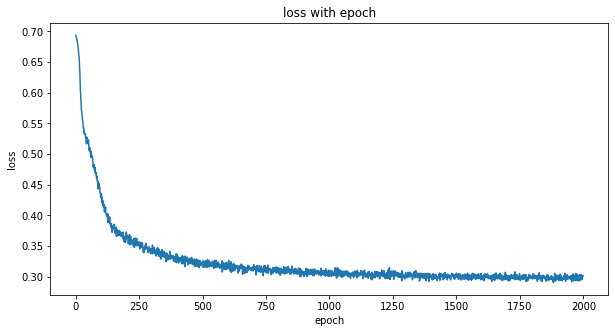

In [56]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1,2000), loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss with epoch')
plt.show()